In [33]:
import os
import sys
from scipy.stats import gaussian_kde
import numpy as np
import MDAnalysis
from MDAnalysis import *
import MDAnalysis as mda
import networkx as nx
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from MDAnalysis.analysis import align
from MDAnalysis.lib.distances import distance_array
from MDAnalysis.lib.distances import self_distance_array
from MDAnalysis.lib.distances import calc_dihedrals

helix = [1,2,3,4,5,6,7]
turn = [8,9,14]
thten = [10,11,12,13]
unspecified = [15,16,17,18,19]

def makehist(data, datalabel, mina = 0.0, maxb = 1.0, bins = 100, scale=1.0):
    y,binEdges = np.histogram(data,bins=bins,range=(mina, maxb))
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    bincenters = bincenters*scale
    plt.plot(bincenters, y/np.trapz(y, bincenters), label=datalabel, lw =2)
    
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)
    
def convert(REF):
    u = Universe(REF)
    ca = u.select_atoms("name CA")
    ca.names='BB'
    ca.write("CG.pdb")
    os.system("gmx editconf -f CG.pdb -o CG.gro -center 10 10 10 -box 20 20 20")
    os.system("gmx genconf -f CG.gro -o CG.gro")
    u = Universe("CG.gro")
    u.select_atoms("name BB").write("CG_BB.gro")
    os.system("gmx genconf -f CG_BB.gro -o CG_BB.gro")
    os.system("gmx editconf -f CG_BB.gro -center 10 10 10 -box 20.0 20.0 20.0 -o CG_BB.gro")
def create_rmsd(REF, TRAJ_PDB, TRAJ_XTC):
    convert(REF)
    u = Universe("CG_BB.gro")
    v = mda.Universe(TRAJ_PDB, TRAJ_XTC)
    protein = v.select_atoms("name BB")
    protein.write("prot.pdb")
    #v= u.select_atoms()
    prealigner = align.AlignTraj(v, u, select="name BB", in_memory=True).run()
    RMSD = prealigner.rmsd
    return RMSD
    
def create_rmsd_p(REF, TRAJ_PDB, TRAJ_XTC, part="resid 1:7"):
    convert(REF)
    u = Universe("CG_BB.gro")
    v = mda.Universe(TRAJ_PDB, TRAJ_XTC)
    protein = v.select_atoms("name BB")
    protein.write("prot.pdb")
    #v= u.select_atoms()
    prealigner = align.AlignTraj(v, u, select="name BB and "+part, in_memory=True).run()
    RMSD = prealigner.rmsd
    return RMSD

def rad_of_gyration(TRAJ_PDB, TRAJ_XTC):
    RG = []
    v = mda.Universe(TRAJ_PDB, TRAJ_XTC, in_memory=True)
    for ts in v.trajectory:
        RG.append(v.select_atoms("not resname PW ION CL").radius_of_gyration())
    RG = np.array(RG)
    return RG


TRAJ_XTC ="./nvt" 
REF_CA= "Ca2+_bound_calmodulin_structure_only_40_residues.pdb"
REF = "noca_ref.pdb"
TRAJ_PDB = "pp_chain_2_w1O_h2o.pdb"
rms = create_rmsd(REF, TRAJ_PDB, TRAJ_XTC)
rms_CA=create_rmsd(REF_CA, TRAJ_PDB, TRAJ_XTC)



/home/mjain123/anaconda3/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:722: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/mjain123/anaconda3/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:434: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to zeros.
  warnings.warn("1 A^3 CRYST1 record,"


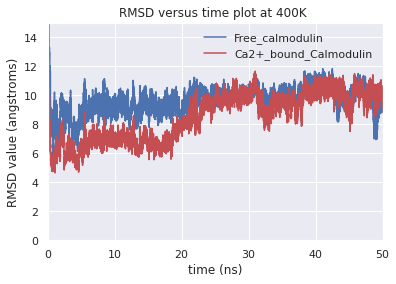

In [36]:
%matplotlib inline
#plt.plot(rms)
time=np.arange(0,50.001,0.001)
fig, ax = plt.subplots()
plt.xlabel("time (ns)")
plt.ylabel("RMSD value (angstroms)")
plt.title("RMSD versus time plot at 400K ")
ax.plot(time,rms,label='Free_calmodulin')
ax.axis([0,50,0,15])
ax.plot(time,rms_CA,'r', label='Ca2+_bound_Calmodulin')
ax.legend(frameon =False)
plt.savefig("./drive/rmsd_two_graphs_400.png",dpi=300)

In [25]:
from MDAnalysis.core.topologyobjects import Angle, Dihedral
def calc_dihedral(TRAJ_PDB, TRAJ_XTC, a1, a2, a3, a4, skip):
    D = []
    u = Universe(TRAJ_PDB, TRAJ_XTC)
    for ts in u.trajectory[::10]:
        p1 = u.select_atoms("resid "+str(a1)+" and name BB")
        p2 = u.select_atoms("resid "+str(a2)+" and name BB")
        p3 = u.select_atoms("resid "+str(a3)+" and name BB")
        p4 = u.select_atoms("resid "+str(a4)+" and name BB")
        D.append(Dihedral([p1[0].index, p2[0].index, p3[0].index, p4[0].index], u, type=None, guessed=False, order=None).dihedral(pbc=True))
        #print (ts)
    return D



In [19]:
D = calc_dihedral(TRAJ_PDB, TRAJ_XTC, a1=6, a2=19, a3=32, a4=39, skip=1)
def makehist(data, datalabel, mina = 0.0, maxb = 1.0, bins = 100, scale=1.0):
    y,binEdges = np.histogram(data,bins=bins,range=(mina, maxb))
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    bincenters = bincenters*scale
   
    plt.plot(bincenters, y/np.trapz(y, bincenters), label=datalabel, lw =2)
    plt.axvspan(-48.7,-48.7, color='red', alpha=1.0)


In [11]:
def calc_dihedral(TRAJ_PDB, TRAJ_XTC, a1, a2, a3, a4, skip):
    D = []
    u = Universe(TRAJ_PDB, TRAJ_XTC)
    for ts in u.trajectory[::skip]:
        p1 = u.select_atoms("resid "+str(a1)+" and name BB")
        p2 = u.select_atoms("resid "+str(a2)+" and name BB")
        p3 = u.select_atoms("resid "+str(a3)+" and name BB")
        p4 = u.select_atoms("resid "+str(a4)+" and name BB")
        D.append(Dihedral([p1[0].index, p2[0].index, p3[0].index, p4[0].index], u, type=None, guessed=False, order=None).dihedral(pbc=True))
        print (ts)
    return D
D = calc_dihedral(TRAJ_PDB, TRAJ_XTC, a1=6, a2=19, a3=32, a4=39, skip=1)#mind the skip
RMS = create_rmsd(REF, TRAJ_PDB, TRAJ_XTC)
xy = np.vstack([RMS,D])
z = gaussian_kde(xy)(xy)


< Timestep 0 with unit cell dimensions [158.4783 158.4783 158.4783  90.      90.      90.    ] >
< Timestep 1 with unit cell dimensions [158.4419 158.4419 158.4419  90.      90.      90.    ] >
< Timestep 2 with unit cell dimensions [158.4096 158.4096 158.4096  90.      90.      90.    ] >
< Timestep 3 with unit cell dimensions [158.37582 158.37582 158.37582  90.       90.       90.     ] >
< Timestep 4 with unit cell dimensions [158.33662 158.33662 158.33662  90.       90.       90.     ] >
< Timestep 5 with unit cell dimensions [158.30511 158.30511 158.30511  90.       90.       90.     ] >
< Timestep 6 with unit cell dimensions [158.2655 158.2655 158.2655  90.      90.      90.    ] >
< Timestep 7 with unit cell dimensions [158.23198 158.23198 158.23198  90.       90.       90.     ] >
< Timestep 8 with unit cell dimensions [158.1969 158.1969 158.1969  90.      90.      90.    ] >
< Timestep 9 with unit cell dimensions [158.16408 158.16408 158.16408  90.       90.       90.     ] >


< Timestep 136 with unit cell dimensions [157.16505 157.16505 157.16505  90.       90.       90.     ] >
< Timestep 137 with unit cell dimensions [157.16084 157.16084 157.16084  90.       90.       90.     ] >
< Timestep 138 with unit cell dimensions [157.1607 157.1607 157.1607  90.      90.      90.    ] >
< Timestep 139 with unit cell dimensions [157.15613 157.15613 157.15613  90.       90.       90.     ] >
< Timestep 140 with unit cell dimensions [157.15114 157.15114 157.15114  90.       90.       90.     ] >
< Timestep 141 with unit cell dimensions [157.15121 157.15121 157.15121  90.       90.       90.     ] >
< Timestep 142 with unit cell dimensions [157.15253 157.15253 157.15253  90.       90.       90.     ] >
< Timestep 143 with unit cell dimensions [157.15346 157.15346 157.15346  90.       90.       90.     ] >
< Timestep 144 with unit cell dimensions [157.15051 157.15051 157.15051  90.       90.       90.     ] >
< Timestep 145 with unit cell dimensions [157.15176 157.15176

< Timestep 274 with unit cell dimensions [157.17969 157.17969 157.17969  90.       90.       90.     ] >
< Timestep 275 with unit cell dimensions [157.1842 157.1842 157.1842  90.      90.      90.    ] >
< Timestep 276 with unit cell dimensions [157.1864 157.1864 157.1864  90.      90.      90.    ] >
< Timestep 277 with unit cell dimensions [157.18488 157.18488 157.18488  90.       90.       90.     ] >
< Timestep 278 with unit cell dimensions [157.1816 157.1816 157.1816  90.      90.      90.    ] >
< Timestep 279 with unit cell dimensions [157.17981 157.17981 157.17981  90.       90.       90.     ] >
< Timestep 280 with unit cell dimensions [157.17706 157.17706 157.17706  90.       90.       90.     ] >
< Timestep 281 with unit cell dimensions [157.18182 157.18182 157.18182  90.       90.       90.     ] >
< Timestep 282 with unit cell dimensions [157.18059 157.18059 157.18059  90.       90.       90.     ] >
< Timestep 283 with unit cell dimensions [157.17764 157.17764 157.17764  

< Timestep 405 with unit cell dimensions [157.1802 157.1802 157.1802  90.      90.      90.    ] >
< Timestep 406 with unit cell dimensions [157.18248 157.18248 157.18248  90.       90.       90.     ] >
< Timestep 407 with unit cell dimensions [157.18369 157.18369 157.18369  90.       90.       90.     ] >
< Timestep 408 with unit cell dimensions [157.1853 157.1853 157.1853  90.      90.      90.    ] >
< Timestep 409 with unit cell dimensions [157.18561 157.18561 157.18561  90.       90.       90.     ] >
< Timestep 410 with unit cell dimensions [157.18793 157.18793 157.18793  90.       90.       90.     ] >
< Timestep 411 with unit cell dimensions [157.18483 157.18483 157.18483  90.       90.       90.     ] >
< Timestep 412 with unit cell dimensions [157.18733 157.18733 157.18733  90.       90.       90.     ] >
< Timestep 413 with unit cell dimensions [157.18707 157.18707 157.18707  90.       90.       90.     ] >
< Timestep 414 with unit cell dimensions [157.1882 157.1882 157.188

< Timestep 541 with unit cell dimensions [157.16615 157.16615 157.16615  90.       90.       90.     ] >
< Timestep 542 with unit cell dimensions [157.16438 157.16438 157.16438  90.       90.       90.     ] >
< Timestep 543 with unit cell dimensions [157.16113 157.16113 157.16113  90.       90.       90.     ] >
< Timestep 544 with unit cell dimensions [157.16237 157.16237 157.16237  90.       90.       90.     ] >
< Timestep 545 with unit cell dimensions [157.16351 157.16351 157.16351  90.       90.       90.     ] >
< Timestep 546 with unit cell dimensions [157.16586 157.16586 157.16586  90.       90.       90.     ] >
< Timestep 547 with unit cell dimensions [157.16702 157.16702 157.16702  90.       90.       90.     ] >
< Timestep 548 with unit cell dimensions [157.16837 157.16837 157.16837  90.       90.       90.     ] >
< Timestep 549 with unit cell dimensions [157.16638 157.16638 157.16638  90.       90.       90.     ] >
< Timestep 550 with unit cell dimensions [157.1676 157.

< Timestep 680 with unit cell dimensions [157.16899 157.16899 157.16899  90.       90.       90.     ] >
< Timestep 681 with unit cell dimensions [157.16676 157.16676 157.16676  90.       90.       90.     ] >
< Timestep 682 with unit cell dimensions [157.16533 157.16533 157.16533  90.       90.       90.     ] >
< Timestep 683 with unit cell dimensions [157.17169 157.17169 157.17169  90.       90.       90.     ] >
< Timestep 684 with unit cell dimensions [157.17361 157.17361 157.17361  90.       90.       90.     ] >
< Timestep 685 with unit cell dimensions [157.17567 157.17567 157.17567  90.       90.       90.     ] >
< Timestep 686 with unit cell dimensions [157.17282 157.17282 157.17282  90.       90.       90.     ] >
< Timestep 687 with unit cell dimensions [157.17027 157.17027 157.17027  90.       90.       90.     ] >
< Timestep 688 with unit cell dimensions [157.16722 157.16722 157.16722  90.       90.       90.     ] >
< Timestep 689 with unit cell dimensions [157.16911 157

< Timestep 813 with unit cell dimensions [157.14487 157.14487 157.14487  90.       90.       90.     ] >
< Timestep 814 with unit cell dimensions [157.14891 157.14891 157.14891  90.       90.       90.     ] >
< Timestep 815 with unit cell dimensions [157.1492 157.1492 157.1492  90.      90.      90.    ] >
< Timestep 816 with unit cell dimensions [157.14647 157.14647 157.14647  90.       90.       90.     ] >
< Timestep 817 with unit cell dimensions [157.14789 157.14789 157.14789  90.       90.       90.     ] >
< Timestep 818 with unit cell dimensions [157.15071 157.15071 157.15071  90.       90.       90.     ] >
< Timestep 819 with unit cell dimensions [157.14822 157.14822 157.14822  90.       90.       90.     ] >
< Timestep 820 with unit cell dimensions [157.14932 157.14932 157.14932  90.       90.       90.     ] >
< Timestep 821 with unit cell dimensions [157.14804 157.14804 157.14804  90.       90.       90.     ] >
< Timestep 822 with unit cell dimensions [157.14568 157.14568

< Timestep 941 with unit cell dimensions [157.16455 157.16455 157.16455  90.       90.       90.     ] >
< Timestep 942 with unit cell dimensions [157.16357 157.16357 157.16357  90.       90.       90.     ] >
< Timestep 943 with unit cell dimensions [157.16377 157.16377 157.16377  90.       90.       90.     ] >
< Timestep 944 with unit cell dimensions [157.16417 157.16417 157.16417  90.       90.       90.     ] >
< Timestep 945 with unit cell dimensions [157.16223 157.16223 157.16223  90.       90.       90.     ] >
< Timestep 946 with unit cell dimensions [157.16048 157.16048 157.16048  90.       90.       90.     ] >
< Timestep 947 with unit cell dimensions [157.1648 157.1648 157.1648  90.      90.      90.    ] >
< Timestep 948 with unit cell dimensions [157.16577 157.16577 157.16577  90.       90.       90.     ] >
< Timestep 949 with unit cell dimensions [157.16054 157.16054 157.16054  90.       90.       90.     ] >
< Timestep 950 with unit cell dimensions [157.16208 157.16208

< Timestep 1074 with unit cell dimensions [157.16223 157.16223 157.16223  90.       90.       90.     ] >
< Timestep 1075 with unit cell dimensions [157.15639 157.15639 157.15639  90.       90.       90.     ] >
< Timestep 1076 with unit cell dimensions [157.15318 157.15318 157.15318  90.       90.       90.     ] >
< Timestep 1077 with unit cell dimensions [157.1501 157.1501 157.1501  90.      90.      90.    ] >
< Timestep 1078 with unit cell dimensions [157.14871 157.14871 157.14871  90.       90.       90.     ] >
< Timestep 1079 with unit cell dimensions [157.14835 157.14835 157.14835  90.       90.       90.     ] >
< Timestep 1080 with unit cell dimensions [157.14767 157.14767 157.14767  90.       90.       90.     ] >
< Timestep 1081 with unit cell dimensions [157.14728 157.14728 157.14728  90.       90.       90.     ] >
< Timestep 1082 with unit cell dimensions [157.15067 157.15067 157.15067  90.       90.       90.     ] >
< Timestep 1083 with unit cell dimensions [157.14877

< Timestep 1211 with unit cell dimensions [157.20198 157.20198 157.20198  90.       90.       90.     ] >
< Timestep 1212 with unit cell dimensions [157.20049 157.20049 157.20049  90.       90.       90.     ] >
< Timestep 1213 with unit cell dimensions [157.19725 157.19725 157.19725  90.       90.       90.     ] >
< Timestep 1214 with unit cell dimensions [157.19481 157.19481 157.19481  90.       90.       90.     ] >
< Timestep 1215 with unit cell dimensions [157.195 157.195 157.195  90.     90.     90.   ] >
< Timestep 1216 with unit cell dimensions [157.18904 157.18904 157.18904  90.       90.       90.     ] >
< Timestep 1217 with unit cell dimensions [157.18176 157.18176 157.18176  90.       90.       90.     ] >
< Timestep 1218 with unit cell dimensions [157.18456 157.18456 157.18456  90.       90.       90.     ] >
< Timestep 1219 with unit cell dimensions [157.18187 157.18187 157.18187  90.       90.       90.     ] >
< Timestep 1220 with unit cell dimensions [157.18124 157.1

< Timestep 1350 with unit cell dimensions [157.15793 157.15793 157.15793  90.       90.       90.     ] >
< Timestep 1351 with unit cell dimensions [157.1537 157.1537 157.1537  90.      90.      90.    ] >
< Timestep 1352 with unit cell dimensions [157.14906 157.14906 157.14906  90.       90.       90.     ] >
< Timestep 1353 with unit cell dimensions [157.15009 157.15009 157.15009  90.       90.       90.     ] >
< Timestep 1354 with unit cell dimensions [157.14728 157.14728 157.14728  90.       90.       90.     ] >
< Timestep 1355 with unit cell dimensions [157.14897 157.14897 157.14897  90.       90.       90.     ] >
< Timestep 1356 with unit cell dimensions [157.14435 157.14435 157.14435  90.       90.       90.     ] >
< Timestep 1357 with unit cell dimensions [157.14247 157.14247 157.14247  90.       90.       90.     ] >
< Timestep 1358 with unit cell dimensions [157.14308 157.14308 157.14308  90.       90.       90.     ] >
< Timestep 1359 with unit cell dimensions [157.14609

< Timestep 1477 with unit cell dimensions [157.17232 157.17232 157.17232  90.       90.       90.     ] >
< Timestep 1478 with unit cell dimensions [157.17119 157.17119 157.17119  90.       90.       90.     ] >
< Timestep 1479 with unit cell dimensions [157.1716 157.1716 157.1716  90.      90.      90.    ] >
< Timestep 1480 with unit cell dimensions [157.17441 157.17441 157.17441  90.       90.       90.     ] >
< Timestep 1481 with unit cell dimensions [157.17967 157.17967 157.17967  90.       90.       90.     ] >
< Timestep 1482 with unit cell dimensions [157.18436 157.18436 157.18436  90.       90.       90.     ] >
< Timestep 1483 with unit cell dimensions [157.1858 157.1858 157.1858  90.      90.      90.    ] >
< Timestep 1484 with unit cell dimensions [157.17691 157.17691 157.17691  90.       90.       90.     ] >
< Timestep 1485 with unit cell dimensions [157.17596 157.17596 157.17596  90.       90.       90.     ] >
< Timestep 1486 with unit cell dimensions [157.17899 157.1

< Timestep 1607 with unit cell dimensions [157.18607 157.18607 157.18607  90.       90.       90.     ] >
< Timestep 1608 with unit cell dimensions [157.1866 157.1866 157.1866  90.      90.      90.    ] >
< Timestep 1609 with unit cell dimensions [157.18245 157.18245 157.18245  90.       90.       90.     ] >
< Timestep 1610 with unit cell dimensions [157.18054 157.18054 157.18054  90.       90.       90.     ] >
< Timestep 1611 with unit cell dimensions [157.17656 157.17656 157.17656  90.       90.       90.     ] >
< Timestep 1612 with unit cell dimensions [157.17844 157.17844 157.17844  90.       90.       90.     ] >
< Timestep 1613 with unit cell dimensions [157.17497 157.17497 157.17497  90.       90.       90.     ] >
< Timestep 1614 with unit cell dimensions [157.17471 157.17471 157.17471  90.       90.       90.     ] >
< Timestep 1615 with unit cell dimensions [157.17386 157.17386 157.17386  90.       90.       90.     ] >
< Timestep 1616 with unit cell dimensions [157.1735 

< Timestep 1744 with unit cell dimensions [157.16121 157.16121 157.16121  90.       90.       90.     ] >
< Timestep 1745 with unit cell dimensions [157.16026 157.16026 157.16026  90.       90.       90.     ] >
< Timestep 1746 with unit cell dimensions [157.15729 157.15729 157.15729  90.       90.       90.     ] >
< Timestep 1747 with unit cell dimensions [157.15536 157.15536 157.15536  90.       90.       90.     ] >
< Timestep 1748 with unit cell dimensions [157.15732 157.15732 157.15732  90.       90.       90.     ] >
< Timestep 1749 with unit cell dimensions [157.16043 157.16043 157.16043  90.       90.       90.     ] >
< Timestep 1750 with unit cell dimensions [157.15915 157.15915 157.15915  90.       90.       90.     ] >
< Timestep 1751 with unit cell dimensions [157.16046 157.16046 157.16046  90.       90.       90.     ] >
< Timestep 1752 with unit cell dimensions [157.16287 157.16287 157.16287  90.       90.       90.     ] >
< Timestep 1753 with unit cell dimensions [157

< Timestep 1880 with unit cell dimensions [157.16376 157.16376 157.16376  90.       90.       90.     ] >
< Timestep 1881 with unit cell dimensions [157.16437 157.16437 157.16437  90.       90.       90.     ] >
< Timestep 1882 with unit cell dimensions [157.15955 157.15955 157.15955  90.       90.       90.     ] >
< Timestep 1883 with unit cell dimensions [157.15875 157.15875 157.15875  90.       90.       90.     ] >
< Timestep 1884 with unit cell dimensions [157.15918 157.15918 157.15918  90.       90.       90.     ] >
< Timestep 1885 with unit cell dimensions [157.16058 157.16058 157.16058  90.       90.       90.     ] >
< Timestep 1886 with unit cell dimensions [157.16174 157.16174 157.16174  90.       90.       90.     ] >
< Timestep 1887 with unit cell dimensions [157.16519 157.16519 157.16519  90.       90.       90.     ] >
< Timestep 1888 with unit cell dimensions [157.17036 157.17036 157.17036  90.       90.       90.     ] >
< Timestep 1889 with unit cell dimensions [157

< Timestep 2018 with unit cell dimensions [157.16708 157.16708 157.16708  90.       90.       90.     ] >
< Timestep 2019 with unit cell dimensions [157.1673 157.1673 157.1673  90.      90.      90.    ] >
< Timestep 2020 with unit cell dimensions [157.1659 157.1659 157.1659  90.      90.      90.    ] >
< Timestep 2021 with unit cell dimensions [157.17076 157.17076 157.17076  90.       90.       90.     ] >
< Timestep 2022 with unit cell dimensions [157.17989 157.17989 157.17989  90.       90.       90.     ] >
< Timestep 2023 with unit cell dimensions [157.18155 157.18155 157.18155  90.       90.       90.     ] >
< Timestep 2024 with unit cell dimensions [157.17973 157.17973 157.17973  90.       90.       90.     ] >
< Timestep 2025 with unit cell dimensions [157.18164 157.18164 157.18164  90.       90.       90.     ] >
< Timestep 2026 with unit cell dimensions [157.17874 157.17874 157.17874  90.       90.       90.     ] >
< Timestep 2027 with unit cell dimensions [157.17711 157.1

< Timestep 2154 with unit cell dimensions [157.1734 157.1734 157.1734  90.      90.      90.    ] >
< Timestep 2155 with unit cell dimensions [157.17126 157.17126 157.17126  90.       90.       90.     ] >
< Timestep 2156 with unit cell dimensions [157.17189 157.17189 157.17189  90.       90.       90.     ] >
< Timestep 2157 with unit cell dimensions [157.17673 157.17673 157.17673  90.       90.       90.     ] >
< Timestep 2158 with unit cell dimensions [157.17636 157.17636 157.17636  90.       90.       90.     ] >
< Timestep 2159 with unit cell dimensions [157.1736 157.1736 157.1736  90.      90.      90.    ] >
< Timestep 2160 with unit cell dimensions [157.17139 157.17139 157.17139  90.       90.       90.     ] >
< Timestep 2161 with unit cell dimensions [157.1724 157.1724 157.1724  90.      90.      90.    ] >
< Timestep 2162 with unit cell dimensions [157.1748 157.1748 157.1748  90.      90.      90.    ] >
< Timestep 2163 with unit cell dimensions [157.1702 157.1702 157.1702 

< Timestep 2291 with unit cell dimensions [157.16142 157.16142 157.16142  90.       90.       90.     ] >
< Timestep 2292 with unit cell dimensions [157.16277 157.16277 157.16277  90.       90.       90.     ] >
< Timestep 2293 with unit cell dimensions [157.16335 157.16335 157.16335  90.       90.       90.     ] >
< Timestep 2294 with unit cell dimensions [157.1706 157.1706 157.1706  90.      90.      90.    ] >
< Timestep 2295 with unit cell dimensions [157.17596 157.17596 157.17596  90.       90.       90.     ] >
< Timestep 2296 with unit cell dimensions [157.17473 157.17473 157.17473  90.       90.       90.     ] >
< Timestep 2297 with unit cell dimensions [157.17696 157.17696 157.17696  90.       90.       90.     ] >
< Timestep 2298 with unit cell dimensions [157.1782 157.1782 157.1782  90.      90.      90.    ] >
< Timestep 2299 with unit cell dimensions [157.1773 157.1773 157.1773  90.      90.      90.    ] >
< Timestep 2300 with unit cell dimensions [157.18013 157.18013 1

< Timestep 2431 with unit cell dimensions [157.18423 157.18423 157.18423  90.       90.       90.     ] >
< Timestep 2432 with unit cell dimensions [157.18533 157.18533 157.18533  90.       90.       90.     ] >
< Timestep 2433 with unit cell dimensions [157.18509 157.18509 157.18509  90.       90.       90.     ] >
< Timestep 2434 with unit cell dimensions [157.18375 157.18375 157.18375  90.       90.       90.     ] >
< Timestep 2435 with unit cell dimensions [157.1825 157.1825 157.1825  90.      90.      90.    ] >
< Timestep 2436 with unit cell dimensions [157.18173 157.18173 157.18173  90.       90.       90.     ] >
< Timestep 2437 with unit cell dimensions [157.18349 157.18349 157.18349  90.       90.       90.     ] >
< Timestep 2438 with unit cell dimensions [157.18748 157.18748 157.18748  90.       90.       90.     ] >
< Timestep 2439 with unit cell dimensions [157.19032 157.19032 157.19032  90.       90.       90.     ] >
< Timestep 2440 with unit cell dimensions [157.18793

< Timestep 2567 with unit cell dimensions [157.1691 157.1691 157.1691  90.      90.      90.    ] >
< Timestep 2568 with unit cell dimensions [157.17123 157.17123 157.17123  90.       90.       90.     ] >
< Timestep 2569 with unit cell dimensions [157.16748 157.16748 157.16748  90.       90.       90.     ] >
< Timestep 2570 with unit cell dimensions [157.16576 157.16576 157.16576  90.       90.       90.     ] >
< Timestep 2571 with unit cell dimensions [157.16808 157.16808 157.16808  90.       90.       90.     ] >
< Timestep 2572 with unit cell dimensions [157.1649 157.1649 157.1649  90.      90.      90.    ] >
< Timestep 2573 with unit cell dimensions [157.16777 157.16777 157.16777  90.       90.       90.     ] >
< Timestep 2574 with unit cell dimensions [157.1715 157.1715 157.1715  90.      90.      90.    ] >
< Timestep 2575 with unit cell dimensions [157.17241 157.17241 157.17241  90.       90.       90.     ] >
< Timestep 2576 with unit cell dimensions [157.16983 157.16983 1

< Timestep 2705 with unit cell dimensions [157.16982 157.16982 157.16982  90.       90.       90.     ] >
< Timestep 2706 with unit cell dimensions [157.17084 157.17084 157.17084  90.       90.       90.     ] >
< Timestep 2707 with unit cell dimensions [157.16623 157.16623 157.16623  90.       90.       90.     ] >
< Timestep 2708 with unit cell dimensions [157.1694 157.1694 157.1694  90.      90.      90.    ] >
< Timestep 2709 with unit cell dimensions [157.17726 157.17726 157.17726  90.       90.       90.     ] >
< Timestep 2710 with unit cell dimensions [157.17818 157.17818 157.17818  90.       90.       90.     ] >
< Timestep 2711 with unit cell dimensions [157.17474 157.17474 157.17474  90.       90.       90.     ] >
< Timestep 2712 with unit cell dimensions [157.17299 157.17299 157.17299  90.       90.       90.     ] >
< Timestep 2713 with unit cell dimensions [157.16905 157.16905 157.16905  90.       90.       90.     ] >
< Timestep 2714 with unit cell dimensions [157.17055

< Timestep 2840 with unit cell dimensions [157.1804 157.1804 157.1804  90.      90.      90.    ] >
< Timestep 2841 with unit cell dimensions [157.17691 157.17691 157.17691  90.       90.       90.     ] >
< Timestep 2842 with unit cell dimensions [157.17435 157.17435 157.17435  90.       90.       90.     ] >
< Timestep 2843 with unit cell dimensions [157.17508 157.17508 157.17508  90.       90.       90.     ] >
< Timestep 2844 with unit cell dimensions [157.17184 157.17184 157.17184  90.       90.       90.     ] >
< Timestep 2845 with unit cell dimensions [157.17169 157.17169 157.17169  90.       90.       90.     ] >
< Timestep 2846 with unit cell dimensions [157.1686 157.1686 157.1686  90.      90.      90.    ] >
< Timestep 2847 with unit cell dimensions [157.16335 157.16335 157.16335  90.       90.       90.     ] >
< Timestep 2848 with unit cell dimensions [157.1605 157.1605 157.1605  90.      90.      90.    ] >
< Timestep 2849 with unit cell dimensions [157.16106 157.16106 1

< Timestep 2979 with unit cell dimensions [157.14915 157.14915 157.14915  90.       90.       90.     ] >
< Timestep 2980 with unit cell dimensions [157.15405 157.15405 157.15405  90.       90.       90.     ] >
< Timestep 2981 with unit cell dimensions [157.15514 157.15514 157.15514  90.       90.       90.     ] >
< Timestep 2982 with unit cell dimensions [157.16046 157.16046 157.16046  90.       90.       90.     ] >
< Timestep 2983 with unit cell dimensions [157.15927 157.15927 157.15927  90.       90.       90.     ] >
< Timestep 2984 with unit cell dimensions [157.15509 157.15509 157.15509  90.       90.       90.     ] >
< Timestep 2985 with unit cell dimensions [157.15549 157.15549 157.15549  90.       90.       90.     ] >
< Timestep 2986 with unit cell dimensions [157.15614 157.15614 157.15614  90.       90.       90.     ] >
< Timestep 2987 with unit cell dimensions [157.1536 157.1536 157.1536  90.      90.      90.    ] >
< Timestep 2988 with unit cell dimensions [157.15771

< Timestep 3119 with unit cell dimensions [157.18863 157.18863 157.18863  90.       90.       90.     ] >
< Timestep 3120 with unit cell dimensions [157.19005 157.19005 157.19005  90.       90.       90.     ] >
< Timestep 3121 with unit cell dimensions [157.192 157.192 157.192  90.     90.     90.   ] >
< Timestep 3122 with unit cell dimensions [157.18997 157.18997 157.18997  90.       90.       90.     ] >
< Timestep 3123 with unit cell dimensions [157.19495 157.19495 157.19495  90.       90.       90.     ] >
< Timestep 3124 with unit cell dimensions [157.19955 157.19955 157.19955  90.       90.       90.     ] >
< Timestep 3125 with unit cell dimensions [157.19661 157.19661 157.19661  90.       90.       90.     ] >
< Timestep 3126 with unit cell dimensions [157.18906 157.18906 157.18906  90.       90.       90.     ] >
< Timestep 3127 with unit cell dimensions [157.18501 157.18501 157.18501  90.       90.       90.     ] >
< Timestep 3128 with unit cell dimensions [157.18132 157.1

< Timestep 3254 with unit cell dimensions [157.15837 157.15837 157.15837  90.       90.       90.     ] >
< Timestep 3255 with unit cell dimensions [157.15936 157.15936 157.15936  90.       90.       90.     ] >
< Timestep 3256 with unit cell dimensions [157.1625 157.1625 157.1625  90.      90.      90.    ] >
< Timestep 3257 with unit cell dimensions [157.16422 157.16422 157.16422  90.       90.       90.     ] >
< Timestep 3258 with unit cell dimensions [157.16261 157.16261 157.16261  90.       90.       90.     ] >
< Timestep 3259 with unit cell dimensions [157.16422 157.16422 157.16422  90.       90.       90.     ] >
< Timestep 3260 with unit cell dimensions [157.15924 157.15924 157.15924  90.       90.       90.     ] >
< Timestep 3261 with unit cell dimensions [157.16373 157.16373 157.16373  90.       90.       90.     ] >
< Timestep 3262 with unit cell dimensions [157.16269 157.16269 157.16269  90.       90.       90.     ] >
< Timestep 3263 with unit cell dimensions [157.16376

< Timestep 3393 with unit cell dimensions [157.17029 157.17029 157.17029  90.       90.       90.     ] >
< Timestep 3394 with unit cell dimensions [157.16827 157.16827 157.16827  90.       90.       90.     ] >
< Timestep 3395 with unit cell dimensions [157.16884 157.16884 157.16884  90.       90.       90.     ] >
< Timestep 3396 with unit cell dimensions [157.17001 157.17001 157.17001  90.       90.       90.     ] >
< Timestep 3397 with unit cell dimensions [157.16946 157.16946 157.16946  90.       90.       90.     ] >
< Timestep 3398 with unit cell dimensions [157.16798 157.16798 157.16798  90.       90.       90.     ] >
< Timestep 3399 with unit cell dimensions [157.16942 157.16942 157.16942  90.       90.       90.     ] >
< Timestep 3400 with unit cell dimensions [157.17499 157.17499 157.17499  90.       90.       90.     ] >
< Timestep 3401 with unit cell dimensions [157.18077 157.18077 157.18077  90.       90.       90.     ] >
< Timestep 3402 with unit cell dimensions [157

< Timestep 3531 with unit cell dimensions [157.1637 157.1637 157.1637  90.      90.      90.    ] >
< Timestep 3532 with unit cell dimensions [157.16396 157.16396 157.16396  90.       90.       90.     ] >
< Timestep 3533 with unit cell dimensions [157.16638 157.16638 157.16638  90.       90.       90.     ] >
< Timestep 3534 with unit cell dimensions [157.16739 157.16739 157.16739  90.       90.       90.     ] >
< Timestep 3535 with unit cell dimensions [157.16988 157.16988 157.16988  90.       90.       90.     ] >
< Timestep 3536 with unit cell dimensions [157.17232 157.17232 157.17232  90.       90.       90.     ] >
< Timestep 3537 with unit cell dimensions [157.17047 157.17047 157.17047  90.       90.       90.     ] >
< Timestep 3538 with unit cell dimensions [157.16647 157.16647 157.16647  90.       90.       90.     ] >
< Timestep 3539 with unit cell dimensions [157.16391 157.16391 157.16391  90.       90.       90.     ] >
< Timestep 3540 with unit cell dimensions [157.16568

< Timestep 3666 with unit cell dimensions [157.19527 157.19527 157.19527  90.       90.       90.     ] >
< Timestep 3667 with unit cell dimensions [157.19191 157.19191 157.19191  90.       90.       90.     ] >
< Timestep 3668 with unit cell dimensions [157.1881 157.1881 157.1881  90.      90.      90.    ] >
< Timestep 3669 with unit cell dimensions [157.18347 157.18347 157.18347  90.       90.       90.     ] >
< Timestep 3670 with unit cell dimensions [157.1824 157.1824 157.1824  90.      90.      90.    ] >
< Timestep 3671 with unit cell dimensions [157.18588 157.18588 157.18588  90.       90.       90.     ] >
< Timestep 3672 with unit cell dimensions [157.19412 157.19412 157.19412  90.       90.       90.     ] >
< Timestep 3673 with unit cell dimensions [157.20074 157.20074 157.20074  90.       90.       90.     ] >
< Timestep 3674 with unit cell dimensions [157.20667 157.20667 157.20667  90.       90.       90.     ] >
< Timestep 3675 with unit cell dimensions [157.20033 157.2

< Timestep 3806 with unit cell dimensions [157.15756 157.15756 157.15756  90.       90.       90.     ] >
< Timestep 3807 with unit cell dimensions [157.15521 157.15521 157.15521  90.       90.       90.     ] >
< Timestep 3808 with unit cell dimensions [157.15631 157.15631 157.15631  90.       90.       90.     ] >
< Timestep 3809 with unit cell dimensions [157.15654 157.15654 157.15654  90.       90.       90.     ] >
< Timestep 3810 with unit cell dimensions [157.15858 157.15858 157.15858  90.       90.       90.     ] >
< Timestep 3811 with unit cell dimensions [157.15598 157.15598 157.15598  90.       90.       90.     ] >
< Timestep 3812 with unit cell dimensions [157.15497 157.15497 157.15497  90.       90.       90.     ] >
< Timestep 3813 with unit cell dimensions [157.153 157.153 157.153  90.     90.     90.   ] >
< Timestep 3814 with unit cell dimensions [157.15155 157.15155 157.15155  90.       90.       90.     ] >
< Timestep 3815 with unit cell dimensions [157.15018 157.1

< Timestep 3944 with unit cell dimensions [157.159 157.159 157.159  90.     90.     90.   ] >
< Timestep 3945 with unit cell dimensions [157.16223 157.16223 157.16223  90.       90.       90.     ] >
< Timestep 3946 with unit cell dimensions [157.16295 157.16295 157.16295  90.       90.       90.     ] >
< Timestep 3947 with unit cell dimensions [157.16455 157.16455 157.16455  90.       90.       90.     ] >
< Timestep 3948 with unit cell dimensions [157.1654 157.1654 157.1654  90.      90.      90.    ] >
< Timestep 3949 with unit cell dimensions [157.16385 157.16385 157.16385  90.       90.       90.     ] >
< Timestep 3950 with unit cell dimensions [157.16516 157.16516 157.16516  90.       90.       90.     ] >
< Timestep 3951 with unit cell dimensions [157.16252 157.16252 157.16252  90.       90.       90.     ] >
< Timestep 3952 with unit cell dimensions [157.16127 157.16127 157.16127  90.       90.       90.     ] >
< Timestep 3953 with unit cell dimensions [157.1571 157.1571 157

< Timestep 4080 with unit cell dimensions [157.14558 157.14558 157.14558  90.       90.       90.     ] >
< Timestep 4081 with unit cell dimensions [157.14465 157.14465 157.14465  90.       90.       90.     ] >
< Timestep 4082 with unit cell dimensions [157.14833 157.14833 157.14833  90.       90.       90.     ] >
< Timestep 4083 with unit cell dimensions [157.14725 157.14725 157.14725  90.       90.       90.     ] >
< Timestep 4084 with unit cell dimensions [157.14706 157.14706 157.14706  90.       90.       90.     ] >
< Timestep 4085 with unit cell dimensions [157.1458 157.1458 157.1458  90.      90.      90.    ] >
< Timestep 4086 with unit cell dimensions [157.14793 157.14793 157.14793  90.       90.       90.     ] >
< Timestep 4087 with unit cell dimensions [157.14653 157.14653 157.14653  90.       90.       90.     ] >
< Timestep 4088 with unit cell dimensions [157.14827 157.14827 157.14827  90.       90.       90.     ] >
< Timestep 4089 with unit cell dimensions [157.14755

< Timestep 4218 with unit cell dimensions [157.17943 157.17943 157.17943  90.       90.       90.     ] >
< Timestep 4219 with unit cell dimensions [157.17657 157.17657 157.17657  90.       90.       90.     ] >
< Timestep 4220 with unit cell dimensions [157.17502 157.17502 157.17502  90.       90.       90.     ] >
< Timestep 4221 with unit cell dimensions [157.17538 157.17538 157.17538  90.       90.       90.     ] >
< Timestep 4222 with unit cell dimensions [157.17416 157.17416 157.17416  90.       90.       90.     ] >
< Timestep 4223 with unit cell dimensions [157.1733 157.1733 157.1733  90.      90.      90.    ] >
< Timestep 4224 with unit cell dimensions [157.17485 157.17485 157.17485  90.       90.       90.     ] >
< Timestep 4225 with unit cell dimensions [157.17825 157.17825 157.17825  90.       90.       90.     ] >
< Timestep 4226 with unit cell dimensions [157.17921 157.17921 157.17921  90.       90.       90.     ] >
< Timestep 4227 with unit cell dimensions [157.17517

< Timestep 4354 with unit cell dimensions [157.18706 157.18706 157.18706  90.       90.       90.     ] >
< Timestep 4355 with unit cell dimensions [157.18558 157.18558 157.18558  90.       90.       90.     ] >
< Timestep 4356 with unit cell dimensions [157.1882 157.1882 157.1882  90.      90.      90.    ] >
< Timestep 4357 with unit cell dimensions [157.18066 157.18066 157.18066  90.       90.       90.     ] >
< Timestep 4358 with unit cell dimensions [157.17743 157.17743 157.17743  90.       90.       90.     ] >
< Timestep 4359 with unit cell dimensions [157.1767 157.1767 157.1767  90.      90.      90.    ] >
< Timestep 4360 with unit cell dimensions [157.17584 157.17584 157.17584  90.       90.       90.     ] >
< Timestep 4361 with unit cell dimensions [157.18257 157.18257 157.18257  90.       90.       90.     ] >
< Timestep 4362 with unit cell dimensions [157.18407 157.18407 157.18407  90.       90.       90.     ] >
< Timestep 4363 with unit cell dimensions [157.1863 157.18

< Timestep 4491 with unit cell dimensions [157.18507 157.18507 157.18507  90.       90.       90.     ] >
< Timestep 4492 with unit cell dimensions [157.18504 157.18504 157.18504  90.       90.       90.     ] >
< Timestep 4493 with unit cell dimensions [157.18433 157.18433 157.18433  90.       90.       90.     ] >
< Timestep 4494 with unit cell dimensions [157.18744 157.18744 157.18744  90.       90.       90.     ] >
< Timestep 4495 with unit cell dimensions [157.18855 157.18855 157.18855  90.       90.       90.     ] >
< Timestep 4496 with unit cell dimensions [157.1813 157.1813 157.1813  90.      90.      90.    ] >
< Timestep 4497 with unit cell dimensions [157.18213 157.18213 157.18213  90.       90.       90.     ] >
< Timestep 4498 with unit cell dimensions [157.18062 157.18062 157.18062  90.       90.       90.     ] >
< Timestep 4499 with unit cell dimensions [157.18004 157.18004 157.18004  90.       90.       90.     ] >
< Timestep 4500 with unit cell dimensions [157.17702

< Timestep 4628 with unit cell dimensions [157.17038 157.17038 157.17038  90.       90.       90.     ] >
< Timestep 4629 with unit cell dimensions [157.16795 157.16795 157.16795  90.       90.       90.     ] >
< Timestep 4630 with unit cell dimensions [157.169 157.169 157.169  90.     90.     90.   ] >
< Timestep 4631 with unit cell dimensions [157.16664 157.16664 157.16664  90.       90.       90.     ] >
< Timestep 4632 with unit cell dimensions [157.16817 157.16817 157.16817  90.       90.       90.     ] >
< Timestep 4633 with unit cell dimensions [157.16852 157.16852 157.16852  90.       90.       90.     ] >
< Timestep 4634 with unit cell dimensions [157.1715 157.1715 157.1715  90.      90.      90.    ] >
< Timestep 4635 with unit cell dimensions [157.17532 157.17532 157.17532  90.       90.       90.     ] >
< Timestep 4636 with unit cell dimensions [157.1754 157.1754 157.1754  90.      90.      90.    ] >
< Timestep 4637 with unit cell dimensions [157.17851 157.17851 157.178

< Timestep 4764 with unit cell dimensions [157.17381 157.17381 157.17381  90.       90.       90.     ] >
< Timestep 4765 with unit cell dimensions [157.17725 157.17725 157.17725  90.       90.       90.     ] >
< Timestep 4766 with unit cell dimensions [157.18121 157.18121 157.18121  90.       90.       90.     ] >
< Timestep 4767 with unit cell dimensions [157.18321 157.18321 157.18321  90.       90.       90.     ] >
< Timestep 4768 with unit cell dimensions [157.18315 157.18315 157.18315  90.       90.       90.     ] >
< Timestep 4769 with unit cell dimensions [157.18272 157.18272 157.18272  90.       90.       90.     ] >
< Timestep 4770 with unit cell dimensions [157.18355 157.18355 157.18355  90.       90.       90.     ] >
< Timestep 4771 with unit cell dimensions [157.18582 157.18582 157.18582  90.       90.       90.     ] >
< Timestep 4772 with unit cell dimensions [157.18365 157.18365 157.18365  90.       90.       90.     ] >
< Timestep 4773 with unit cell dimensions [157

< Timestep 4901 with unit cell dimensions [157.17752 157.17752 157.17752  90.       90.       90.     ] >
< Timestep 4902 with unit cell dimensions [157.1712 157.1712 157.1712  90.      90.      90.    ] >
< Timestep 4903 with unit cell dimensions [157.16765 157.16765 157.16765  90.       90.       90.     ] >
< Timestep 4904 with unit cell dimensions [157.17064 157.17064 157.17064  90.       90.       90.     ] >
< Timestep 4905 with unit cell dimensions [157.17142 157.17142 157.17142  90.       90.       90.     ] >
< Timestep 4906 with unit cell dimensions [157.17532 157.17532 157.17532  90.       90.       90.     ] >
< Timestep 4907 with unit cell dimensions [157.17467 157.17467 157.17467  90.       90.       90.     ] >
< Timestep 4908 with unit cell dimensions [157.16763 157.16763 157.16763  90.       90.       90.     ] >
< Timestep 4909 with unit cell dimensions [157.1679 157.1679 157.1679  90.      90.      90.    ] >
< Timestep 4910 with unit cell dimensions [157.16496 157.1

< Timestep 5037 with unit cell dimensions [157.16682 157.16682 157.16682  90.       90.       90.     ] >
< Timestep 5038 with unit cell dimensions [157.17151 157.17151 157.17151  90.       90.       90.     ] >
< Timestep 5039 with unit cell dimensions [157.17459 157.17459 157.17459  90.       90.       90.     ] >
< Timestep 5040 with unit cell dimensions [157.17929 157.17929 157.17929  90.       90.       90.     ] >
< Timestep 5041 with unit cell dimensions [157.1798 157.1798 157.1798  90.      90.      90.    ] >
< Timestep 5042 with unit cell dimensions [157.18108 157.18108 157.18108  90.       90.       90.     ] >
< Timestep 5043 with unit cell dimensions [157.18039 157.18039 157.18039  90.       90.       90.     ] >
< Timestep 5044 with unit cell dimensions [157.18044 157.18044 157.18044  90.       90.       90.     ] >
< Timestep 5045 with unit cell dimensions [157.18288 157.18288 157.18288  90.       90.       90.     ] >
< Timestep 5046 with unit cell dimensions [157.18474

< Timestep 5174 with unit cell dimensions [157.15718 157.15718 157.15718  90.       90.       90.     ] >
< Timestep 5175 with unit cell dimensions [157.16167 157.16167 157.16167  90.       90.       90.     ] >
< Timestep 5176 with unit cell dimensions [157.1601 157.1601 157.1601  90.      90.      90.    ] >
< Timestep 5177 with unit cell dimensions [157.16394 157.16394 157.16394  90.       90.       90.     ] >
< Timestep 5178 with unit cell dimensions [157.15791 157.15791 157.15791  90.       90.       90.     ] >
< Timestep 5179 with unit cell dimensions [157.1557 157.1557 157.1557  90.      90.      90.    ] >
< Timestep 5180 with unit cell dimensions [157.1542 157.1542 157.1542  90.      90.      90.    ] >
< Timestep 5181 with unit cell dimensions [157.15211 157.15211 157.15211  90.       90.       90.     ] >
< Timestep 5182 with unit cell dimensions [157.15372 157.15372 157.15372  90.       90.       90.     ] >
< Timestep 5183 with unit cell dimensions [157.1538 157.1538 157

< Timestep 5315 with unit cell dimensions [157.17554 157.17554 157.17554  90.       90.       90.     ] >
< Timestep 5316 with unit cell dimensions [157.17555 157.17555 157.17555  90.       90.       90.     ] >
< Timestep 5317 with unit cell dimensions [157.17519 157.17519 157.17519  90.       90.       90.     ] >
< Timestep 5318 with unit cell dimensions [157.17223 157.17223 157.17223  90.       90.       90.     ] >
< Timestep 5319 with unit cell dimensions [157.17223 157.17223 157.17223  90.       90.       90.     ] >
< Timestep 5320 with unit cell dimensions [157.17256 157.17256 157.17256  90.       90.       90.     ] >
< Timestep 5321 with unit cell dimensions [157.1726 157.1726 157.1726  90.      90.      90.    ] >
< Timestep 5322 with unit cell dimensions [157.17154 157.17154 157.17154  90.       90.       90.     ] >
< Timestep 5323 with unit cell dimensions [157.16844 157.16844 157.16844  90.       90.       90.     ] >
< Timestep 5324 with unit cell dimensions [157.16931

< Timestep 5451 with unit cell dimensions [157.16678 157.16678 157.16678  90.       90.       90.     ] >
< Timestep 5452 with unit cell dimensions [157.1707 157.1707 157.1707  90.      90.      90.    ] >
< Timestep 5453 with unit cell dimensions [157.17049 157.17049 157.17049  90.       90.       90.     ] >
< Timestep 5454 with unit cell dimensions [157.16809 157.16809 157.16809  90.       90.       90.     ] >
< Timestep 5455 with unit cell dimensions [157.16817 157.16817 157.16817  90.       90.       90.     ] >
< Timestep 5456 with unit cell dimensions [157.1669 157.1669 157.1669  90.      90.      90.    ] >
< Timestep 5457 with unit cell dimensions [157.16974 157.16974 157.16974  90.       90.       90.     ] >
< Timestep 5458 with unit cell dimensions [157.1732 157.1732 157.1732  90.      90.      90.    ] >
< Timestep 5459 with unit cell dimensions [157.17496 157.17496 157.17496  90.       90.       90.     ] >
< Timestep 5460 with unit cell dimensions [157.1751 157.1751 157

< Timestep 5588 with unit cell dimensions [157.16753 157.16753 157.16753  90.       90.       90.     ] >
< Timestep 5589 with unit cell dimensions [157.16682 157.16682 157.16682  90.       90.       90.     ] >
< Timestep 5590 with unit cell dimensions [157.16498 157.16498 157.16498  90.       90.       90.     ] >
< Timestep 5591 with unit cell dimensions [157.15994 157.15994 157.15994  90.       90.       90.     ] >
< Timestep 5592 with unit cell dimensions [157.15715 157.15715 157.15715  90.       90.       90.     ] >
< Timestep 5593 with unit cell dimensions [157.15932 157.15932 157.15932  90.       90.       90.     ] >
< Timestep 5594 with unit cell dimensions [157.15944 157.15944 157.15944  90.       90.       90.     ] >
< Timestep 5595 with unit cell dimensions [157.16011 157.16011 157.16011  90.       90.       90.     ] >
< Timestep 5596 with unit cell dimensions [157.1572 157.1572 157.1572  90.      90.      90.    ] >
< Timestep 5597 with unit cell dimensions [157.15883

< Timestep 5728 with unit cell dimensions [157.17017 157.17017 157.17017  90.       90.       90.     ] >
< Timestep 5729 with unit cell dimensions [157.17 157.17 157.17  90.    90.    90.  ] >
< Timestep 5730 with unit cell dimensions [157.16885 157.16885 157.16885  90.       90.       90.     ] >
< Timestep 5731 with unit cell dimensions [157.16724 157.16724 157.16724  90.       90.       90.     ] >
< Timestep 5732 with unit cell dimensions [157.16508 157.16508 157.16508  90.       90.       90.     ] >
< Timestep 5733 with unit cell dimensions [157.16315 157.16315 157.16315  90.       90.       90.     ] >
< Timestep 5734 with unit cell dimensions [157.1616 157.1616 157.1616  90.      90.      90.    ] >
< Timestep 5735 with unit cell dimensions [157.15872 157.15872 157.15872  90.       90.       90.     ] >
< Timestep 5736 with unit cell dimensions [157.1513 157.1513 157.1513  90.      90.      90.    ] >
< Timestep 5737 with unit cell dimensions [157.15256 157.15256 157.15256  90

< Timestep 5867 with unit cell dimensions [157.15771 157.15771 157.15771  90.       90.       90.     ] >
< Timestep 5868 with unit cell dimensions [157.15761 157.15761 157.15761  90.       90.       90.     ] >
< Timestep 5869 with unit cell dimensions [157.15598 157.15598 157.15598  90.       90.       90.     ] >
< Timestep 5870 with unit cell dimensions [157.15404 157.15404 157.15404  90.       90.       90.     ] >
< Timestep 5871 with unit cell dimensions [157.15614 157.15614 157.15614  90.       90.       90.     ] >
< Timestep 5872 with unit cell dimensions [157.15749 157.15749 157.15749  90.       90.       90.     ] >
< Timestep 5873 with unit cell dimensions [157.15572 157.15572 157.15572  90.       90.       90.     ] >
< Timestep 5874 with unit cell dimensions [157.15765 157.15765 157.15765  90.       90.       90.     ] >
< Timestep 5875 with unit cell dimensions [157.1584 157.1584 157.1584  90.      90.      90.    ] >
< Timestep 5876 with unit cell dimensions [157.159 1

< Timestep 6003 with unit cell dimensions [157.1765 157.1765 157.1765  90.      90.      90.    ] >
< Timestep 6004 with unit cell dimensions [157.17415 157.17415 157.17415  90.       90.       90.     ] >
< Timestep 6005 with unit cell dimensions [157.17044 157.17044 157.17044  90.       90.       90.     ] >
< Timestep 6006 with unit cell dimensions [157.17206 157.17206 157.17206  90.       90.       90.     ] >
< Timestep 6007 with unit cell dimensions [157.17256 157.17256 157.17256  90.       90.       90.     ] >
< Timestep 6008 with unit cell dimensions [157.17114 157.17114 157.17114  90.       90.       90.     ] >
< Timestep 6009 with unit cell dimensions [157.17233 157.17233 157.17233  90.       90.       90.     ] >
< Timestep 6010 with unit cell dimensions [157.17175 157.17175 157.17175  90.       90.       90.     ] >
< Timestep 6011 with unit cell dimensions [157.17122 157.17122 157.17122  90.       90.       90.     ] >
< Timestep 6012 with unit cell dimensions [157.16852

< Timestep 6140 with unit cell dimensions [157.16371 157.16371 157.16371  90.       90.       90.     ] >
< Timestep 6141 with unit cell dimensions [157.15993 157.15993 157.15993  90.       90.       90.     ] >
< Timestep 6142 with unit cell dimensions [157.15945 157.15945 157.15945  90.       90.       90.     ] >
< Timestep 6143 with unit cell dimensions [157.15784 157.15784 157.15784  90.       90.       90.     ] >
< Timestep 6144 with unit cell dimensions [157.15982 157.15982 157.15982  90.       90.       90.     ] >
< Timestep 6145 with unit cell dimensions [157.15936 157.15936 157.15936  90.       90.       90.     ] >
< Timestep 6146 with unit cell dimensions [157.15396 157.15396 157.15396  90.       90.       90.     ] >
< Timestep 6147 with unit cell dimensions [157.14946 157.14946 157.14946  90.       90.       90.     ] >
< Timestep 6148 with unit cell dimensions [157.14995 157.14995 157.14995  90.       90.       90.     ] >
< Timestep 6149 with unit cell dimensions [157

< Timestep 6270 with unit cell dimensions [157.16068 157.16068 157.16068  90.       90.       90.     ] >
< Timestep 6271 with unit cell dimensions [157.15947 157.15947 157.15947  90.       90.       90.     ] >
< Timestep 6272 with unit cell dimensions [157.15692 157.15692 157.15692  90.       90.       90.     ] >
< Timestep 6273 with unit cell dimensions [157.16049 157.16049 157.16049  90.       90.       90.     ] >
< Timestep 6274 with unit cell dimensions [157.1598 157.1598 157.1598  90.      90.      90.    ] >
< Timestep 6275 with unit cell dimensions [157.16283 157.16283 157.16283  90.       90.       90.     ] >
< Timestep 6276 with unit cell dimensions [157.16315 157.16315 157.16315  90.       90.       90.     ] >
< Timestep 6277 with unit cell dimensions [157.16272 157.16272 157.16272  90.       90.       90.     ] >
< Timestep 6278 with unit cell dimensions [157.15692 157.15692 157.15692  90.       90.       90.     ] >
< Timestep 6279 with unit cell dimensions [157.1604 

< Timestep 6403 with unit cell dimensions [157.18771 157.18771 157.18771  90.       90.       90.     ] >
< Timestep 6404 with unit cell dimensions [157.18808 157.18808 157.18808  90.       90.       90.     ] >
< Timestep 6405 with unit cell dimensions [157.18878 157.18878 157.18878  90.       90.       90.     ] >
< Timestep 6406 with unit cell dimensions [157.18971 157.18971 157.18971  90.       90.       90.     ] >
< Timestep 6407 with unit cell dimensions [157.19002 157.19002 157.19002  90.       90.       90.     ] >
< Timestep 6408 with unit cell dimensions [157.18973 157.18973 157.18973  90.       90.       90.     ] >
< Timestep 6409 with unit cell dimensions [157.19225 157.19225 157.19225  90.       90.       90.     ] >
< Timestep 6410 with unit cell dimensions [157.19377 157.19377 157.19377  90.       90.       90.     ] >
< Timestep 6411 with unit cell dimensions [157.19226 157.19226 157.19226  90.       90.       90.     ] >
< Timestep 6412 with unit cell dimensions [157

< Timestep 6536 with unit cell dimensions [157.17088 157.17088 157.17088  90.       90.       90.     ] >
< Timestep 6537 with unit cell dimensions [157.1663 157.1663 157.1663  90.      90.      90.    ] >
< Timestep 6538 with unit cell dimensions [157.16582 157.16582 157.16582  90.       90.       90.     ] >
< Timestep 6539 with unit cell dimensions [157.16368 157.16368 157.16368  90.       90.       90.     ] >
< Timestep 6540 with unit cell dimensions [157.16544 157.16544 157.16544  90.       90.       90.     ] >
< Timestep 6541 with unit cell dimensions [157.16556 157.16556 157.16556  90.       90.       90.     ] >
< Timestep 6542 with unit cell dimensions [157.17235 157.17235 157.17235  90.       90.       90.     ] >
< Timestep 6543 with unit cell dimensions [157.1749 157.1749 157.1749  90.      90.      90.    ] >
< Timestep 6544 with unit cell dimensions [157.17085 157.17085 157.17085  90.       90.       90.     ] >
< Timestep 6545 with unit cell dimensions [157.16791 157.1

< Timestep 6670 with unit cell dimensions [157.13306 157.13306 157.13306  90.       90.       90.     ] >
< Timestep 6671 with unit cell dimensions [157.13704 157.13704 157.13704  90.       90.       90.     ] >
< Timestep 6672 with unit cell dimensions [157.13686 157.13686 157.13686  90.       90.       90.     ] >
< Timestep 6673 with unit cell dimensions [157.13708 157.13708 157.13708  90.       90.       90.     ] >
< Timestep 6674 with unit cell dimensions [157.13603 157.13603 157.13603  90.       90.       90.     ] >
< Timestep 6675 with unit cell dimensions [157.13792 157.13792 157.13792  90.       90.       90.     ] >
< Timestep 6676 with unit cell dimensions [157.13686 157.13686 157.13686  90.       90.       90.     ] >
< Timestep 6677 with unit cell dimensions [157.13889 157.13889 157.13889  90.       90.       90.     ] >
< Timestep 6678 with unit cell dimensions [157.14204 157.14204 157.14204  90.       90.       90.     ] >
< Timestep 6679 with unit cell dimensions [157

< Timestep 6806 with unit cell dimensions [157.14507 157.14507 157.14507  90.       90.       90.     ] >
< Timestep 6807 with unit cell dimensions [157.14624 157.14624 157.14624  90.       90.       90.     ] >
< Timestep 6808 with unit cell dimensions [157.14539 157.14539 157.14539  90.       90.       90.     ] >
< Timestep 6809 with unit cell dimensions [157.14856 157.14856 157.14856  90.       90.       90.     ] >
< Timestep 6810 with unit cell dimensions [157.14825 157.14825 157.14825  90.       90.       90.     ] >
< Timestep 6811 with unit cell dimensions [157.14522 157.14522 157.14522  90.       90.       90.     ] >
< Timestep 6812 with unit cell dimensions [157.14552 157.14552 157.14552  90.       90.       90.     ] >
< Timestep 6813 with unit cell dimensions [157.14522 157.14522 157.14522  90.       90.       90.     ] >
< Timestep 6814 with unit cell dimensions [157.14803 157.14803 157.14803  90.       90.       90.     ] >
< Timestep 6815 with unit cell dimensions [157

< Timestep 6943 with unit cell dimensions [157.13535 157.13535 157.13535  90.       90.       90.     ] >
< Timestep 6944 with unit cell dimensions [157.13568 157.13568 157.13568  90.       90.       90.     ] >
< Timestep 6945 with unit cell dimensions [157.1354 157.1354 157.1354  90.      90.      90.    ] >
< Timestep 6946 with unit cell dimensions [157.13945 157.13945 157.13945  90.       90.       90.     ] >
< Timestep 6947 with unit cell dimensions [157.14105 157.14105 157.14105  90.       90.       90.     ] >
< Timestep 6948 with unit cell dimensions [157.14175 157.14175 157.14175  90.       90.       90.     ] >
< Timestep 6949 with unit cell dimensions [157.14265 157.14265 157.14265  90.       90.       90.     ] >
< Timestep 6950 with unit cell dimensions [157.14713 157.14713 157.14713  90.       90.       90.     ] >
< Timestep 6951 with unit cell dimensions [157.14328 157.14328 157.14328  90.       90.       90.     ] >
< Timestep 6952 with unit cell dimensions [157.14072

< Timestep 7081 with unit cell dimensions [157.15106 157.15106 157.15106  90.       90.       90.     ] >
< Timestep 7082 with unit cell dimensions [157.15323 157.15323 157.15323  90.       90.       90.     ] >
< Timestep 7083 with unit cell dimensions [157.15303 157.15303 157.15303  90.       90.       90.     ] >
< Timestep 7084 with unit cell dimensions [157.15526 157.15526 157.15526  90.       90.       90.     ] >
< Timestep 7085 with unit cell dimensions [157.1557 157.1557 157.1557  90.      90.      90.    ] >
< Timestep 7086 with unit cell dimensions [157.1592 157.1592 157.1592  90.      90.      90.    ] >
< Timestep 7087 with unit cell dimensions [157.15782 157.15782 157.15782  90.       90.       90.     ] >
< Timestep 7088 with unit cell dimensions [157.15652 157.15652 157.15652  90.       90.       90.     ] >
< Timestep 7089 with unit cell dimensions [157.15323 157.15323 157.15323  90.       90.       90.     ] >
< Timestep 7090 with unit cell dimensions [157.15923 157.1

< Timestep 7221 with unit cell dimensions [157.15285 157.15285 157.15285  90.       90.       90.     ] >
< Timestep 7222 with unit cell dimensions [157.15039 157.15039 157.15039  90.       90.       90.     ] >
< Timestep 7223 with unit cell dimensions [157.15292 157.15292 157.15292  90.       90.       90.     ] >
< Timestep 7224 with unit cell dimensions [157.15627 157.15627 157.15627  90.       90.       90.     ] >
< Timestep 7225 with unit cell dimensions [157.15761 157.15761 157.15761  90.       90.       90.     ] >
< Timestep 7226 with unit cell dimensions [157.15767 157.15767 157.15767  90.       90.       90.     ] >
< Timestep 7227 with unit cell dimensions [157.1544 157.1544 157.1544  90.      90.      90.    ] >
< Timestep 7228 with unit cell dimensions [157.15582 157.15582 157.15582  90.       90.       90.     ] >
< Timestep 7229 with unit cell dimensions [157.15543 157.15543 157.15543  90.       90.       90.     ] >
< Timestep 7230 with unit cell dimensions [157.1573 

< Timestep 7355 with unit cell dimensions [157.16428 157.16428 157.16428  90.       90.       90.     ] >
< Timestep 7356 with unit cell dimensions [157.16153 157.16153 157.16153  90.       90.       90.     ] >
< Timestep 7357 with unit cell dimensions [157.16092 157.16092 157.16092  90.       90.       90.     ] >
< Timestep 7358 with unit cell dimensions [157.16258 157.16258 157.16258  90.       90.       90.     ] >
< Timestep 7359 with unit cell dimensions [157.15704 157.15704 157.15704  90.       90.       90.     ] >
< Timestep 7360 with unit cell dimensions [157.15894 157.15894 157.15894  90.       90.       90.     ] >
< Timestep 7361 with unit cell dimensions [157.16232 157.16232 157.16232  90.       90.       90.     ] >
< Timestep 7362 with unit cell dimensions [157.16727 157.16727 157.16727  90.       90.       90.     ] >
< Timestep 7363 with unit cell dimensions [157.167 157.167 157.167  90.     90.     90.   ] >
< Timestep 7364 with unit cell dimensions [157.16875 157.1

< Timestep 7492 with unit cell dimensions [157.15768 157.15768 157.15768  90.       90.       90.     ] >
< Timestep 7493 with unit cell dimensions [157.16011 157.16011 157.16011  90.       90.       90.     ] >
< Timestep 7494 with unit cell dimensions [157.15909 157.15909 157.15909  90.       90.       90.     ] >
< Timestep 7495 with unit cell dimensions [157.16019 157.16019 157.16019  90.       90.       90.     ] >
< Timestep 7496 with unit cell dimensions [157.16464 157.16464 157.16464  90.       90.       90.     ] >
< Timestep 7497 with unit cell dimensions [157.1645 157.1645 157.1645  90.      90.      90.    ] >
< Timestep 7498 with unit cell dimensions [157.16489 157.16489 157.16489  90.       90.       90.     ] >
< Timestep 7499 with unit cell dimensions [157.16927 157.16927 157.16927  90.       90.       90.     ] >
< Timestep 7500 with unit cell dimensions [157.16663 157.16663 157.16663  90.       90.       90.     ] >
< Timestep 7501 with unit cell dimensions [157.1647 

< Timestep 7628 with unit cell dimensions [157.14502 157.14502 157.14502  90.       90.       90.     ] >
< Timestep 7629 with unit cell dimensions [157.14365 157.14365 157.14365  90.       90.       90.     ] >
< Timestep 7630 with unit cell dimensions [157.14104 157.14104 157.14104  90.       90.       90.     ] >
< Timestep 7631 with unit cell dimensions [157.13809 157.13809 157.13809  90.       90.       90.     ] >
< Timestep 7632 with unit cell dimensions [157.1446 157.1446 157.1446  90.      90.      90.    ] >
< Timestep 7633 with unit cell dimensions [157.14812 157.14812 157.14812  90.       90.       90.     ] >
< Timestep 7634 with unit cell dimensions [157.15338 157.15338 157.15338  90.       90.       90.     ] >
< Timestep 7635 with unit cell dimensions [157.1542 157.1542 157.1542  90.      90.      90.    ] >
< Timestep 7636 with unit cell dimensions [157.15698 157.15698 157.15698  90.       90.       90.     ] >
< Timestep 7637 with unit cell dimensions [157.16135 157.1

< Timestep 7769 with unit cell dimensions [157.17798 157.17798 157.17798  90.       90.       90.     ] >
< Timestep 7770 with unit cell dimensions [157.1781 157.1781 157.1781  90.      90.      90.    ] >
< Timestep 7771 with unit cell dimensions [157.18152 157.18152 157.18152  90.       90.       90.     ] >
< Timestep 7772 with unit cell dimensions [157.17929 157.17929 157.17929  90.       90.       90.     ] >
< Timestep 7773 with unit cell dimensions [157.178 157.178 157.178  90.     90.     90.   ] >
< Timestep 7774 with unit cell dimensions [157.1723 157.1723 157.1723  90.      90.      90.    ] >
< Timestep 7775 with unit cell dimensions [157.17491 157.17491 157.17491  90.       90.       90.     ] >
< Timestep 7776 with unit cell dimensions [157.17516 157.17516 157.17516  90.       90.       90.     ] >
< Timestep 7777 with unit cell dimensions [157.17603 157.17603 157.17603  90.       90.       90.     ] >
< Timestep 7778 with unit cell dimensions [157.17725 157.17725 157.177

< Timestep 7905 with unit cell dimensions [157.1656 157.1656 157.1656  90.      90.      90.    ] >
< Timestep 7906 with unit cell dimensions [157.16306 157.16306 157.16306  90.       90.       90.     ] >
< Timestep 7907 with unit cell dimensions [157.16063 157.16063 157.16063  90.       90.       90.     ] >
< Timestep 7908 with unit cell dimensions [157.16008 157.16008 157.16008  90.       90.       90.     ] >
< Timestep 7909 with unit cell dimensions [157.15947 157.15947 157.15947  90.       90.       90.     ] >
< Timestep 7910 with unit cell dimensions [157.15732 157.15732 157.15732  90.       90.       90.     ] >
< Timestep 7911 with unit cell dimensions [157.15825 157.15825 157.15825  90.       90.       90.     ] >
< Timestep 7912 with unit cell dimensions [157.15903 157.15903 157.15903  90.       90.       90.     ] >
< Timestep 7913 with unit cell dimensions [157.16235 157.16235 157.16235  90.       90.       90.     ] >
< Timestep 7914 with unit cell dimensions [157.16338

< Timestep 8038 with unit cell dimensions [157.14677 157.14677 157.14677  90.       90.       90.     ] >
< Timestep 8039 with unit cell dimensions [157.14444 157.14444 157.14444  90.       90.       90.     ] >
< Timestep 8040 with unit cell dimensions [157.146 157.146 157.146  90.     90.     90.   ] >
< Timestep 8041 with unit cell dimensions [157.14534 157.14534 157.14534  90.       90.       90.     ] >
< Timestep 8042 with unit cell dimensions [157.14296 157.14296 157.14296  90.       90.       90.     ] >
< Timestep 8043 with unit cell dimensions [157.14067 157.14067 157.14067  90.       90.       90.     ] >
< Timestep 8044 with unit cell dimensions [157.14034 157.14034 157.14034  90.       90.       90.     ] >
< Timestep 8045 with unit cell dimensions [157.1355 157.1355 157.1355  90.      90.      90.    ] >
< Timestep 8046 with unit cell dimensions [157.13757 157.13757 157.13757  90.       90.       90.     ] >
< Timestep 8047 with unit cell dimensions [157.13864 157.13864 1

< Timestep 8174 with unit cell dimensions [157.15948 157.15948 157.15948  90.       90.       90.     ] >
< Timestep 8175 with unit cell dimensions [157.16098 157.16098 157.16098  90.       90.       90.     ] >
< Timestep 8176 with unit cell dimensions [157.16043 157.16043 157.16043  90.       90.       90.     ] >
< Timestep 8177 with unit cell dimensions [157.16142 157.16142 157.16142  90.       90.       90.     ] >
< Timestep 8178 with unit cell dimensions [157.16292 157.16292 157.16292  90.       90.       90.     ] >
< Timestep 8179 with unit cell dimensions [157.16272 157.16272 157.16272  90.       90.       90.     ] >
< Timestep 8180 with unit cell dimensions [157.16704 157.16704 157.16704  90.       90.       90.     ] >
< Timestep 8181 with unit cell dimensions [157.16367 157.16367 157.16367  90.       90.       90.     ] >
< Timestep 8182 with unit cell dimensions [157.16653 157.16653 157.16653  90.       90.       90.     ] >
< Timestep 8183 with unit cell dimensions [157

< Timestep 8309 with unit cell dimensions [157.1565 157.1565 157.1565  90.      90.      90.    ] >
< Timestep 8310 with unit cell dimensions [157.15283 157.15283 157.15283  90.       90.       90.     ] >
< Timestep 8311 with unit cell dimensions [157.1525 157.1525 157.1525  90.      90.      90.    ] >
< Timestep 8312 with unit cell dimensions [157.15613 157.15613 157.15613  90.       90.       90.     ] >
< Timestep 8313 with unit cell dimensions [157.16005 157.16005 157.16005  90.       90.       90.     ] >
< Timestep 8314 with unit cell dimensions [157.16112 157.16112 157.16112  90.       90.       90.     ] >
< Timestep 8315 with unit cell dimensions [157.15761 157.15761 157.15761  90.       90.       90.     ] >
< Timestep 8316 with unit cell dimensions [157.15646 157.15646 157.15646  90.       90.       90.     ] >
< Timestep 8317 with unit cell dimensions [157.15561 157.15561 157.15561  90.       90.       90.     ] >
< Timestep 8318 with unit cell dimensions [157.15547 157.1

< Timestep 8446 with unit cell dimensions [157.14539 157.14539 157.14539  90.       90.       90.     ] >
< Timestep 8447 with unit cell dimensions [157.14503 157.14503 157.14503  90.       90.       90.     ] >
< Timestep 8448 with unit cell dimensions [157.14502 157.14502 157.14502  90.       90.       90.     ] >
< Timestep 8449 with unit cell dimensions [157.14589 157.14589 157.14589  90.       90.       90.     ] >
< Timestep 8450 with unit cell dimensions [157.15063 157.15063 157.15063  90.       90.       90.     ] >
< Timestep 8451 with unit cell dimensions [157.15369 157.15369 157.15369  90.       90.       90.     ] >
< Timestep 8452 with unit cell dimensions [157.15343 157.15343 157.15343  90.       90.       90.     ] >
< Timestep 8453 with unit cell dimensions [157.15056 157.15056 157.15056  90.       90.       90.     ] >
< Timestep 8454 with unit cell dimensions [157.15213 157.15213 157.15213  90.       90.       90.     ] >
< Timestep 8455 with unit cell dimensions [157

< Timestep 8583 with unit cell dimensions [157.1562 157.1562 157.1562  90.      90.      90.    ] >
< Timestep 8584 with unit cell dimensions [157.16063 157.16063 157.16063  90.       90.       90.     ] >
< Timestep 8585 with unit cell dimensions [157.16493 157.16493 157.16493  90.       90.       90.     ] >
< Timestep 8586 with unit cell dimensions [157.16135 157.16135 157.16135  90.       90.       90.     ] >
< Timestep 8587 with unit cell dimensions [157.16241 157.16241 157.16241  90.       90.       90.     ] >
< Timestep 8588 with unit cell dimensions [157.16057 157.16057 157.16057  90.       90.       90.     ] >
< Timestep 8589 with unit cell dimensions [157.16313 157.16313 157.16313  90.       90.       90.     ] >
< Timestep 8590 with unit cell dimensions [157.16829 157.16829 157.16829  90.       90.       90.     ] >
< Timestep 8591 with unit cell dimensions [157.1686 157.1686 157.1686  90.      90.      90.    ] >
< Timestep 8592 with unit cell dimensions [157.16736 157.1

< Timestep 8719 with unit cell dimensions [157.18057 157.18057 157.18057  90.       90.       90.     ] >
< Timestep 8720 with unit cell dimensions [157.18149 157.18149 157.18149  90.       90.       90.     ] >
< Timestep 8721 with unit cell dimensions [157.17703 157.17703 157.17703  90.       90.       90.     ] >
< Timestep 8722 with unit cell dimensions [157.17401 157.17401 157.17401  90.       90.       90.     ] >
< Timestep 8723 with unit cell dimensions [157.17474 157.17474 157.17474  90.       90.       90.     ] >
< Timestep 8724 with unit cell dimensions [157.17294 157.17294 157.17294  90.       90.       90.     ] >
< Timestep 8725 with unit cell dimensions [157.16756 157.16756 157.16756  90.       90.       90.     ] >
< Timestep 8726 with unit cell dimensions [157.17065 157.17065 157.17065  90.       90.       90.     ] >
< Timestep 8727 with unit cell dimensions [157.17609 157.17609 157.17609  90.       90.       90.     ] >
< Timestep 8728 with unit cell dimensions [157

< Timestep 8855 with unit cell dimensions [157.1684 157.1684 157.1684  90.      90.      90.    ] >
< Timestep 8856 with unit cell dimensions [157.1679 157.1679 157.1679  90.      90.      90.    ] >
< Timestep 8857 with unit cell dimensions [157.1681 157.1681 157.1681  90.      90.      90.    ] >
< Timestep 8858 with unit cell dimensions [157.16998 157.16998 157.16998  90.       90.       90.     ] >
< Timestep 8859 with unit cell dimensions [157.17038 157.17038 157.17038  90.       90.       90.     ] >
< Timestep 8860 with unit cell dimensions [157.17055 157.17055 157.17055  90.       90.       90.     ] >
< Timestep 8861 with unit cell dimensions [157.16435 157.16435 157.16435  90.       90.       90.     ] >
< Timestep 8862 with unit cell dimensions [157.16083 157.16083 157.16083  90.       90.       90.     ] >
< Timestep 8863 with unit cell dimensions [157.16098 157.16098 157.16098  90.       90.       90.     ] >
< Timestep 8864 with unit cell dimensions [157.16273 157.16273 1

< Timestep 8993 with unit cell dimensions [157.1884 157.1884 157.1884  90.      90.      90.    ] >
< Timestep 8994 with unit cell dimensions [157.18549 157.18549 157.18549  90.       90.       90.     ] >
< Timestep 8995 with unit cell dimensions [157.18996 157.18996 157.18996  90.       90.       90.     ] >
< Timestep 8996 with unit cell dimensions [157.18542 157.18542 157.18542  90.       90.       90.     ] >
< Timestep 8997 with unit cell dimensions [157.19125 157.19125 157.19125  90.       90.       90.     ] >
< Timestep 8998 with unit cell dimensions [157.19138 157.19138 157.19138  90.       90.       90.     ] >
< Timestep 8999 with unit cell dimensions [157.18596 157.18596 157.18596  90.       90.       90.     ] >
< Timestep 9000 with unit cell dimensions [157.18636 157.18636 157.18636  90.       90.       90.     ] >
< Timestep 9001 with unit cell dimensions [157.18834 157.18834 157.18834  90.       90.       90.     ] >
< Timestep 9002 with unit cell dimensions [157.18591

< Timestep 9130 with unit cell dimensions [157.14937 157.14937 157.14937  90.       90.       90.     ] >
< Timestep 9131 with unit cell dimensions [157.15138 157.15138 157.15138  90.       90.       90.     ] >
< Timestep 9132 with unit cell dimensions [157.14665 157.14665 157.14665  90.       90.       90.     ] >
< Timestep 9133 with unit cell dimensions [157.1485 157.1485 157.1485  90.      90.      90.    ] >
< Timestep 9134 with unit cell dimensions [157.14748 157.14748 157.14748  90.       90.       90.     ] >
< Timestep 9135 with unit cell dimensions [157.1475 157.1475 157.1475  90.      90.      90.    ] >
< Timestep 9136 with unit cell dimensions [157.15298 157.15298 157.15298  90.       90.       90.     ] >
< Timestep 9137 with unit cell dimensions [157.15237 157.15237 157.15237  90.       90.       90.     ] >
< Timestep 9138 with unit cell dimensions [157.1571 157.1571 157.1571  90.      90.      90.    ] >
< Timestep 9139 with unit cell dimensions [157.16025 157.16025 1

< Timestep 9267 with unit cell dimensions [157.169 157.169 157.169  90.     90.     90.   ] >
< Timestep 9268 with unit cell dimensions [157.17232 157.17232 157.17232  90.       90.       90.     ] >
< Timestep 9269 with unit cell dimensions [157.17503 157.17503 157.17503  90.       90.       90.     ] >
< Timestep 9270 with unit cell dimensions [157.1718 157.1718 157.1718  90.      90.      90.    ] >
< Timestep 9271 with unit cell dimensions [157.16867 157.16867 157.16867  90.       90.       90.     ] >
< Timestep 9272 with unit cell dimensions [157.16885 157.16885 157.16885  90.       90.       90.     ] >
< Timestep 9273 with unit cell dimensions [157.17554 157.17554 157.17554  90.       90.       90.     ] >
< Timestep 9274 with unit cell dimensions [157.17697 157.17697 157.17697  90.       90.       90.     ] >
< Timestep 9275 with unit cell dimensions [157.17628 157.17628 157.17628  90.       90.       90.     ] >
< Timestep 9276 with unit cell dimensions [157.17662 157.17662 1

< Timestep 9405 with unit cell dimensions [157.15448 157.15448 157.15448  90.       90.       90.     ] >
< Timestep 9406 with unit cell dimensions [157.15346 157.15346 157.15346  90.       90.       90.     ] >
< Timestep 9407 with unit cell dimensions [157.15758 157.15758 157.15758  90.       90.       90.     ] >
< Timestep 9408 with unit cell dimensions [157.14957 157.14957 157.14957  90.       90.       90.     ] >
< Timestep 9409 with unit cell dimensions [157.14616 157.14616 157.14616  90.       90.       90.     ] >
< Timestep 9410 with unit cell dimensions [157.14594 157.14594 157.14594  90.       90.       90.     ] >
< Timestep 9411 with unit cell dimensions [157.14688 157.14688 157.14688  90.       90.       90.     ] >
< Timestep 9412 with unit cell dimensions [157.14929 157.14929 157.14929  90.       90.       90.     ] >
< Timestep 9413 with unit cell dimensions [157.14836 157.14836 157.14836  90.       90.       90.     ] >
< Timestep 9414 with unit cell dimensions [157

< Timestep 9545 with unit cell dimensions [157.15237 157.15237 157.15237  90.       90.       90.     ] >
< Timestep 9546 with unit cell dimensions [157.15163 157.15163 157.15163  90.       90.       90.     ] >
< Timestep 9547 with unit cell dimensions [157.14662 157.14662 157.14662  90.       90.       90.     ] >
< Timestep 9548 with unit cell dimensions [157.14827 157.14827 157.14827  90.       90.       90.     ] >
< Timestep 9549 with unit cell dimensions [157.14786 157.14786 157.14786  90.       90.       90.     ] >
< Timestep 9550 with unit cell dimensions [157.15408 157.15408 157.15408  90.       90.       90.     ] >
< Timestep 9551 with unit cell dimensions [157.15007 157.15007 157.15007  90.       90.       90.     ] >
< Timestep 9552 with unit cell dimensions [157.146 157.146 157.146  90.     90.     90.   ] >
< Timestep 9553 with unit cell dimensions [157.1478 157.1478 157.1478  90.      90.      90.    ] >
< Timestep 9554 with unit cell dimensions [157.14957 157.14957 1

< Timestep 9678 with unit cell dimensions [157.18561 157.18561 157.18561  90.       90.       90.     ] >
< Timestep 9679 with unit cell dimensions [157.18474 157.18474 157.18474  90.       90.       90.     ] >
< Timestep 9680 with unit cell dimensions [157.18593 157.18593 157.18593  90.       90.       90.     ] >
< Timestep 9681 with unit cell dimensions [157.1822 157.1822 157.1822  90.      90.      90.    ] >
< Timestep 9682 with unit cell dimensions [157.17688 157.17688 157.17688  90.       90.       90.     ] >
< Timestep 9683 with unit cell dimensions [157.17546 157.17546 157.17546  90.       90.       90.     ] >
< Timestep 9684 with unit cell dimensions [157.17368 157.17368 157.17368  90.       90.       90.     ] >
< Timestep 9685 with unit cell dimensions [157.17352 157.17352 157.17352  90.       90.       90.     ] >
< Timestep 9686 with unit cell dimensions [157.1737 157.1737 157.1737  90.      90.      90.    ] >
< Timestep 9687 with unit cell dimensions [157.17247 157.1

< Timestep 9815 with unit cell dimensions [157.189 157.189 157.189  90.     90.     90.   ] >
< Timestep 9816 with unit cell dimensions [157.18694 157.18694 157.18694  90.       90.       90.     ] >
< Timestep 9817 with unit cell dimensions [157.18561 157.18561 157.18561  90.       90.       90.     ] >
< Timestep 9818 with unit cell dimensions [157.19 157.19 157.19  90.    90.    90.  ] >
< Timestep 9819 with unit cell dimensions [157.1918 157.1918 157.1918  90.      90.      90.    ] >
< Timestep 9820 with unit cell dimensions [157.19049 157.19049 157.19049  90.       90.       90.     ] >
< Timestep 9821 with unit cell dimensions [157.18816 157.18816 157.18816  90.       90.       90.     ] >
< Timestep 9822 with unit cell dimensions [157.18655 157.18655 157.18655  90.       90.       90.     ] >
< Timestep 9823 with unit cell dimensions [157.18678 157.18678 157.18678  90.       90.       90.     ] >
< Timestep 9824 with unit cell dimensions [157.18768 157.18768 157.18768  90.     

< Timestep 9956 with unit cell dimensions [157.18869 157.18869 157.18869  90.       90.       90.     ] >
< Timestep 9957 with unit cell dimensions [157.18916 157.18916 157.18916  90.       90.       90.     ] >
< Timestep 9958 with unit cell dimensions [157.18295 157.18295 157.18295  90.       90.       90.     ] >
< Timestep 9959 with unit cell dimensions [157.187 157.187 157.187  90.     90.     90.   ] >
< Timestep 9960 with unit cell dimensions [157.1852 157.1852 157.1852  90.      90.      90.    ] >
< Timestep 9961 with unit cell dimensions [157.18456 157.18456 157.18456  90.       90.       90.     ] >
< Timestep 9962 with unit cell dimensions [157.1826 157.1826 157.1826  90.      90.      90.    ] >
< Timestep 9963 with unit cell dimensions [157.1834 157.1834 157.1834  90.      90.      90.    ] >
< Timestep 9964 with unit cell dimensions [157.18054 157.18054 157.18054  90.       90.       90.     ] >
< Timestep 9965 with unit cell dimensions [157.17805 157.17805 157.17805  90

< Timestep 10098 with unit cell dimensions [157.1649 157.1649 157.1649  90.      90.      90.    ] >
< Timestep 10099 with unit cell dimensions [157.16734 157.16734 157.16734  90.       90.       90.     ] >
< Timestep 10100 with unit cell dimensions [157.16458 157.16458 157.16458  90.       90.       90.     ] >
< Timestep 10101 with unit cell dimensions [157.16743 157.16743 157.16743  90.       90.       90.     ] >
< Timestep 10102 with unit cell dimensions [157.16872 157.16872 157.16872  90.       90.       90.     ] >
< Timestep 10103 with unit cell dimensions [157.16685 157.16685 157.16685  90.       90.       90.     ] >
< Timestep 10104 with unit cell dimensions [157.1673 157.1673 157.1673  90.      90.      90.    ] >
< Timestep 10105 with unit cell dimensions [157.16623 157.16623 157.16623  90.       90.       90.     ] >
< Timestep 10106 with unit cell dimensions [157.16626 157.16626 157.16626  90.       90.       90.     ] >
< Timestep 10107 with unit cell dimensions [157.1

< Timestep 10238 with unit cell dimensions [157.16145 157.16145 157.16145  90.       90.       90.     ] >
< Timestep 10239 with unit cell dimensions [157.16052 157.16052 157.16052  90.       90.       90.     ] >
< Timestep 10240 with unit cell dimensions [157.15605 157.15605 157.15605  90.       90.       90.     ] >
< Timestep 10241 with unit cell dimensions [157.15704 157.15704 157.15704  90.       90.       90.     ] >
< Timestep 10242 with unit cell dimensions [157.16122 157.16122 157.16122  90.       90.       90.     ] >
< Timestep 10243 with unit cell dimensions [157.16144 157.16144 157.16144  90.       90.       90.     ] >
< Timestep 10244 with unit cell dimensions [157.15784 157.15784 157.15784  90.       90.       90.     ] >
< Timestep 10245 with unit cell dimensions [157.15764 157.15764 157.15764  90.       90.       90.     ] >
< Timestep 10246 with unit cell dimensions [157.15817 157.15817 157.15817  90.       90.       90.     ] >
< Timestep 10247 with unit cell dimen

< Timestep 10375 with unit cell dimensions [157.16225 157.16225 157.16225  90.       90.       90.     ] >
< Timestep 10376 with unit cell dimensions [157.16302 157.16302 157.16302  90.       90.       90.     ] >
< Timestep 10377 with unit cell dimensions [157.159 157.159 157.159  90.     90.     90.   ] >
< Timestep 10378 with unit cell dimensions [157.15997 157.15997 157.15997  90.       90.       90.     ] >
< Timestep 10379 with unit cell dimensions [157.15616 157.15616 157.15616  90.       90.       90.     ] >
< Timestep 10380 with unit cell dimensions [157.16098 157.16098 157.16098  90.       90.       90.     ] >
< Timestep 10381 with unit cell dimensions [157.1659 157.1659 157.1659  90.      90.      90.    ] >
< Timestep 10382 with unit cell dimensions [157.16803 157.16803 157.16803  90.       90.       90.     ] >
< Timestep 10383 with unit cell dimensions [157.16884 157.16884 157.16884  90.       90.       90.     ] >
< Timestep 10384 with unit cell dimensions [157.16939 1

< Timestep 10511 with unit cell dimensions [157.16748 157.16748 157.16748  90.       90.       90.     ] >
< Timestep 10512 with unit cell dimensions [157.16798 157.16798 157.16798  90.       90.       90.     ] >
< Timestep 10513 with unit cell dimensions [157.16672 157.16672 157.16672  90.       90.       90.     ] >
< Timestep 10514 with unit cell dimensions [157.16803 157.16803 157.16803  90.       90.       90.     ] >
< Timestep 10515 with unit cell dimensions [157.16656 157.16656 157.16656  90.       90.       90.     ] >
< Timestep 10516 with unit cell dimensions [157.16708 157.16708 157.16708  90.       90.       90.     ] >
< Timestep 10517 with unit cell dimensions [157.1684 157.1684 157.1684  90.      90.      90.    ] >
< Timestep 10518 with unit cell dimensions [157.1698 157.1698 157.1698  90.      90.      90.    ] >
< Timestep 10519 with unit cell dimensions [157.17264 157.17264 157.17264  90.       90.       90.     ] >
< Timestep 10520 with unit cell dimensions [157.1

< Timestep 10649 with unit cell dimensions [157.1593 157.1593 157.1593  90.      90.      90.    ] >
< Timestep 10650 with unit cell dimensions [157.15923 157.15923 157.15923  90.       90.       90.     ] >
< Timestep 10651 with unit cell dimensions [157.15594 157.15594 157.15594  90.       90.       90.     ] >
< Timestep 10652 with unit cell dimensions [157.15227 157.15227 157.15227  90.       90.       90.     ] >
< Timestep 10653 with unit cell dimensions [157.14676 157.14676 157.14676  90.       90.       90.     ] >
< Timestep 10654 with unit cell dimensions [157.1447 157.1447 157.1447  90.      90.      90.    ] >
< Timestep 10655 with unit cell dimensions [157.14078 157.14078 157.14078  90.       90.       90.     ] >
< Timestep 10656 with unit cell dimensions [157.14348 157.14348 157.14348  90.       90.       90.     ] >
< Timestep 10657 with unit cell dimensions [157.14442 157.14442 157.14442  90.       90.       90.     ] >
< Timestep 10658 with unit cell dimensions [157.1

< Timestep 10782 with unit cell dimensions [157.17082 157.17082 157.17082  90.       90.       90.     ] >
< Timestep 10783 with unit cell dimensions [157.17256 157.17256 157.17256  90.       90.       90.     ] >
< Timestep 10784 with unit cell dimensions [157.16776 157.16776 157.16776  90.       90.       90.     ] >
< Timestep 10785 with unit cell dimensions [157.16365 157.16365 157.16365  90.       90.       90.     ] >
< Timestep 10786 with unit cell dimensions [157.1631 157.1631 157.1631  90.      90.      90.    ] >
< Timestep 10787 with unit cell dimensions [157.15892 157.15892 157.15892  90.       90.       90.     ] >
< Timestep 10788 with unit cell dimensions [157.1637 157.1637 157.1637  90.      90.      90.    ] >
< Timestep 10789 with unit cell dimensions [157.1622 157.1622 157.1622  90.      90.      90.    ] >
< Timestep 10790 with unit cell dimensions [157.16309 157.16309 157.16309  90.       90.       90.     ] >
< Timestep 10791 with unit cell dimensions [157.15982 1

< Timestep 10914 with unit cell dimensions [157.19095 157.19095 157.19095  90.       90.       90.     ] >
< Timestep 10915 with unit cell dimensions [157.19194 157.19194 157.19194  90.       90.       90.     ] >
< Timestep 10916 with unit cell dimensions [157.19012 157.19012 157.19012  90.       90.       90.     ] >
< Timestep 10917 with unit cell dimensions [157.19077 157.19077 157.19077  90.       90.       90.     ] >
< Timestep 10918 with unit cell dimensions [157.19302 157.19302 157.19302  90.       90.       90.     ] >
< Timestep 10919 with unit cell dimensions [157.19371 157.19371 157.19371  90.       90.       90.     ] >
< Timestep 10920 with unit cell dimensions [157.19412 157.19412 157.19412  90.       90.       90.     ] >
< Timestep 10921 with unit cell dimensions [157.19525 157.19525 157.19525  90.       90.       90.     ] >
< Timestep 10922 with unit cell dimensions [157.1929 157.1929 157.1929  90.      90.      90.    ] >
< Timestep 10923 with unit cell dimensions 

< Timestep 11049 with unit cell dimensions [157.18315 157.18315 157.18315  90.       90.       90.     ] >
< Timestep 11050 with unit cell dimensions [157.18353 157.18353 157.18353  90.       90.       90.     ] >
< Timestep 11051 with unit cell dimensions [157.18388 157.18388 157.18388  90.       90.       90.     ] >
< Timestep 11052 with unit cell dimensions [157.18126 157.18126 157.18126  90.       90.       90.     ] >
< Timestep 11053 with unit cell dimensions [157.17865 157.17865 157.17865  90.       90.       90.     ] >
< Timestep 11054 with unit cell dimensions [157.18007 157.18007 157.18007  90.       90.       90.     ] >
< Timestep 11055 with unit cell dimensions [157.17642 157.17642 157.17642  90.       90.       90.     ] >
< Timestep 11056 with unit cell dimensions [157.17638 157.17638 157.17638  90.       90.       90.     ] >
< Timestep 11057 with unit cell dimensions [157.18092 157.18092 157.18092  90.       90.       90.     ] >
< Timestep 11058 with unit cell dimen

< Timestep 11188 with unit cell dimensions [157.17424 157.17424 157.17424  90.       90.       90.     ] >
< Timestep 11189 with unit cell dimensions [157.17155 157.17155 157.17155  90.       90.       90.     ] >
< Timestep 11190 with unit cell dimensions [157.16788 157.16788 157.16788  90.       90.       90.     ] >
< Timestep 11191 with unit cell dimensions [157.16809 157.16809 157.16809  90.       90.       90.     ] >
< Timestep 11192 with unit cell dimensions [157.16498 157.16498 157.16498  90.       90.       90.     ] >
< Timestep 11193 with unit cell dimensions [157.16599 157.16599 157.16599  90.       90.       90.     ] >
< Timestep 11194 with unit cell dimensions [157.16841 157.16841 157.16841  90.       90.       90.     ] >
< Timestep 11195 with unit cell dimensions [157.17368 157.17368 157.17368  90.       90.       90.     ] >
< Timestep 11196 with unit cell dimensions [157.1736 157.1736 157.1736  90.      90.      90.    ] >
< Timestep 11197 with unit cell dimensions 

< Timestep 11323 with unit cell dimensions [157.17934 157.17934 157.17934  90.       90.       90.     ] >
< Timestep 11324 with unit cell dimensions [157.17685 157.17685 157.17685  90.       90.       90.     ] >
< Timestep 11325 with unit cell dimensions [157.17567 157.17567 157.17567  90.       90.       90.     ] >
< Timestep 11326 with unit cell dimensions [157.17215 157.17215 157.17215  90.       90.       90.     ] >
< Timestep 11327 with unit cell dimensions [157.17287 157.17287 157.17287  90.       90.       90.     ] >
< Timestep 11328 with unit cell dimensions [157.1738 157.1738 157.1738  90.      90.      90.    ] >
< Timestep 11329 with unit cell dimensions [157.17035 157.17035 157.17035  90.       90.       90.     ] >
< Timestep 11330 with unit cell dimensions [157.16895 157.16895 157.16895  90.       90.       90.     ] >
< Timestep 11331 with unit cell dimensions [157.16916 157.16916 157.16916  90.       90.       90.     ] >
< Timestep 11332 with unit cell dimensions 

< Timestep 11460 with unit cell dimensions [157.18378 157.18378 157.18378  90.       90.       90.     ] >
< Timestep 11461 with unit cell dimensions [157.18568 157.18568 157.18568  90.       90.       90.     ] >
< Timestep 11462 with unit cell dimensions [157.18343 157.18343 157.18343  90.       90.       90.     ] >
< Timestep 11463 with unit cell dimensions [157.17932 157.17932 157.17932  90.       90.       90.     ] >
< Timestep 11464 with unit cell dimensions [157.17284 157.17284 157.17284  90.       90.       90.     ] >
< Timestep 11465 with unit cell dimensions [157.17365 157.17365 157.17365  90.       90.       90.     ] >
< Timestep 11466 with unit cell dimensions [157.1711 157.1711 157.1711  90.      90.      90.    ] >
< Timestep 11467 with unit cell dimensions [157.16846 157.16846 157.16846  90.       90.       90.     ] >
< Timestep 11468 with unit cell dimensions [157.16397 157.16397 157.16397  90.       90.       90.     ] >
< Timestep 11469 with unit cell dimensions 

< Timestep 11595 with unit cell dimensions [157.17363 157.17363 157.17363  90.       90.       90.     ] >
< Timestep 11596 with unit cell dimensions [157.17476 157.17476 157.17476  90.       90.       90.     ] >
< Timestep 11597 with unit cell dimensions [157.17215 157.17215 157.17215  90.       90.       90.     ] >
< Timestep 11598 with unit cell dimensions [157.16989 157.16989 157.16989  90.       90.       90.     ] >
< Timestep 11599 with unit cell dimensions [157.17055 157.17055 157.17055  90.       90.       90.     ] >
< Timestep 11600 with unit cell dimensions [157.16776 157.16776 157.16776  90.       90.       90.     ] >
< Timestep 11601 with unit cell dimensions [157.16594 157.16594 157.16594  90.       90.       90.     ] >
< Timestep 11602 with unit cell dimensions [157.16696 157.16696 157.16696  90.       90.       90.     ] >
< Timestep 11603 with unit cell dimensions [157.16788 157.16788 157.16788  90.       90.       90.     ] >
< Timestep 11604 with unit cell dimen

< Timestep 11736 with unit cell dimensions [157.13669 157.13669 157.13669  90.       90.       90.     ] >
< Timestep 11737 with unit cell dimensions [157.1399 157.1399 157.1399  90.      90.      90.    ] >
< Timestep 11738 with unit cell dimensions [157.13734 157.13734 157.13734  90.       90.       90.     ] >
< Timestep 11739 with unit cell dimensions [157.13713 157.13713 157.13713  90.       90.       90.     ] >
< Timestep 11740 with unit cell dimensions [157.14185 157.14185 157.14185  90.       90.       90.     ] >
< Timestep 11741 with unit cell dimensions [157.1411 157.1411 157.1411  90.      90.      90.    ] >
< Timestep 11742 with unit cell dimensions [157.1412 157.1412 157.1412  90.      90.      90.    ] >
< Timestep 11743 with unit cell dimensions [157.14212 157.14212 157.14212  90.       90.       90.     ] >
< Timestep 11744 with unit cell dimensions [157.14383 157.14383 157.14383  90.       90.       90.     ] >
< Timestep 11745 with unit cell dimensions [157.14326 1

< Timestep 11873 with unit cell dimensions [157.17723 157.17723 157.17723  90.       90.       90.     ] >
< Timestep 11874 with unit cell dimensions [157.17993 157.17993 157.17993  90.       90.       90.     ] >
< Timestep 11875 with unit cell dimensions [157.17828 157.17828 157.17828  90.       90.       90.     ] >
< Timestep 11876 with unit cell dimensions [157.17822 157.17822 157.17822  90.       90.       90.     ] >
< Timestep 11877 with unit cell dimensions [157.17467 157.17467 157.17467  90.       90.       90.     ] >
< Timestep 11878 with unit cell dimensions [157.17404 157.17404 157.17404  90.       90.       90.     ] >
< Timestep 11879 with unit cell dimensions [157.17612 157.17612 157.17612  90.       90.       90.     ] >
< Timestep 11880 with unit cell dimensions [157.17445 157.17445 157.17445  90.       90.       90.     ] >
< Timestep 11881 with unit cell dimensions [157.17389 157.17389 157.17389  90.       90.       90.     ] >
< Timestep 11882 with unit cell dimen

< Timestep 12009 with unit cell dimensions [157.1799 157.1799 157.1799  90.      90.      90.    ] >
< Timestep 12010 with unit cell dimensions [157.17949 157.17949 157.17949  90.       90.       90.     ] >
< Timestep 12011 with unit cell dimensions [157.18068 157.18068 157.18068  90.       90.       90.     ] >
< Timestep 12012 with unit cell dimensions [157.18484 157.18484 157.18484  90.       90.       90.     ] >
< Timestep 12013 with unit cell dimensions [157.18495 157.18495 157.18495  90.       90.       90.     ] >
< Timestep 12014 with unit cell dimensions [157.18484 157.18484 157.18484  90.       90.       90.     ] >
< Timestep 12015 with unit cell dimensions [157.18758 157.18758 157.18758  90.       90.       90.     ] >
< Timestep 12016 with unit cell dimensions [157.18762 157.18762 157.18762  90.       90.       90.     ] >
< Timestep 12017 with unit cell dimensions [157.18388 157.18388 157.18388  90.       90.       90.     ] >
< Timestep 12018 with unit cell dimensions 

< Timestep 12145 with unit cell dimensions [157.16605 157.16605 157.16605  90.       90.       90.     ] >
< Timestep 12146 with unit cell dimensions [157.16676 157.16676 157.16676  90.       90.       90.     ] >
< Timestep 12147 with unit cell dimensions [157.16966 157.16966 157.16966  90.       90.       90.     ] >
< Timestep 12148 with unit cell dimensions [157.16997 157.16997 157.16997  90.       90.       90.     ] >
< Timestep 12149 with unit cell dimensions [157.16876 157.16876 157.16876  90.       90.       90.     ] >
< Timestep 12150 with unit cell dimensions [157.16708 157.16708 157.16708  90.       90.       90.     ] >
< Timestep 12151 with unit cell dimensions [157.16728 157.16728 157.16728  90.       90.       90.     ] >
< Timestep 12152 with unit cell dimensions [157.16876 157.16876 157.16876  90.       90.       90.     ] >
< Timestep 12153 with unit cell dimensions [157.1689 157.1689 157.1689  90.      90.      90.    ] >
< Timestep 12154 with unit cell dimensions 

< Timestep 12283 with unit cell dimensions [157.15303 157.15303 157.15303  90.       90.       90.     ] >
< Timestep 12284 with unit cell dimensions [157.1538 157.1538 157.1538  90.      90.      90.    ] >
< Timestep 12285 with unit cell dimensions [157.15555 157.15555 157.15555  90.       90.       90.     ] >
< Timestep 12286 with unit cell dimensions [157.1542 157.1542 157.1542  90.      90.      90.    ] >
< Timestep 12287 with unit cell dimensions [157.15346 157.15346 157.15346  90.       90.       90.     ] >
< Timestep 12288 with unit cell dimensions [157.15918 157.15918 157.15918  90.       90.       90.     ] >
< Timestep 12289 with unit cell dimensions [157.1564 157.1564 157.1564  90.      90.      90.    ] >
< Timestep 12290 with unit cell dimensions [157.1559 157.1559 157.1559  90.      90.      90.    ] >
< Timestep 12291 with unit cell dimensions [157.1576 157.1576 157.1576  90.      90.      90.    ] >
< Timestep 12292 with unit cell dimensions [157.1549 157.1549 157.1

< Timestep 12418 with unit cell dimensions [157.17276 157.17276 157.17276  90.       90.       90.     ] >
< Timestep 12419 with unit cell dimensions [157.17662 157.17662 157.17662  90.       90.       90.     ] >
< Timestep 12420 with unit cell dimensions [157.17409 157.17409 157.17409  90.       90.       90.     ] >
< Timestep 12421 with unit cell dimensions [157.17104 157.17104 157.17104  90.       90.       90.     ] >
< Timestep 12422 with unit cell dimensions [157.16971 157.16971 157.16971  90.       90.       90.     ] >
< Timestep 12423 with unit cell dimensions [157.17099 157.17099 157.17099  90.       90.       90.     ] >
< Timestep 12424 with unit cell dimensions [157.17131 157.17131 157.17131  90.       90.       90.     ] >
< Timestep 12425 with unit cell dimensions [157.1762 157.1762 157.1762  90.      90.      90.    ] >
< Timestep 12426 with unit cell dimensions [157.18083 157.18083 157.18083  90.       90.       90.     ] >
< Timestep 12427 with unit cell dimensions 

< Timestep 12552 with unit cell dimensions [157.16652 157.16652 157.16652  90.       90.       90.     ] >
< Timestep 12553 with unit cell dimensions [157.17311 157.17311 157.17311  90.       90.       90.     ] >
< Timestep 12554 with unit cell dimensions [157.17087 157.17087 157.17087  90.       90.       90.     ] >
< Timestep 12555 with unit cell dimensions [157.1627 157.1627 157.1627  90.      90.      90.    ] >
< Timestep 12556 with unit cell dimensions [157.16017 157.16017 157.16017  90.       90.       90.     ] >
< Timestep 12557 with unit cell dimensions [157.16019 157.16019 157.16019  90.       90.       90.     ] >
< Timestep 12558 with unit cell dimensions [157.1582 157.1582 157.1582  90.      90.      90.    ] >
< Timestep 12559 with unit cell dimensions [157.1586 157.1586 157.1586  90.      90.      90.    ] >
< Timestep 12560 with unit cell dimensions [157.15564 157.15564 157.15564  90.       90.       90.     ] >
< Timestep 12561 with unit cell dimensions [157.15552 1

< Timestep 12687 with unit cell dimensions [157.18202 157.18202 157.18202  90.       90.       90.     ] >
< Timestep 12688 with unit cell dimensions [157.17778 157.17778 157.17778  90.       90.       90.     ] >
< Timestep 12689 with unit cell dimensions [157.17015 157.17015 157.17015  90.       90.       90.     ] >
< Timestep 12690 with unit cell dimensions [157.16763 157.16763 157.16763  90.       90.       90.     ] >
< Timestep 12691 with unit cell dimensions [157.16934 157.16934 157.16934  90.       90.       90.     ] >
< Timestep 12692 with unit cell dimensions [157.17021 157.17021 157.17021  90.       90.       90.     ] >
< Timestep 12693 with unit cell dimensions [157.1702 157.1702 157.1702  90.      90.      90.    ] >
< Timestep 12694 with unit cell dimensions [157.16461 157.16461 157.16461  90.       90.       90.     ] >
< Timestep 12695 with unit cell dimensions [157.15877 157.15877 157.15877  90.       90.       90.     ] >
< Timestep 12696 with unit cell dimensions 

< Timestep 12824 with unit cell dimensions [157.16382 157.16382 157.16382  90.       90.       90.     ] >
< Timestep 12825 with unit cell dimensions [157.15985 157.15985 157.15985  90.       90.       90.     ] >
< Timestep 12826 with unit cell dimensions [157.16281 157.16281 157.16281  90.       90.       90.     ] >
< Timestep 12827 with unit cell dimensions [157.15862 157.15862 157.15862  90.       90.       90.     ] >
< Timestep 12828 with unit cell dimensions [157.15112 157.15112 157.15112  90.       90.       90.     ] >
< Timestep 12829 with unit cell dimensions [157.15152 157.15152 157.15152  90.       90.       90.     ] >
< Timestep 12830 with unit cell dimensions [157.15231 157.15231 157.15231  90.       90.       90.     ] >
< Timestep 12831 with unit cell dimensions [157.15436 157.15436 157.15436  90.       90.       90.     ] >
< Timestep 12832 with unit cell dimensions [157.15733 157.15733 157.15733  90.       90.       90.     ] >
< Timestep 12833 with unit cell dimen

< Timestep 12960 with unit cell dimensions [157.1943 157.1943 157.1943  90.      90.      90.    ] >
< Timestep 12961 with unit cell dimensions [157.19545 157.19545 157.19545  90.       90.       90.     ] >
< Timestep 12962 with unit cell dimensions [157.193 157.193 157.193  90.     90.     90.   ] >
< Timestep 12963 with unit cell dimensions [157.19508 157.19508 157.19508  90.       90.       90.     ] >
< Timestep 12964 with unit cell dimensions [157.19423 157.19423 157.19423  90.       90.       90.     ] >
< Timestep 12965 with unit cell dimensions [157.18654 157.18654 157.18654  90.       90.       90.     ] >
< Timestep 12966 with unit cell dimensions [157.1879 157.1879 157.1879  90.      90.      90.    ] >
< Timestep 12967 with unit cell dimensions [157.19073 157.19073 157.19073  90.       90.       90.     ] >
< Timestep 12968 with unit cell dimensions [157.1922 157.1922 157.1922  90.      90.      90.    ] >
< Timestep 12969 with unit cell dimensions [157.19693 157.19693 157

< Timestep 13097 with unit cell dimensions [157.19156 157.19156 157.19156  90.       90.       90.     ] >
< Timestep 13098 with unit cell dimensions [157.18832 157.18832 157.18832  90.       90.       90.     ] >
< Timestep 13099 with unit cell dimensions [157.18988 157.18988 157.18988  90.       90.       90.     ] >
< Timestep 13100 with unit cell dimensions [157.1857 157.1857 157.1857  90.      90.      90.    ] >
< Timestep 13101 with unit cell dimensions [157.18527 157.18527 157.18527  90.       90.       90.     ] >
< Timestep 13102 with unit cell dimensions [157.18314 157.18314 157.18314  90.       90.       90.     ] >
< Timestep 13103 with unit cell dimensions [157.18199 157.18199 157.18199  90.       90.       90.     ] >
< Timestep 13104 with unit cell dimensions [157.18294 157.18294 157.18294  90.       90.       90.     ] >
< Timestep 13105 with unit cell dimensions [157.18318 157.18318 157.18318  90.       90.       90.     ] >
< Timestep 13106 with unit cell dimensions 

< Timestep 13234 with unit cell dimensions [157.14519 157.14519 157.14519  90.       90.       90.     ] >
< Timestep 13235 with unit cell dimensions [157.14413 157.14413 157.14413  90.       90.       90.     ] >
< Timestep 13236 with unit cell dimensions [157.14581 157.14581 157.14581  90.       90.       90.     ] >
< Timestep 13237 with unit cell dimensions [157.14413 157.14413 157.14413  90.       90.       90.     ] >
< Timestep 13238 with unit cell dimensions [157.14778 157.14778 157.14778  90.       90.       90.     ] >
< Timestep 13239 with unit cell dimensions [157.15045 157.15045 157.15045  90.       90.       90.     ] >
< Timestep 13240 with unit cell dimensions [157.14806 157.14806 157.14806  90.       90.       90.     ] >
< Timestep 13241 with unit cell dimensions [157.14017 157.14017 157.14017  90.       90.       90.     ] >
< Timestep 13242 with unit cell dimensions [157.1353 157.1353 157.1353  90.      90.      90.    ] >
< Timestep 13243 with unit cell dimensions 

< Timestep 13371 with unit cell dimensions [157.1868 157.1868 157.1868  90.      90.      90.    ] >
< Timestep 13372 with unit cell dimensions [157.18138 157.18138 157.18138  90.       90.       90.     ] >
< Timestep 13373 with unit cell dimensions [157.17833 157.17833 157.17833  90.       90.       90.     ] >
< Timestep 13374 with unit cell dimensions [157.17485 157.17485 157.17485  90.       90.       90.     ] >
< Timestep 13375 with unit cell dimensions [157.17487 157.17487 157.17487  90.       90.       90.     ] >
< Timestep 13376 with unit cell dimensions [157.17894 157.17894 157.17894  90.       90.       90.     ] >
< Timestep 13377 with unit cell dimensions [157.18019 157.18019 157.18019  90.       90.       90.     ] >
< Timestep 13378 with unit cell dimensions [157.17992 157.17992 157.17992  90.       90.       90.     ] >
< Timestep 13379 with unit cell dimensions [157.17787 157.17787 157.17787  90.       90.       90.     ] >
< Timestep 13380 with unit cell dimensions 

< Timestep 13511 with unit cell dimensions [157.16869 157.16869 157.16869  90.       90.       90.     ] >
< Timestep 13512 with unit cell dimensions [157.17087 157.17087 157.17087  90.       90.       90.     ] >
< Timestep 13513 with unit cell dimensions [157.17203 157.17203 157.17203  90.       90.       90.     ] >
< Timestep 13514 with unit cell dimensions [157.17099 157.17099 157.17099  90.       90.       90.     ] >
< Timestep 13515 with unit cell dimensions [157.17058 157.17058 157.17058  90.       90.       90.     ] >
< Timestep 13516 with unit cell dimensions [157.173 157.173 157.173  90.     90.     90.   ] >
< Timestep 13517 with unit cell dimensions [157.17725 157.17725 157.17725  90.       90.       90.     ] >
< Timestep 13518 with unit cell dimensions [157.1795 157.1795 157.1795  90.      90.      90.    ] >
< Timestep 13519 with unit cell dimensions [157.17892 157.17892 157.17892  90.       90.       90.     ] >
< Timestep 13520 with unit cell dimensions [157.17955 1

< Timestep 13649 with unit cell dimensions [157.15167 157.15167 157.15167  90.       90.       90.     ] >
< Timestep 13650 with unit cell dimensions [157.15381 157.15381 157.15381  90.       90.       90.     ] >
< Timestep 13651 with unit cell dimensions [157.16156 157.16156 157.16156  90.       90.       90.     ] >
< Timestep 13652 with unit cell dimensions [157.16106 157.16106 157.16106  90.       90.       90.     ] >
< Timestep 13653 with unit cell dimensions [157.16145 157.16145 157.16145  90.       90.       90.     ] >
< Timestep 13654 with unit cell dimensions [157.16069 157.16069 157.16069  90.       90.       90.     ] >
< Timestep 13655 with unit cell dimensions [157.16154 157.16154 157.16154  90.       90.       90.     ] >
< Timestep 13656 with unit cell dimensions [157.1575 157.1575 157.1575  90.      90.      90.    ] >
< Timestep 13657 with unit cell dimensions [157.16052 157.16052 157.16052  90.       90.       90.     ] >
< Timestep 13658 with unit cell dimensions 

< Timestep 13786 with unit cell dimensions [157.17918 157.17918 157.17918  90.       90.       90.     ] >
< Timestep 13787 with unit cell dimensions [157.18103 157.18103 157.18103  90.       90.       90.     ] >
< Timestep 13788 with unit cell dimensions [157.18448 157.18448 157.18448  90.       90.       90.     ] >
< Timestep 13789 with unit cell dimensions [157.18768 157.18768 157.18768  90.       90.       90.     ] >
< Timestep 13790 with unit cell dimensions [157.18332 157.18332 157.18332  90.       90.       90.     ] >
< Timestep 13791 with unit cell dimensions [157.1818 157.1818 157.1818  90.      90.      90.    ] >
< Timestep 13792 with unit cell dimensions [157.18227 157.18227 157.18227  90.       90.       90.     ] >
< Timestep 13793 with unit cell dimensions [157.18329 157.18329 157.18329  90.       90.       90.     ] >
< Timestep 13794 with unit cell dimensions [157.18234 157.18234 157.18234  90.       90.       90.     ] >
< Timestep 13795 with unit cell dimensions 

< Timestep 13921 with unit cell dimensions [157.18352 157.18352 157.18352  90.       90.       90.     ] >
< Timestep 13922 with unit cell dimensions [157.18156 157.18156 157.18156  90.       90.       90.     ] >
< Timestep 13923 with unit cell dimensions [157.17853 157.17853 157.17853  90.       90.       90.     ] >
< Timestep 13924 with unit cell dimensions [157.17346 157.17346 157.17346  90.       90.       90.     ] >
< Timestep 13925 with unit cell dimensions [157.17523 157.17523 157.17523  90.       90.       90.     ] >
< Timestep 13926 with unit cell dimensions [157.17194 157.17194 157.17194  90.       90.       90.     ] >
< Timestep 13927 with unit cell dimensions [157.16971 157.16971 157.16971  90.       90.       90.     ] >
< Timestep 13928 with unit cell dimensions [157.16994 157.16994 157.16994  90.       90.       90.     ] >
< Timestep 13929 with unit cell dimensions [157.16837 157.16837 157.16837  90.       90.       90.     ] >
< Timestep 13930 with unit cell dimen

< Timestep 14064 with unit cell dimensions [157.17393 157.17393 157.17393  90.       90.       90.     ] >
< Timestep 14065 with unit cell dimensions [157.17264 157.17264 157.17264  90.       90.       90.     ] >
< Timestep 14066 with unit cell dimensions [157.17197 157.17197 157.17197  90.       90.       90.     ] >
< Timestep 14067 with unit cell dimensions [157.17947 157.17947 157.17947  90.       90.       90.     ] >
< Timestep 14068 with unit cell dimensions [157.17903 157.17903 157.17903  90.       90.       90.     ] >
< Timestep 14069 with unit cell dimensions [157.1808 157.1808 157.1808  90.      90.      90.    ] >
< Timestep 14070 with unit cell dimensions [157.17722 157.17722 157.17722  90.       90.       90.     ] >
< Timestep 14071 with unit cell dimensions [157.16867 157.16867 157.16867  90.       90.       90.     ] >
< Timestep 14072 with unit cell dimensions [157.1658 157.1658 157.1658  90.      90.      90.    ] >
< Timestep 14073 with unit cell dimensions [157.1

< Timestep 14188 with unit cell dimensions [157.1598 157.1598 157.1598  90.      90.      90.    ] >
< Timestep 14189 with unit cell dimensions [157.1617 157.1617 157.1617  90.      90.      90.    ] >
< Timestep 14190 with unit cell dimensions [157.16057 157.16057 157.16057  90.       90.       90.     ] >
< Timestep 14191 with unit cell dimensions [157.16058 157.16058 157.16058  90.       90.       90.     ] >
< Timestep 14192 with unit cell dimensions [157.16054 157.16054 157.16054  90.       90.       90.     ] >
< Timestep 14193 with unit cell dimensions [157.15556 157.15556 157.15556  90.       90.       90.     ] >
< Timestep 14194 with unit cell dimensions [157.15854 157.15854 157.15854  90.       90.       90.     ] >
< Timestep 14195 with unit cell dimensions [157.16429 157.16429 157.16429  90.       90.       90.     ] >
< Timestep 14196 with unit cell dimensions [157.16809 157.16809 157.16809  90.       90.       90.     ] >
< Timestep 14197 with unit cell dimensions [157.1

< Timestep 14322 with unit cell dimensions [157.17683 157.17683 157.17683  90.       90.       90.     ] >
< Timestep 14323 with unit cell dimensions [157.1821 157.1821 157.1821  90.      90.      90.    ] >
< Timestep 14324 with unit cell dimensions [157.18929 157.18929 157.18929  90.       90.       90.     ] >
< Timestep 14325 with unit cell dimensions [157.18991 157.18991 157.18991  90.       90.       90.     ] >
< Timestep 14326 with unit cell dimensions [157.1953 157.1953 157.1953  90.      90.      90.    ] >
< Timestep 14327 with unit cell dimensions [157.19394 157.19394 157.19394  90.       90.       90.     ] >
< Timestep 14328 with unit cell dimensions [157.19313 157.19313 157.19313  90.       90.       90.     ] >
< Timestep 14329 with unit cell dimensions [157.19121 157.19121 157.19121  90.       90.       90.     ] >
< Timestep 14330 with unit cell dimensions [157.19186 157.19186 157.19186  90.       90.       90.     ] >
< Timestep 14331 with unit cell dimensions [157.1

< Timestep 14457 with unit cell dimensions [157.15866 157.15866 157.15866  90.       90.       90.     ] >
< Timestep 14458 with unit cell dimensions [157.15666 157.15666 157.15666  90.       90.       90.     ] >
< Timestep 14459 with unit cell dimensions [157.15991 157.15991 157.15991  90.       90.       90.     ] >
< Timestep 14460 with unit cell dimensions [157.15967 157.15967 157.15967  90.       90.       90.     ] >
< Timestep 14461 with unit cell dimensions [157.16185 157.16185 157.16185  90.       90.       90.     ] >
< Timestep 14462 with unit cell dimensions [157.16162 157.16162 157.16162  90.       90.       90.     ] >
< Timestep 14463 with unit cell dimensions [157.16092 157.16092 157.16092  90.       90.       90.     ] >
< Timestep 14464 with unit cell dimensions [157.15874 157.15874 157.15874  90.       90.       90.     ] >
< Timestep 14465 with unit cell dimensions [157.1652 157.1652 157.1652  90.      90.      90.    ] >
< Timestep 14466 with unit cell dimensions 

< Timestep 14600 with unit cell dimensions [157.17625 157.17625 157.17625  90.       90.       90.     ] >
< Timestep 14601 with unit cell dimensions [157.17754 157.17754 157.17754  90.       90.       90.     ] >
< Timestep 14602 with unit cell dimensions [157.18044 157.18044 157.18044  90.       90.       90.     ] >
< Timestep 14603 with unit cell dimensions [157.18124 157.18124 157.18124  90.       90.       90.     ] >
< Timestep 14604 with unit cell dimensions [157.18103 157.18103 157.18103  90.       90.       90.     ] >
< Timestep 14605 with unit cell dimensions [157.17992 157.17992 157.17992  90.       90.       90.     ] >
< Timestep 14606 with unit cell dimensions [157.17542 157.17542 157.17542  90.       90.       90.     ] >
< Timestep 14607 with unit cell dimensions [157.17294 157.17294 157.17294  90.       90.       90.     ] >
< Timestep 14608 with unit cell dimensions [157.17609 157.17609 157.17609  90.       90.       90.     ] >
< Timestep 14609 with unit cell dimen

< Timestep 14736 with unit cell dimensions [157.15692 157.15692 157.15692  90.       90.       90.     ] >
< Timestep 14737 with unit cell dimensions [157.15593 157.15593 157.15593  90.       90.       90.     ] >
< Timestep 14738 with unit cell dimensions [157.15364 157.15364 157.15364  90.       90.       90.     ] >
< Timestep 14739 with unit cell dimensions [157.15079 157.15079 157.15079  90.       90.       90.     ] >
< Timestep 14740 with unit cell dimensions [157.14961 157.14961 157.14961  90.       90.       90.     ] >
< Timestep 14741 with unit cell dimensions [157.14842 157.14842 157.14842  90.       90.       90.     ] >
< Timestep 14742 with unit cell dimensions [157.15224 157.15224 157.15224  90.       90.       90.     ] >
< Timestep 14743 with unit cell dimensions [157.15274 157.15274 157.15274  90.       90.       90.     ] >
< Timestep 14744 with unit cell dimensions [157.15527 157.15527 157.15527  90.       90.       90.     ] >
< Timestep 14745 with unit cell dimen

< Timestep 14867 with unit cell dimensions [157.16992 157.16992 157.16992  90.       90.       90.     ] >
< Timestep 14868 with unit cell dimensions [157.16734 157.16734 157.16734  90.       90.       90.     ] >
< Timestep 14869 with unit cell dimensions [157.17105 157.17105 157.17105  90.       90.       90.     ] >
< Timestep 14870 with unit cell dimensions [157.16924 157.16924 157.16924  90.       90.       90.     ] >
< Timestep 14871 with unit cell dimensions [157.16714 157.16714 157.16714  90.       90.       90.     ] >
< Timestep 14872 with unit cell dimensions [157.16783 157.16783 157.16783  90.       90.       90.     ] >
< Timestep 14873 with unit cell dimensions [157.16628 157.16628 157.16628  90.       90.       90.     ] >
< Timestep 14874 with unit cell dimensions [157.16473 157.16473 157.16473  90.       90.       90.     ] >
< Timestep 14875 with unit cell dimensions [157.16321 157.16321 157.16321  90.       90.       90.     ] >
< Timestep 14876 with unit cell dimen

< Timestep 15002 with unit cell dimensions [157.18657 157.18657 157.18657  90.       90.       90.     ] >
< Timestep 15003 with unit cell dimensions [157.18246 157.18246 157.18246  90.       90.       90.     ] >
< Timestep 15004 with unit cell dimensions [157.18355 157.18355 157.18355  90.       90.       90.     ] >
< Timestep 15005 with unit cell dimensions [157.18091 157.18091 157.18091  90.       90.       90.     ] >
< Timestep 15006 with unit cell dimensions [157.18306 157.18306 157.18306  90.       90.       90.     ] >
< Timestep 15007 with unit cell dimensions [157.18767 157.18767 157.18767  90.       90.       90.     ] >
< Timestep 15008 with unit cell dimensions [157.18408 157.18408 157.18408  90.       90.       90.     ] >
< Timestep 15009 with unit cell dimensions [157.18654 157.18654 157.18654  90.       90.       90.     ] >
< Timestep 15010 with unit cell dimensions [157.18295 157.18295 157.18295  90.       90.       90.     ] >
< Timestep 15011 with unit cell dimen

< Timestep 15136 with unit cell dimensions [157.14767 157.14767 157.14767  90.       90.       90.     ] >
< Timestep 15137 with unit cell dimensions [157.1531 157.1531 157.1531  90.      90.      90.    ] >
< Timestep 15138 with unit cell dimensions [157.14827 157.14827 157.14827  90.       90.       90.     ] >
< Timestep 15139 with unit cell dimensions [157.14432 157.14432 157.14432  90.       90.       90.     ] >
< Timestep 15140 with unit cell dimensions [157.1485 157.1485 157.1485  90.      90.      90.    ] >
< Timestep 15141 with unit cell dimensions [157.14928 157.14928 157.14928  90.       90.       90.     ] >
< Timestep 15142 with unit cell dimensions [157.15302 157.15302 157.15302  90.       90.       90.     ] >
< Timestep 15143 with unit cell dimensions [157.14934 157.14934 157.14934  90.       90.       90.     ] >
< Timestep 15144 with unit cell dimensions [157.15018 157.15018 157.15018  90.       90.       90.     ] >
< Timestep 15145 with unit cell dimensions [157.1

< Timestep 15272 with unit cell dimensions [157.16864 157.16864 157.16864  90.       90.       90.     ] >
< Timestep 15273 with unit cell dimensions [157.17165 157.17165 157.17165  90.       90.       90.     ] >
< Timestep 15274 with unit cell dimensions [157.1762 157.1762 157.1762  90.      90.      90.    ] >
< Timestep 15275 with unit cell dimensions [157.17604 157.17604 157.17604  90.       90.       90.     ] >
< Timestep 15276 with unit cell dimensions [157.17696 157.17696 157.17696  90.       90.       90.     ] >
< Timestep 15277 with unit cell dimensions [157.17412 157.17412 157.17412  90.       90.       90.     ] >
< Timestep 15278 with unit cell dimensions [157.17848 157.17848 157.17848  90.       90.       90.     ] >
< Timestep 15279 with unit cell dimensions [157.17502 157.17502 157.17502  90.       90.       90.     ] >
< Timestep 15280 with unit cell dimensions [157.17627 157.17627 157.17627  90.       90.       90.     ] >
< Timestep 15281 with unit cell dimensions 

< Timestep 15408 with unit cell dimensions [157.1681 157.1681 157.1681  90.      90.      90.    ] >
< Timestep 15409 with unit cell dimensions [157.1718 157.1718 157.1718  90.      90.      90.    ] >
< Timestep 15410 with unit cell dimensions [157.17328 157.17328 157.17328  90.       90.       90.     ] >
< Timestep 15411 with unit cell dimensions [157.16855 157.16855 157.16855  90.       90.       90.     ] >
< Timestep 15412 with unit cell dimensions [157.1714 157.1714 157.1714  90.      90.      90.    ] >
< Timestep 15413 with unit cell dimensions [157.17244 157.17244 157.17244  90.       90.       90.     ] >
< Timestep 15414 with unit cell dimensions [157.16524 157.16524 157.16524  90.       90.       90.     ] >
< Timestep 15415 with unit cell dimensions [157.1706 157.1706 157.1706  90.      90.      90.    ] >
< Timestep 15416 with unit cell dimensions [157.16882 157.16882 157.16882  90.       90.       90.     ] >
< Timestep 15417 with unit cell dimensions [157.16678 157.166

< Timestep 15546 with unit cell dimensions [157.18204 157.18204 157.18204  90.       90.       90.     ] >
< Timestep 15547 with unit cell dimensions [157.17871 157.17871 157.17871  90.       90.       90.     ] >
< Timestep 15548 with unit cell dimensions [157.17578 157.17578 157.17578  90.       90.       90.     ] >
< Timestep 15549 with unit cell dimensions [157.1747 157.1747 157.1747  90.      90.      90.    ] >
< Timestep 15550 with unit cell dimensions [157.17653 157.17653 157.17653  90.       90.       90.     ] >
< Timestep 15551 with unit cell dimensions [157.17683 157.17683 157.17683  90.       90.       90.     ] >
< Timestep 15552 with unit cell dimensions [157.17871 157.17871 157.17871  90.       90.       90.     ] >
< Timestep 15553 with unit cell dimensions [157.17934 157.17934 157.17934  90.       90.       90.     ] >
< Timestep 15554 with unit cell dimensions [157.1799 157.1799 157.1799  90.      90.      90.    ] >
< Timestep 15555 with unit cell dimensions [157.1

< Timestep 15681 with unit cell dimensions [157.17764 157.17764 157.17764  90.       90.       90.     ] >
< Timestep 15682 with unit cell dimensions [157.1738 157.1738 157.1738  90.      90.      90.    ] >
< Timestep 15683 with unit cell dimensions [157.17192 157.17192 157.17192  90.       90.       90.     ] >
< Timestep 15684 with unit cell dimensions [157.17592 157.17592 157.17592  90.       90.       90.     ] >
< Timestep 15685 with unit cell dimensions [157.1726 157.1726 157.1726  90.      90.      90.    ] >
< Timestep 15686 with unit cell dimensions [157.16765 157.16765 157.16765  90.       90.       90.     ] >
< Timestep 15687 with unit cell dimensions [157.16397 157.16397 157.16397  90.       90.       90.     ] >
< Timestep 15688 with unit cell dimensions [157.16737 157.16737 157.16737  90.       90.       90.     ] >
< Timestep 15689 with unit cell dimensions [157.16585 157.16585 157.16585  90.       90.       90.     ] >
< Timestep 15690 with unit cell dimensions [157.1

< Timestep 15819 with unit cell dimensions [157.18365 157.18365 157.18365  90.       90.       90.     ] >
< Timestep 15820 with unit cell dimensions [157.18604 157.18604 157.18604  90.       90.       90.     ] >
< Timestep 15821 with unit cell dimensions [157.18939 157.18939 157.18939  90.       90.       90.     ] >
< Timestep 15822 with unit cell dimensions [157.19023 157.19023 157.19023  90.       90.       90.     ] >
< Timestep 15823 with unit cell dimensions [157.18939 157.18939 157.18939  90.       90.       90.     ] >
< Timestep 15824 with unit cell dimensions [157.18515 157.18515 157.18515  90.       90.       90.     ] >
< Timestep 15825 with unit cell dimensions [157.17833 157.17833 157.17833  90.       90.       90.     ] >
< Timestep 15826 with unit cell dimensions [157.17986 157.17986 157.17986  90.       90.       90.     ] >
< Timestep 15827 with unit cell dimensions [157.18314 157.18314 157.18314  90.       90.       90.     ] >
< Timestep 15828 with unit cell dimen

< Timestep 15959 with unit cell dimensions [157.15915 157.15915 157.15915  90.       90.       90.     ] >
< Timestep 15960 with unit cell dimensions [157.15553 157.15553 157.15553  90.       90.       90.     ] >
< Timestep 15961 with unit cell dimensions [157.15897 157.15897 157.15897  90.       90.       90.     ] >
< Timestep 15962 with unit cell dimensions [157.16 157.16 157.16  90.    90.    90.  ] >
< Timestep 15963 with unit cell dimensions [157.16177 157.16177 157.16177  90.       90.       90.     ] >
< Timestep 15964 with unit cell dimensions [157.15894 157.15894 157.15894  90.       90.       90.     ] >
< Timestep 15965 with unit cell dimensions [157.15715 157.15715 157.15715  90.       90.       90.     ] >
< Timestep 15966 with unit cell dimensions [157.15416 157.15416 157.15416  90.       90.       90.     ] >
< Timestep 15967 with unit cell dimensions [157.15445 157.15445 157.15445  90.       90.       90.     ] >
< Timestep 15968 with unit cell dimensions [157.16153 1

< Timestep 16097 with unit cell dimensions [157.16579 157.16579 157.16579  90.       90.       90.     ] >
< Timestep 16098 with unit cell dimensions [157.16464 157.16464 157.16464  90.       90.       90.     ] >
< Timestep 16099 with unit cell dimensions [157.15997 157.15997 157.15997  90.       90.       90.     ] >
< Timestep 16100 with unit cell dimensions [157.16196 157.16196 157.16196  90.       90.       90.     ] >
< Timestep 16101 with unit cell dimensions [157.16757 157.16757 157.16757  90.       90.       90.     ] >
< Timestep 16102 with unit cell dimensions [157.16772 157.16772 157.16772  90.       90.       90.     ] >
< Timestep 16103 with unit cell dimensions [157.17609 157.17609 157.17609  90.       90.       90.     ] >
< Timestep 16104 with unit cell dimensions [157.1795 157.1795 157.1795  90.      90.      90.    ] >
< Timestep 16105 with unit cell dimensions [157.17725 157.17725 157.17725  90.       90.       90.     ] >
< Timestep 16106 with unit cell dimensions 

< Timestep 16232 with unit cell dimensions [157.17221 157.17221 157.17221  90.       90.       90.     ] >
< Timestep 16233 with unit cell dimensions [157.17302 157.17302 157.17302  90.       90.       90.     ] >
< Timestep 16234 with unit cell dimensions [157.1721 157.1721 157.1721  90.      90.      90.    ] >
< Timestep 16235 with unit cell dimensions [157.17227 157.17227 157.17227  90.       90.       90.     ] >
< Timestep 16236 with unit cell dimensions [157.17021 157.17021 157.17021  90.       90.       90.     ] >
< Timestep 16237 with unit cell dimensions [157.1708 157.1708 157.1708  90.      90.      90.    ] >
< Timestep 16238 with unit cell dimensions [157.17346 157.17346 157.17346  90.       90.       90.     ] >
< Timestep 16239 with unit cell dimensions [157.17767 157.17767 157.17767  90.       90.       90.     ] >
< Timestep 16240 with unit cell dimensions [157.17686 157.17686 157.17686  90.       90.       90.     ] >
< Timestep 16241 with unit cell dimensions [157.1

< Timestep 16367 with unit cell dimensions [157.15456 157.15456 157.15456  90.       90.       90.     ] >
< Timestep 16368 with unit cell dimensions [157.15501 157.15501 157.15501  90.       90.       90.     ] >
< Timestep 16369 with unit cell dimensions [157.15314 157.15314 157.15314  90.       90.       90.     ] >
< Timestep 16370 with unit cell dimensions [157.15044 157.15044 157.15044  90.       90.       90.     ] >
< Timestep 16371 with unit cell dimensions [157.15103 157.15103 157.15103  90.       90.       90.     ] >
< Timestep 16372 with unit cell dimensions [157.15529 157.15529 157.15529  90.       90.       90.     ] >
< Timestep 16373 with unit cell dimensions [157.1609 157.1609 157.1609  90.      90.      90.    ] >
< Timestep 16374 with unit cell dimensions [157.15999 157.15999 157.15999  90.       90.       90.     ] >
< Timestep 16375 with unit cell dimensions [157.16238 157.16238 157.16238  90.       90.       90.     ] >
< Timestep 16376 with unit cell dimensions 

< Timestep 16506 with unit cell dimensions [157.1786 157.1786 157.1786  90.      90.      90.    ] >
< Timestep 16507 with unit cell dimensions [157.18309 157.18309 157.18309  90.       90.       90.     ] >
< Timestep 16508 with unit cell dimensions [157.18094 157.18094 157.18094  90.       90.       90.     ] >
< Timestep 16509 with unit cell dimensions [157.17593 157.17593 157.17593  90.       90.       90.     ] >
< Timestep 16510 with unit cell dimensions [157.16951 157.16951 157.16951  90.       90.       90.     ] >
< Timestep 16511 with unit cell dimensions [157.16711 157.16711 157.16711  90.       90.       90.     ] >
< Timestep 16512 with unit cell dimensions [157.17052 157.17052 157.17052  90.       90.       90.     ] >
< Timestep 16513 with unit cell dimensions [157.17155 157.17155 157.17155  90.       90.       90.     ] >
< Timestep 16514 with unit cell dimensions [157.17363 157.17363 157.17363  90.       90.       90.     ] >
< Timestep 16515 with unit cell dimensions 

< Timestep 16640 with unit cell dimensions [157.15005 157.15005 157.15005  90.       90.       90.     ] >
< Timestep 16641 with unit cell dimensions [157.14636 157.14636 157.14636  90.       90.       90.     ] >
< Timestep 16642 with unit cell dimensions [157.1452 157.1452 157.1452  90.      90.      90.    ] >
< Timestep 16643 with unit cell dimensions [157.14825 157.14825 157.14825  90.       90.       90.     ] >
< Timestep 16644 with unit cell dimensions [157.14386 157.14386 157.14386  90.       90.       90.     ] >
< Timestep 16645 with unit cell dimensions [157.14532 157.14532 157.14532  90.       90.       90.     ] >
< Timestep 16646 with unit cell dimensions [157.14601 157.14601 157.14601  90.       90.       90.     ] >
< Timestep 16647 with unit cell dimensions [157.1452 157.1452 157.1452  90.      90.      90.    ] >
< Timestep 16648 with unit cell dimensions [157.14911 157.14911 157.14911  90.       90.       90.     ] >
< Timestep 16649 with unit cell dimensions [157.1

< Timestep 16774 with unit cell dimensions [157.18004 157.18004 157.18004  90.       90.       90.     ] >
< Timestep 16775 with unit cell dimensions [157.17714 157.17714 157.17714  90.       90.       90.     ] >
< Timestep 16776 with unit cell dimensions [157.18025 157.18025 157.18025  90.       90.       90.     ] >
< Timestep 16777 with unit cell dimensions [157.17938 157.17938 157.17938  90.       90.       90.     ] >
< Timestep 16778 with unit cell dimensions [157.18446 157.18446 157.18446  90.       90.       90.     ] >
< Timestep 16779 with unit cell dimensions [157.18452 157.18452 157.18452  90.       90.       90.     ] >
< Timestep 16780 with unit cell dimensions [157.18765 157.18765 157.18765  90.       90.       90.     ] >
< Timestep 16781 with unit cell dimensions [157.18402 157.18402 157.18402  90.       90.       90.     ] >
< Timestep 16782 with unit cell dimensions [157.1789 157.1789 157.1789  90.      90.      90.    ] >
< Timestep 16783 with unit cell dimensions 

< Timestep 16910 with unit cell dimensions [157.17741 157.17741 157.17741  90.       90.       90.     ] >
< Timestep 16911 with unit cell dimensions [157.1791 157.1791 157.1791  90.      90.      90.    ] >
< Timestep 16912 with unit cell dimensions [157.17896 157.17896 157.17896  90.       90.       90.     ] >
< Timestep 16913 with unit cell dimensions [157.17848 157.17848 157.17848  90.       90.       90.     ] >
< Timestep 16914 with unit cell dimensions [157.17894 157.17894 157.17894  90.       90.       90.     ] >
< Timestep 16915 with unit cell dimensions [157.18085 157.18085 157.18085  90.       90.       90.     ] >
< Timestep 16916 with unit cell dimensions [157.1799 157.1799 157.1799  90.      90.      90.    ] >
< Timestep 16917 with unit cell dimensions [157.1819 157.1819 157.1819  90.      90.      90.    ] >
< Timestep 16918 with unit cell dimensions [157.18202 157.18202 157.18202  90.       90.       90.     ] >
< Timestep 16919 with unit cell dimensions [157.17831 1

< Timestep 17043 with unit cell dimensions [157.16013 157.16013 157.16013  90.       90.       90.     ] >
< Timestep 17044 with unit cell dimensions [157.16066 157.16066 157.16066  90.       90.       90.     ] >
< Timestep 17045 with unit cell dimensions [157.15977 157.15977 157.15977  90.       90.       90.     ] >
< Timestep 17046 with unit cell dimensions [157.16243 157.16243 157.16243  90.       90.       90.     ] >
< Timestep 17047 with unit cell dimensions [157.16406 157.16406 157.16406  90.       90.       90.     ] >
< Timestep 17048 with unit cell dimensions [157.16344 157.16344 157.16344  90.       90.       90.     ] >
< Timestep 17049 with unit cell dimensions [157.16008 157.16008 157.16008  90.       90.       90.     ] >
< Timestep 17050 with unit cell dimensions [157.16037 157.16037 157.16037  90.       90.       90.     ] >
< Timestep 17051 with unit cell dimensions [157.15681 157.15681 157.15681  90.       90.       90.     ] >
< Timestep 17052 with unit cell dimen

< Timestep 17179 with unit cell dimensions [157.17444 157.17444 157.17444  90.       90.       90.     ] >
< Timestep 17180 with unit cell dimensions [157.17273 157.17273 157.17273  90.       90.       90.     ] >
< Timestep 17181 with unit cell dimensions [157.17531 157.17531 157.17531  90.       90.       90.     ] >
< Timestep 17182 with unit cell dimensions [157.17471 157.17471 157.17471  90.       90.       90.     ] >
< Timestep 17183 with unit cell dimensions [157.17105 157.17105 157.17105  90.       90.       90.     ] >
< Timestep 17184 with unit cell dimensions [157.17467 157.17467 157.17467  90.       90.       90.     ] >
< Timestep 17185 with unit cell dimensions [157.1714 157.1714 157.1714  90.      90.      90.    ] >
< Timestep 17186 with unit cell dimensions [157.17702 157.17702 157.17702  90.       90.       90.     ] >
< Timestep 17187 with unit cell dimensions [157.17487 157.17487 157.17487  90.       90.       90.     ] >
< Timestep 17188 with unit cell dimensions 

< Timestep 17313 with unit cell dimensions [157.17842 157.17842 157.17842  90.       90.       90.     ] >
< Timestep 17314 with unit cell dimensions [157.18243 157.18243 157.18243  90.       90.       90.     ] >
< Timestep 17315 with unit cell dimensions [157.18105 157.18105 157.18105  90.       90.       90.     ] >
< Timestep 17316 with unit cell dimensions [157.18292 157.18292 157.18292  90.       90.       90.     ] >
< Timestep 17317 with unit cell dimensions [157.18233 157.18233 157.18233  90.       90.       90.     ] >
< Timestep 17318 with unit cell dimensions [157.18576 157.18576 157.18576  90.       90.       90.     ] >
< Timestep 17319 with unit cell dimensions [157.18365 157.18365 157.18365  90.       90.       90.     ] >
< Timestep 17320 with unit cell dimensions [157.18382 157.18382 157.18382  90.       90.       90.     ] >
< Timestep 17321 with unit cell dimensions [157.17633 157.17633 157.17633  90.       90.       90.     ] >
< Timestep 17322 with unit cell dimen

< Timestep 17449 with unit cell dimensions [157.18271 157.18271 157.18271  90.       90.       90.     ] >
< Timestep 17450 with unit cell dimensions [157.17676 157.17676 157.17676  90.       90.       90.     ] >
< Timestep 17451 with unit cell dimensions [157.1747 157.1747 157.1747  90.      90.      90.    ] >
< Timestep 17452 with unit cell dimensions [157.18005 157.18005 157.18005  90.       90.       90.     ] >
< Timestep 17453 with unit cell dimensions [157.1791 157.1791 157.1791  90.      90.      90.    ] >
< Timestep 17454 with unit cell dimensions [157.1733 157.1733 157.1733  90.      90.      90.    ] >
< Timestep 17455 with unit cell dimensions [157.17429 157.17429 157.17429  90.       90.       90.     ] >
< Timestep 17456 with unit cell dimensions [157.1739 157.1739 157.1739  90.      90.      90.    ] >
< Timestep 17457 with unit cell dimensions [157.17297 157.17297 157.17297  90.       90.       90.     ] >
< Timestep 17458 with unit cell dimensions [157.172 157.172 1

< Timestep 17586 with unit cell dimensions [157.17442 157.17442 157.17442  90.       90.       90.     ] >
< Timestep 17587 with unit cell dimensions [157.17186 157.17186 157.17186  90.       90.       90.     ] >
< Timestep 17588 with unit cell dimensions [157.17032 157.17032 157.17032  90.       90.       90.     ] >
< Timestep 17589 with unit cell dimensions [157.16702 157.16702 157.16702  90.       90.       90.     ] >
< Timestep 17590 with unit cell dimensions [157.16069 157.16069 157.16069  90.       90.       90.     ] >
< Timestep 17591 with unit cell dimensions [157.15417 157.15417 157.15417  90.       90.       90.     ] >
< Timestep 17592 with unit cell dimensions [157.14777 157.14777 157.14777  90.       90.       90.     ] >
< Timestep 17593 with unit cell dimensions [157.14426 157.14426 157.14426  90.       90.       90.     ] >
< Timestep 17594 with unit cell dimensions [157.14627 157.14627 157.14627  90.       90.       90.     ] >
< Timestep 17595 with unit cell dimen

< Timestep 17724 with unit cell dimensions [157.19464 157.19464 157.19464  90.       90.       90.     ] >
< Timestep 17725 with unit cell dimensions [157.1959 157.1959 157.1959  90.      90.      90.    ] >
< Timestep 17726 with unit cell dimensions [157.1995 157.1995 157.1995  90.      90.      90.    ] >
< Timestep 17727 with unit cell dimensions [157.19984 157.19984 157.19984  90.       90.       90.     ] >
< Timestep 17728 with unit cell dimensions [157.19888 157.19888 157.19888  90.       90.       90.     ] >
< Timestep 17729 with unit cell dimensions [157.19223 157.19223 157.19223  90.       90.       90.     ] >
< Timestep 17730 with unit cell dimensions [157.18985 157.18985 157.18985  90.       90.       90.     ] >
< Timestep 17731 with unit cell dimensions [157.19173 157.19173 157.19173  90.       90.       90.     ] >
< Timestep 17732 with unit cell dimensions [157.19627 157.19627 157.19627  90.       90.       90.     ] >
< Timestep 17733 with unit cell dimensions [157.1

< Timestep 17860 with unit cell dimensions [157.15839 157.15839 157.15839  90.       90.       90.     ] >
< Timestep 17861 with unit cell dimensions [157.15715 157.15715 157.15715  90.       90.       90.     ] >
< Timestep 17862 with unit cell dimensions [157.15987 157.15987 157.15987  90.       90.       90.     ] >
< Timestep 17863 with unit cell dimensions [157.16179 157.16179 157.16179  90.       90.       90.     ] >
< Timestep 17864 with unit cell dimensions [157.1657 157.1657 157.1657  90.      90.      90.    ] >
< Timestep 17865 with unit cell dimensions [157.16696 157.16696 157.16696  90.       90.       90.     ] >
< Timestep 17866 with unit cell dimensions [157.16368 157.16368 157.16368  90.       90.       90.     ] >
< Timestep 17867 with unit cell dimensions [157.16138 157.16138 157.16138  90.       90.       90.     ] >
< Timestep 17868 with unit cell dimensions [157.16257 157.16257 157.16257  90.       90.       90.     ] >
< Timestep 17869 with unit cell dimensions 

< Timestep 17993 with unit cell dimensions [157.1702 157.1702 157.1702  90.      90.      90.    ] >
< Timestep 17994 with unit cell dimensions [157.17398 157.17398 157.17398  90.       90.       90.     ] >
< Timestep 17995 with unit cell dimensions [157.1761 157.1761 157.1761  90.      90.      90.    ] >
< Timestep 17996 with unit cell dimensions [157.17474 157.17474 157.17474  90.       90.       90.     ] >
< Timestep 17997 with unit cell dimensions [157.17314 157.17314 157.17314  90.       90.       90.     ] >
< Timestep 17998 with unit cell dimensions [157.17642 157.17642 157.17642  90.       90.       90.     ] >
< Timestep 17999 with unit cell dimensions [157.17693 157.17693 157.17693  90.       90.       90.     ] >
< Timestep 18000 with unit cell dimensions [157.18015 157.18015 157.18015  90.       90.       90.     ] >
< Timestep 18001 with unit cell dimensions [157.18288 157.18288 157.18288  90.       90.       90.     ] >
< Timestep 18002 with unit cell dimensions [157.1

< Timestep 18133 with unit cell dimensions [157.18605 157.18605 157.18605  90.       90.       90.     ] >
< Timestep 18134 with unit cell dimensions [157.18628 157.18628 157.18628  90.       90.       90.     ] >
< Timestep 18135 with unit cell dimensions [157.18451 157.18451 157.18451  90.       90.       90.     ] >
< Timestep 18136 with unit cell dimensions [157.18384 157.18384 157.18384  90.       90.       90.     ] >
< Timestep 18137 with unit cell dimensions [157.18416 157.18416 157.18416  90.       90.       90.     ] >
< Timestep 18138 with unit cell dimensions [157.18628 157.18628 157.18628  90.       90.       90.     ] >
< Timestep 18139 with unit cell dimensions [157.18295 157.18295 157.18295  90.       90.       90.     ] >
< Timestep 18140 with unit cell dimensions [157.1802 157.1802 157.1802  90.      90.      90.    ] >
< Timestep 18141 with unit cell dimensions [157.17848 157.17848 157.17848  90.       90.       90.     ] >
< Timestep 18142 with unit cell dimensions 

< Timestep 18268 with unit cell dimensions [157.18222 157.18222 157.18222  90.       90.       90.     ] >
< Timestep 18269 with unit cell dimensions [157.1858 157.1858 157.1858  90.      90.      90.    ] >
< Timestep 18270 with unit cell dimensions [157.1869 157.1869 157.1869  90.      90.      90.    ] >
< Timestep 18271 with unit cell dimensions [157.18372 157.18372 157.18372  90.       90.       90.     ] >
< Timestep 18272 with unit cell dimensions [157.18623 157.18623 157.18623  90.       90.       90.     ] >
< Timestep 18273 with unit cell dimensions [157.18483 157.18483 157.18483  90.       90.       90.     ] >
< Timestep 18274 with unit cell dimensions [157.18225 157.18225 157.18225  90.       90.       90.     ] >
< Timestep 18275 with unit cell dimensions [157.18034 157.18034 157.18034  90.       90.       90.     ] >
< Timestep 18276 with unit cell dimensions [157.18878 157.18878 157.18878  90.       90.       90.     ] >
< Timestep 18277 with unit cell dimensions [157.1

< Timestep 18406 with unit cell dimensions [157.1707 157.1707 157.1707  90.      90.      90.    ] >
< Timestep 18407 with unit cell dimensions [157.17314 157.17314 157.17314  90.       90.       90.     ] >
< Timestep 18408 with unit cell dimensions [157.17307 157.17307 157.17307  90.       90.       90.     ] >
< Timestep 18409 with unit cell dimensions [157.176 157.176 157.176  90.     90.     90.   ] >
< Timestep 18410 with unit cell dimensions [157.17656 157.17656 157.17656  90.       90.       90.     ] >
< Timestep 18411 with unit cell dimensions [157.1791 157.1791 157.1791  90.      90.      90.    ] >
< Timestep 18412 with unit cell dimensions [157.16873 157.16873 157.16873  90.       90.       90.     ] >
< Timestep 18413 with unit cell dimensions [157.17017 157.17017 157.17017  90.       90.       90.     ] >
< Timestep 18414 with unit cell dimensions [157.16821 157.16821 157.16821  90.       90.       90.     ] >
< Timestep 18415 with unit cell dimensions [157.16449 157.164

< Timestep 18548 with unit cell dimensions [157.1483 157.1483 157.1483  90.      90.      90.    ] >
< Timestep 18549 with unit cell dimensions [157.14423 157.14423 157.14423  90.       90.       90.     ] >
< Timestep 18550 with unit cell dimensions [157.14545 157.14545 157.14545  90.       90.       90.     ] >
< Timestep 18551 with unit cell dimensions [157.14548 157.14548 157.14548  90.       90.       90.     ] >
< Timestep 18552 with unit cell dimensions [157.14633 157.14633 157.14633  90.       90.       90.     ] >
< Timestep 18553 with unit cell dimensions [157.14648 157.14648 157.14648  90.       90.       90.     ] >
< Timestep 18554 with unit cell dimensions [157.14839 157.14839 157.14839  90.       90.       90.     ] >
< Timestep 18555 with unit cell dimensions [157.1559 157.1559 157.1559  90.      90.      90.    ] >
< Timestep 18556 with unit cell dimensions [157.15363 157.15363 157.15363  90.       90.       90.     ] >
< Timestep 18557 with unit cell dimensions [157.1

< Timestep 18685 with unit cell dimensions [157.16447 157.16447 157.16447  90.       90.       90.     ] >
< Timestep 18686 with unit cell dimensions [157.16519 157.16519 157.16519  90.       90.       90.     ] >
< Timestep 18687 with unit cell dimensions [157.16913 157.16913 157.16913  90.       90.       90.     ] >
< Timestep 18688 with unit cell dimensions [157.16768 157.16768 157.16768  90.       90.       90.     ] >
< Timestep 18689 with unit cell dimensions [157.16864 157.16864 157.16864  90.       90.       90.     ] >
< Timestep 18690 with unit cell dimensions [157.16733 157.16733 157.16733  90.       90.       90.     ] >
< Timestep 18691 with unit cell dimensions [157.1649 157.1649 157.1649  90.      90.      90.    ] >
< Timestep 18692 with unit cell dimensions [157.17105 157.17105 157.17105  90.       90.       90.     ] >
< Timestep 18693 with unit cell dimensions [157.17377 157.17377 157.17377  90.       90.       90.     ] >
< Timestep 18694 with unit cell dimensions 

< Timestep 18822 with unit cell dimensions [157.1742 157.1742 157.1742  90.      90.      90.    ] >
< Timestep 18823 with unit cell dimensions [157.17607 157.17607 157.17607  90.       90.       90.     ] >
< Timestep 18824 with unit cell dimensions [157.17833 157.17833 157.17833  90.       90.       90.     ] >
< Timestep 18825 with unit cell dimensions [157.1786 157.1786 157.1786  90.      90.      90.    ] >
< Timestep 18826 with unit cell dimensions [157.17815 157.17815 157.17815  90.       90.       90.     ] >
< Timestep 18827 with unit cell dimensions [157.18138 157.18138 157.18138  90.       90.       90.     ] >
< Timestep 18828 with unit cell dimensions [157.18225 157.18225 157.18225  90.       90.       90.     ] >
< Timestep 18829 with unit cell dimensions [157.17981 157.17981 157.17981  90.       90.       90.     ] >
< Timestep 18830 with unit cell dimensions [157.1765 157.1765 157.1765  90.      90.      90.    ] >
< Timestep 18831 with unit cell dimensions [157.17694 1

< Timestep 18960 with unit cell dimensions [157.16843 157.16843 157.16843  90.       90.       90.     ] >
< Timestep 18961 with unit cell dimensions [157.16962 157.16962 157.16962  90.       90.       90.     ] >
< Timestep 18962 with unit cell dimensions [157.175 157.175 157.175  90.     90.     90.   ] >
< Timestep 18963 with unit cell dimensions [157.17776 157.17776 157.17776  90.       90.       90.     ] >
< Timestep 18964 with unit cell dimensions [157.18167 157.18167 157.18167  90.       90.       90.     ] >
< Timestep 18965 with unit cell dimensions [157.18068 157.18068 157.18068  90.       90.       90.     ] >
< Timestep 18966 with unit cell dimensions [157.18239 157.18239 157.18239  90.       90.       90.     ] >
< Timestep 18967 with unit cell dimensions [157.1808 157.1808 157.1808  90.      90.      90.    ] >
< Timestep 18968 with unit cell dimensions [157.18143 157.18143 157.18143  90.       90.       90.     ] >
< Timestep 18969 with unit cell dimensions [157.18411 1

< Timestep 19095 with unit cell dimensions [157.19089 157.19089 157.19089  90.       90.       90.     ] >
< Timestep 19096 with unit cell dimensions [157.18678 157.18678 157.18678  90.       90.       90.     ] >
< Timestep 19097 with unit cell dimensions [157.18468 157.18468 157.18468  90.       90.       90.     ] >
< Timestep 19098 with unit cell dimensions [157.17792 157.17792 157.17792  90.       90.       90.     ] >
< Timestep 19099 with unit cell dimensions [157.17784 157.17784 157.17784  90.       90.       90.     ] >
< Timestep 19100 with unit cell dimensions [157.17516 157.17516 157.17516  90.       90.       90.     ] >
< Timestep 19101 with unit cell dimensions [157.17227 157.17227 157.17227  90.       90.       90.     ] >
< Timestep 19102 with unit cell dimensions [157.17079 157.17079 157.17079  90.       90.       90.     ] >
< Timestep 19103 with unit cell dimensions [157.16959 157.16959 157.16959  90.       90.       90.     ] >
< Timestep 19104 with unit cell dimen

< Timestep 19230 with unit cell dimensions [157.1882 157.1882 157.1882  90.      90.      90.    ] >
< Timestep 19231 with unit cell dimensions [157.18259 157.18259 157.18259  90.       90.       90.     ] >
< Timestep 19232 with unit cell dimensions [157.18102 157.18102 157.18102  90.       90.       90.     ] >
< Timestep 19233 with unit cell dimensions [157.17563 157.17563 157.17563  90.       90.       90.     ] >
< Timestep 19234 with unit cell dimensions [157.17668 157.17668 157.17668  90.       90.       90.     ] >
< Timestep 19235 with unit cell dimensions [157.17825 157.17825 157.17825  90.       90.       90.     ] >
< Timestep 19236 with unit cell dimensions [157.17957 157.17957 157.17957  90.       90.       90.     ] >
< Timestep 19237 with unit cell dimensions [157.17822 157.17822 157.17822  90.       90.       90.     ] >
< Timestep 19238 with unit cell dimensions [157.17798 157.17798 157.17798  90.       90.       90.     ] >
< Timestep 19239 with unit cell dimensions 

< Timestep 19364 with unit cell dimensions [157.15137 157.15137 157.15137  90.       90.       90.     ] >
< Timestep 19365 with unit cell dimensions [157.14944 157.14944 157.14944  90.       90.       90.     ] >
< Timestep 19366 with unit cell dimensions [157.14772 157.14772 157.14772  90.       90.       90.     ] >
< Timestep 19367 with unit cell dimensions [157.15027 157.15027 157.15027  90.       90.       90.     ] >
< Timestep 19368 with unit cell dimensions [157.15321 157.15321 157.15321  90.       90.       90.     ] >
< Timestep 19369 with unit cell dimensions [157.15561 157.15561 157.15561  90.       90.       90.     ] >
< Timestep 19370 with unit cell dimensions [157.15097 157.15097 157.15097  90.       90.       90.     ] >
< Timestep 19371 with unit cell dimensions [157.15009 157.15009 157.15009  90.       90.       90.     ] >
< Timestep 19372 with unit cell dimensions [157.14557 157.14557 157.14557  90.       90.       90.     ] >
< Timestep 19373 with unit cell dimen

< Timestep 19501 with unit cell dimensions [157.15656 157.15656 157.15656  90.       90.       90.     ] >
< Timestep 19502 with unit cell dimensions [157.1536 157.1536 157.1536  90.      90.      90.    ] >
< Timestep 19503 with unit cell dimensions [157.15427 157.15427 157.15427  90.       90.       90.     ] >
< Timestep 19504 with unit cell dimensions [157.15686 157.15686 157.15686  90.       90.       90.     ] >
< Timestep 19505 with unit cell dimensions [157.15787 157.15787 157.15787  90.       90.       90.     ] >
< Timestep 19506 with unit cell dimensions [157.15886 157.15886 157.15886  90.       90.       90.     ] >
< Timestep 19507 with unit cell dimensions [157.1637 157.1637 157.1637  90.      90.      90.    ] >
< Timestep 19508 with unit cell dimensions [157.16562 157.16562 157.16562  90.       90.       90.     ] >
< Timestep 19509 with unit cell dimensions [157.16869 157.16869 157.16869  90.       90.       90.     ] >
< Timestep 19510 with unit cell dimensions [157.1

< Timestep 19638 with unit cell dimensions [157.15279 157.15279 157.15279  90.       90.       90.     ] >
< Timestep 19639 with unit cell dimensions [157.15524 157.15524 157.15524  90.       90.       90.     ] >
< Timestep 19640 with unit cell dimensions [157.15326 157.15326 157.15326  90.       90.       90.     ] >
< Timestep 19641 with unit cell dimensions [157.15268 157.15268 157.15268  90.       90.       90.     ] >
< Timestep 19642 with unit cell dimensions [157.15402 157.15402 157.15402  90.       90.       90.     ] >
< Timestep 19643 with unit cell dimensions [157.14941 157.14941 157.14941  90.       90.       90.     ] >
< Timestep 19644 with unit cell dimensions [157.1484 157.1484 157.1484  90.      90.      90.    ] >
< Timestep 19645 with unit cell dimensions [157.14888 157.14888 157.14888  90.       90.       90.     ] >
< Timestep 19646 with unit cell dimensions [157.15247 157.15247 157.15247  90.       90.       90.     ] >
< Timestep 19647 with unit cell dimensions 

< Timestep 19773 with unit cell dimensions [157.17686 157.17686 157.17686  90.       90.       90.     ] >
< Timestep 19774 with unit cell dimensions [157.17426 157.17426 157.17426  90.       90.       90.     ] >
< Timestep 19775 with unit cell dimensions [157.17532 157.17532 157.17532  90.       90.       90.     ] >
< Timestep 19776 with unit cell dimensions [157.17711 157.17711 157.17711  90.       90.       90.     ] >
< Timestep 19777 with unit cell dimensions [157.17792 157.17792 157.17792  90.       90.       90.     ] >
< Timestep 19778 with unit cell dimensions [157.18141 157.18141 157.18141  90.       90.       90.     ] >
< Timestep 19779 with unit cell dimensions [157.18237 157.18237 157.18237  90.       90.       90.     ] >
< Timestep 19780 with unit cell dimensions [157.1867 157.1867 157.1867  90.      90.      90.    ] >
< Timestep 19781 with unit cell dimensions [157.18794 157.18794 157.18794  90.       90.       90.     ] >
< Timestep 19782 with unit cell dimensions 

< Timestep 19911 with unit cell dimensions [157.17107 157.17107 157.17107  90.       90.       90.     ] >
< Timestep 19912 with unit cell dimensions [157.17015 157.17015 157.17015  90.       90.       90.     ] >
< Timestep 19913 with unit cell dimensions [157.16818 157.16818 157.16818  90.       90.       90.     ] >
< Timestep 19914 with unit cell dimensions [157.16855 157.16855 157.16855  90.       90.       90.     ] >
< Timestep 19915 with unit cell dimensions [157.164 157.164 157.164  90.     90.     90.   ] >
< Timestep 19916 with unit cell dimensions [157.16386 157.16386 157.16386  90.       90.       90.     ] >
< Timestep 19917 with unit cell dimensions [157.16536 157.16536 157.16536  90.       90.       90.     ] >
< Timestep 19918 with unit cell dimensions [157.16898 157.16898 157.16898  90.       90.       90.     ] >
< Timestep 19919 with unit cell dimensions [157.1703 157.1703 157.1703  90.      90.      90.    ] >
< Timestep 19920 with unit cell dimensions [157.17271 1

< Timestep 20045 with unit cell dimensions [157.1674 157.1674 157.1674  90.      90.      90.    ] >
< Timestep 20046 with unit cell dimensions [157.17084 157.17084 157.17084  90.       90.       90.     ] >
< Timestep 20047 with unit cell dimensions [157.17076 157.17076 157.17076  90.       90.       90.     ] >
< Timestep 20048 with unit cell dimensions [157.17134 157.17134 157.17134  90.       90.       90.     ] >
< Timestep 20049 with unit cell dimensions [157.16985 157.16985 157.16985  90.       90.       90.     ] >
< Timestep 20050 with unit cell dimensions [157.16347 157.16347 157.16347  90.       90.       90.     ] >
< Timestep 20051 with unit cell dimensions [157.16554 157.16554 157.16554  90.       90.       90.     ] >
< Timestep 20052 with unit cell dimensions [157.16772 157.16772 157.16772  90.       90.       90.     ] >
< Timestep 20053 with unit cell dimensions [157.17154 157.17154 157.17154  90.       90.       90.     ] >
< Timestep 20054 with unit cell dimensions 

< Timestep 20181 with unit cell dimensions [157.18034 157.18034 157.18034  90.       90.       90.     ] >
< Timestep 20182 with unit cell dimensions [157.18207 157.18207 157.18207  90.       90.       90.     ] >
< Timestep 20183 with unit cell dimensions [157.18669 157.18669 157.18669  90.       90.       90.     ] >
< Timestep 20184 with unit cell dimensions [157.18222 157.18222 157.18222  90.       90.       90.     ] >
< Timestep 20185 with unit cell dimensions [157.17879 157.17879 157.17879  90.       90.       90.     ] >
< Timestep 20186 with unit cell dimensions [157.1797 157.1797 157.1797  90.      90.      90.    ] >
< Timestep 20187 with unit cell dimensions [157.17812 157.17812 157.17812  90.       90.       90.     ] >
< Timestep 20188 with unit cell dimensions [157.17949 157.17949 157.17949  90.       90.       90.     ] >
< Timestep 20189 with unit cell dimensions [157.1726 157.1726 157.1726  90.      90.      90.    ] >
< Timestep 20190 with unit cell dimensions [157.1

< Timestep 20319 with unit cell dimensions [157.17355 157.17355 157.17355  90.       90.       90.     ] >
< Timestep 20320 with unit cell dimensions [157.17203 157.17203 157.17203  90.       90.       90.     ] >
< Timestep 20321 with unit cell dimensions [157.17424 157.17424 157.17424  90.       90.       90.     ] >
< Timestep 20322 with unit cell dimensions [157.17313 157.17313 157.17313  90.       90.       90.     ] >
< Timestep 20323 with unit cell dimensions [157.17342 157.17342 157.17342  90.       90.       90.     ] >
< Timestep 20324 with unit cell dimensions [157.17259 157.17259 157.17259  90.       90.       90.     ] >
< Timestep 20325 with unit cell dimensions [157.17892 157.17892 157.17892  90.       90.       90.     ] >
< Timestep 20326 with unit cell dimensions [157.17567 157.17567 157.17567  90.       90.       90.     ] >
< Timestep 20327 with unit cell dimensions [157.17245 157.17245 157.17245  90.       90.       90.     ] >
< Timestep 20328 with unit cell dimen

< Timestep 20453 with unit cell dimensions [157.16531 157.16531 157.16531  90.       90.       90.     ] >
< Timestep 20454 with unit cell dimensions [157.16435 157.16435 157.16435  90.       90.       90.     ] >
< Timestep 20455 with unit cell dimensions [157.16342 157.16342 157.16342  90.       90.       90.     ] >
< Timestep 20456 with unit cell dimensions [157.16473 157.16473 157.16473  90.       90.       90.     ] >
< Timestep 20457 with unit cell dimensions [157.16348 157.16348 157.16348  90.       90.       90.     ] >
< Timestep 20458 with unit cell dimensions [157.1597 157.1597 157.1597  90.      90.      90.    ] >
< Timestep 20459 with unit cell dimensions [157.15735 157.15735 157.15735  90.       90.       90.     ] >
< Timestep 20460 with unit cell dimensions [157.1556 157.1556 157.1556  90.      90.      90.    ] >
< Timestep 20461 with unit cell dimensions [157.15393 157.15393 157.15393  90.       90.       90.     ] >
< Timestep 20462 with unit cell dimensions [157.1

< Timestep 20586 with unit cell dimensions [157.19128 157.19128 157.19128  90.       90.       90.     ] >
< Timestep 20587 with unit cell dimensions [157.19374 157.19374 157.19374  90.       90.       90.     ] >
< Timestep 20588 with unit cell dimensions [157.18936 157.18936 157.18936  90.       90.       90.     ] >
< Timestep 20589 with unit cell dimensions [157.18855 157.18855 157.18855  90.       90.       90.     ] >
< Timestep 20590 with unit cell dimensions [157.18784 157.18784 157.18784  90.       90.       90.     ] >
< Timestep 20591 with unit cell dimensions [157.18799 157.18799 157.18799  90.       90.       90.     ] >
< Timestep 20592 with unit cell dimensions [157.18724 157.18724 157.18724  90.       90.       90.     ] >
< Timestep 20593 with unit cell dimensions [157.18661 157.18661 157.18661  90.       90.       90.     ] >
< Timestep 20594 with unit cell dimensions [157.18393 157.18393 157.18393  90.       90.       90.     ] >
< Timestep 20595 with unit cell dimen

< Timestep 20719 with unit cell dimensions [157.17482 157.17482 157.17482  90.       90.       90.     ] >
< Timestep 20720 with unit cell dimensions [157.17264 157.17264 157.17264  90.       90.       90.     ] >
< Timestep 20721 with unit cell dimensions [157.17195 157.17195 157.17195  90.       90.       90.     ] >
< Timestep 20722 with unit cell dimensions [157.17633 157.17633 157.17633  90.       90.       90.     ] >
< Timestep 20723 with unit cell dimensions [157.17653 157.17653 157.17653  90.       90.       90.     ] >
< Timestep 20724 with unit cell dimensions [157.1792 157.1792 157.1792  90.      90.      90.    ] >
< Timestep 20725 with unit cell dimensions [157.17981 157.17981 157.17981  90.       90.       90.     ] >
< Timestep 20726 with unit cell dimensions [157.1718 157.1718 157.1718  90.      90.      90.    ] >
< Timestep 20727 with unit cell dimensions [157.17932 157.17932 157.17932  90.       90.       90.     ] >
< Timestep 20728 with unit cell dimensions [157.1

< Timestep 20854 with unit cell dimensions [157.1883 157.1883 157.1883  90.      90.      90.    ] >
< Timestep 20855 with unit cell dimensions [157.1869 157.1869 157.1869  90.      90.      90.    ] >
< Timestep 20856 with unit cell dimensions [157.1887 157.1887 157.1887  90.      90.      90.    ] >
< Timestep 20857 with unit cell dimensions [157.18759 157.18759 157.18759  90.       90.       90.     ] >
< Timestep 20858 with unit cell dimensions [157.1841 157.1841 157.1841  90.      90.      90.    ] >
< Timestep 20859 with unit cell dimensions [157.18304 157.18304 157.18304  90.       90.       90.     ] >
< Timestep 20860 with unit cell dimensions [157.18134 157.18134 157.18134  90.       90.       90.     ] >
< Timestep 20861 with unit cell dimensions [157.17792 157.17792 157.17792  90.       90.       90.     ] >
< Timestep 20862 with unit cell dimensions [157.17761 157.17761 157.17761  90.       90.       90.     ] >
< Timestep 20863 with unit cell dimensions [157.17455 157.174

< Timestep 20991 with unit cell dimensions [157.16553 157.16553 157.16553  90.       90.       90.     ] >
< Timestep 20992 with unit cell dimensions [157.16374 157.16374 157.16374  90.       90.       90.     ] >
< Timestep 20993 with unit cell dimensions [157.1657 157.1657 157.1657  90.      90.      90.    ] >
< Timestep 20994 with unit cell dimensions [157.16684 157.16684 157.16684  90.       90.       90.     ] >
< Timestep 20995 with unit cell dimensions [157.16856 157.16856 157.16856  90.       90.       90.     ] >
< Timestep 20996 with unit cell dimensions [157.1673 157.1673 157.1673  90.      90.      90.    ] >
< Timestep 20997 with unit cell dimensions [157.1668 157.1668 157.1668  90.      90.      90.    ] >
< Timestep 20998 with unit cell dimensions [157.16788 157.16788 157.16788  90.       90.       90.     ] >
< Timestep 20999 with unit cell dimensions [157.16597 157.16597 157.16597  90.       90.       90.     ] >
< Timestep 21000 with unit cell dimensions [157.16438 1

< Timestep 21127 with unit cell dimensions [157.18567 157.18567 157.18567  90.       90.       90.     ] >
< Timestep 21128 with unit cell dimensions [157.1826 157.1826 157.1826  90.      90.      90.    ] >
< Timestep 21129 with unit cell dimensions [157.18263 157.18263 157.18263  90.       90.       90.     ] >
< Timestep 21130 with unit cell dimensions [157.1805 157.1805 157.1805  90.      90.      90.    ] >
< Timestep 21131 with unit cell dimensions [157.18808 157.18808 157.18808  90.       90.       90.     ] >
< Timestep 21132 with unit cell dimensions [157.18936 157.18936 157.18936  90.       90.       90.     ] >
< Timestep 21133 with unit cell dimensions [157.19016 157.19016 157.19016  90.       90.       90.     ] >
< Timestep 21134 with unit cell dimensions [157.19202 157.19202 157.19202  90.       90.       90.     ] >
< Timestep 21135 with unit cell dimensions [157.1915 157.1915 157.1915  90.      90.      90.    ] >
< Timestep 21136 with unit cell dimensions [157.19221 1

< Timestep 21262 with unit cell dimensions [157.15724 157.15724 157.15724  90.       90.       90.     ] >
< Timestep 21263 with unit cell dimensions [157.15921 157.15921 157.15921  90.       90.       90.     ] >
< Timestep 21264 with unit cell dimensions [157.15715 157.15715 157.15715  90.       90.       90.     ] >
< Timestep 21265 with unit cell dimensions [157.15787 157.15787 157.15787  90.       90.       90.     ] >
< Timestep 21266 with unit cell dimensions [157.15854 157.15854 157.15854  90.       90.       90.     ] >
< Timestep 21267 with unit cell dimensions [157.16124 157.16124 157.16124  90.       90.       90.     ] >
< Timestep 21268 with unit cell dimensions [157.16068 157.16068 157.16068  90.       90.       90.     ] >
< Timestep 21269 with unit cell dimensions [157.16336 157.16336 157.16336  90.       90.       90.     ] >
< Timestep 21270 with unit cell dimensions [157.15671 157.15671 157.15671  90.       90.       90.     ] >
< Timestep 21271 with unit cell dimen

< Timestep 21399 with unit cell dimensions [157.18523 157.18523 157.18523  90.       90.       90.     ] >
< Timestep 21400 with unit cell dimensions [157.18373 157.18373 157.18373  90.       90.       90.     ] >
< Timestep 21401 with unit cell dimensions [157.18141 157.18141 157.18141  90.       90.       90.     ] >
< Timestep 21402 with unit cell dimensions [157.17853 157.17853 157.17853  90.       90.       90.     ] >
< Timestep 21403 with unit cell dimensions [157.1749 157.1749 157.1749  90.      90.      90.    ] >
< Timestep 21404 with unit cell dimensions [157.1757 157.1757 157.1757  90.      90.      90.    ] >
< Timestep 21405 with unit cell dimensions [157.17538 157.17538 157.17538  90.       90.       90.     ] >
< Timestep 21406 with unit cell dimensions [157.17351 157.17351 157.17351  90.       90.       90.     ] >
< Timestep 21407 with unit cell dimensions [157.17209 157.17209 157.17209  90.       90.       90.     ] >
< Timestep 21408 with unit cell dimensions [157.1

< Timestep 21533 with unit cell dimensions [157.15288 157.15288 157.15288  90.       90.       90.     ] >
< Timestep 21534 with unit cell dimensions [157.15555 157.15555 157.15555  90.       90.       90.     ] >
< Timestep 21535 with unit cell dimensions [157.15271 157.15271 157.15271  90.       90.       90.     ] >
< Timestep 21536 with unit cell dimensions [157.15266 157.15266 157.15266  90.       90.       90.     ] >
< Timestep 21537 with unit cell dimensions [157.15448 157.15448 157.15448  90.       90.       90.     ] >
< Timestep 21538 with unit cell dimensions [157.15817 157.15817 157.15817  90.       90.       90.     ] >
< Timestep 21539 with unit cell dimensions [157.16383 157.16383 157.16383  90.       90.       90.     ] >
< Timestep 21540 with unit cell dimensions [157.16275 157.16275 157.16275  90.       90.       90.     ] >
< Timestep 21541 with unit cell dimensions [157.1644 157.1644 157.1644  90.      90.      90.    ] >
< Timestep 21542 with unit cell dimensions 

< Timestep 21666 with unit cell dimensions [157.18141 157.18141 157.18141  90.       90.       90.     ] >
< Timestep 21667 with unit cell dimensions [157.1761 157.1761 157.1761  90.      90.      90.    ] >
< Timestep 21668 with unit cell dimensions [157.17393 157.17393 157.17393  90.       90.       90.     ] >
< Timestep 21669 with unit cell dimensions [157.17288 157.17288 157.17288  90.       90.       90.     ] >
< Timestep 21670 with unit cell dimensions [157.17245 157.17245 157.17245  90.       90.       90.     ] >
< Timestep 21671 with unit cell dimensions [157.16734 157.16734 157.16734  90.       90.       90.     ] >
< Timestep 21672 with unit cell dimensions [157.16408 157.16408 157.16408  90.       90.       90.     ] >
< Timestep 21673 with unit cell dimensions [157.16739 157.16739 157.16739  90.       90.       90.     ] >
< Timestep 21674 with unit cell dimensions [157.165 157.165 157.165  90.     90.     90.   ] >
< Timestep 21675 with unit cell dimensions [157.16203 1

< Timestep 21800 with unit cell dimensions [157.15134 157.15134 157.15134  90.       90.       90.     ] >
< Timestep 21801 with unit cell dimensions [157.15565 157.15565 157.15565  90.       90.       90.     ] >
< Timestep 21802 with unit cell dimensions [157.15805 157.15805 157.15805  90.       90.       90.     ] >
< Timestep 21803 with unit cell dimensions [157.16316 157.16316 157.16316  90.       90.       90.     ] >
< Timestep 21804 with unit cell dimensions [157.1648 157.1648 157.1648  90.      90.      90.    ] >
< Timestep 21805 with unit cell dimensions [157.16364 157.16364 157.16364  90.       90.       90.     ] >
< Timestep 21806 with unit cell dimensions [157.16473 157.16473 157.16473  90.       90.       90.     ] >
< Timestep 21807 with unit cell dimensions [157.17126 157.17126 157.17126  90.       90.       90.     ] >
< Timestep 21808 with unit cell dimensions [157.17326 157.17326 157.17326  90.       90.       90.     ] >
< Timestep 21809 with unit cell dimensions 

< Timestep 21937 with unit cell dimensions [157.16214 157.16214 157.16214  90.       90.       90.     ] >
< Timestep 21938 with unit cell dimensions [157.16116 157.16116 157.16116  90.       90.       90.     ] >
< Timestep 21939 with unit cell dimensions [157.15959 157.15959 157.15959  90.       90.       90.     ] >
< Timestep 21940 with unit cell dimensions [157.16162 157.16162 157.16162  90.       90.       90.     ] >
< Timestep 21941 with unit cell dimensions [157.16216 157.16216 157.16216  90.       90.       90.     ] >
< Timestep 21942 with unit cell dimensions [157.16202 157.16202 157.16202  90.       90.       90.     ] >
< Timestep 21943 with unit cell dimensions [157.16248 157.16248 157.16248  90.       90.       90.     ] >
< Timestep 21944 with unit cell dimensions [157.16194 157.16194 157.16194  90.       90.       90.     ] >
< Timestep 21945 with unit cell dimensions [157.16077 157.16077 157.16077  90.       90.       90.     ] >
< Timestep 21946 with unit cell dimen

< Timestep 22074 with unit cell dimensions [157.15967 157.15967 157.15967  90.       90.       90.     ] >
< Timestep 22075 with unit cell dimensions [157.15712 157.15712 157.15712  90.       90.       90.     ] >
< Timestep 22076 with unit cell dimensions [157.1578 157.1578 157.1578  90.      90.      90.    ] >
< Timestep 22077 with unit cell dimensions [157.15526 157.15526 157.15526  90.       90.       90.     ] >
< Timestep 22078 with unit cell dimensions [157.1542 157.1542 157.1542  90.      90.      90.    ] >
< Timestep 22079 with unit cell dimensions [157.15407 157.15407 157.15407  90.       90.       90.     ] >
< Timestep 22080 with unit cell dimensions [157.15529 157.15529 157.15529  90.       90.       90.     ] >
< Timestep 22081 with unit cell dimensions [157.15785 157.15785 157.15785  90.       90.       90.     ] >
< Timestep 22082 with unit cell dimensions [157.16084 157.16084 157.16084  90.       90.       90.     ] >
< Timestep 22083 with unit cell dimensions [157.1

< Timestep 22209 with unit cell dimensions [157.1536 157.1536 157.1536  90.      90.      90.    ] >
< Timestep 22210 with unit cell dimensions [157.152 157.152 157.152  90.     90.     90.   ] >
< Timestep 22211 with unit cell dimensions [157.15137 157.15137 157.15137  90.       90.       90.     ] >
< Timestep 22212 with unit cell dimensions [157.15222 157.15222 157.15222  90.       90.       90.     ] >
< Timestep 22213 with unit cell dimensions [157.15016 157.15016 157.15016  90.       90.       90.     ] >
< Timestep 22214 with unit cell dimensions [157.15208 157.15208 157.15208  90.       90.       90.     ] >
< Timestep 22215 with unit cell dimensions [157.15274 157.15274 157.15274  90.       90.       90.     ] >
< Timestep 22216 with unit cell dimensions [157.1538 157.1538 157.1538  90.      90.      90.    ] >
< Timestep 22217 with unit cell dimensions [157.15627 157.15627 157.15627  90.       90.       90.     ] >
< Timestep 22218 with unit cell dimensions [157.15434 157.154

< Timestep 22346 with unit cell dimensions [157.1936 157.1936 157.1936  90.      90.      90.    ] >
< Timestep 22347 with unit cell dimensions [157.19287 157.19287 157.19287  90.       90.       90.     ] >
< Timestep 22348 with unit cell dimensions [157.1969 157.1969 157.1969  90.      90.      90.    ] >
< Timestep 22349 with unit cell dimensions [157.20232 157.20232 157.20232  90.       90.       90.     ] >
< Timestep 22350 with unit cell dimensions [157.20375 157.20375 157.20375  90.       90.       90.     ] >
< Timestep 22351 with unit cell dimensions [157.20236 157.20236 157.20236  90.       90.       90.     ] >
< Timestep 22352 with unit cell dimensions [157.20367 157.20367 157.20367  90.       90.       90.     ] >
< Timestep 22353 with unit cell dimensions [157.201 157.201 157.201  90.     90.     90.   ] >
< Timestep 22354 with unit cell dimensions [157.20229 157.20229 157.20229  90.       90.       90.     ] >
< Timestep 22355 with unit cell dimensions [157.19717 157.197

< Timestep 22483 with unit cell dimensions [157.1869 157.1869 157.1869  90.      90.      90.    ] >
< Timestep 22484 with unit cell dimensions [157.1846 157.1846 157.1846  90.      90.      90.    ] >
< Timestep 22485 with unit cell dimensions [157.18137 157.18137 157.18137  90.       90.       90.     ] >
< Timestep 22486 with unit cell dimensions [157.17471 157.17471 157.17471  90.       90.       90.     ] >
< Timestep 22487 with unit cell dimensions [157.17368 157.17368 157.17368  90.       90.       90.     ] >
< Timestep 22488 with unit cell dimensions [157.17561 157.17561 157.17561  90.       90.       90.     ] >
< Timestep 22489 with unit cell dimensions [157.17593 157.17593 157.17593  90.       90.       90.     ] >
< Timestep 22490 with unit cell dimensions [157.17442 157.17442 157.17442  90.       90.       90.     ] >
< Timestep 22491 with unit cell dimensions [157.17227 157.17227 157.17227  90.       90.       90.     ] >
< Timestep 22492 with unit cell dimensions [157.1

< Timestep 22619 with unit cell dimensions [157.16112 157.16112 157.16112  90.       90.       90.     ] >
< Timestep 22620 with unit cell dimensions [157.1588 157.1588 157.1588  90.      90.      90.    ] >
< Timestep 22621 with unit cell dimensions [157.15607 157.15607 157.15607  90.       90.       90.     ] >
< Timestep 22622 with unit cell dimensions [157.15863 157.15863 157.15863  90.       90.       90.     ] >
< Timestep 22623 with unit cell dimensions [157.16048 157.16048 157.16048  90.       90.       90.     ] >
< Timestep 22624 with unit cell dimensions [157.15945 157.15945 157.15945  90.       90.       90.     ] >
< Timestep 22625 with unit cell dimensions [157.15973 157.15973 157.15973  90.       90.       90.     ] >
< Timestep 22626 with unit cell dimensions [157.15926 157.15926 157.15926  90.       90.       90.     ] >
< Timestep 22627 with unit cell dimensions [157.16142 157.16142 157.16142  90.       90.       90.     ] >
< Timestep 22628 with unit cell dimensions 

< Timestep 22756 with unit cell dimensions [157.16159 157.16159 157.16159  90.       90.       90.     ] >
< Timestep 22757 with unit cell dimensions [157.16147 157.16147 157.16147  90.       90.       90.     ] >
< Timestep 22758 with unit cell dimensions [157.15884 157.15884 157.15884  90.       90.       90.     ] >
< Timestep 22759 with unit cell dimensions [157.15578 157.15578 157.15578  90.       90.       90.     ] >
< Timestep 22760 with unit cell dimensions [157.15822 157.15822 157.15822  90.       90.       90.     ] >
< Timestep 22761 with unit cell dimensions [157.15729 157.15729 157.15729  90.       90.       90.     ] >
< Timestep 22762 with unit cell dimensions [157.15427 157.15427 157.15427  90.       90.       90.     ] >
< Timestep 22763 with unit cell dimensions [157.15294 157.15294 157.15294  90.       90.       90.     ] >
< Timestep 22764 with unit cell dimensions [157.15704 157.15704 157.15704  90.       90.       90.     ] >
< Timestep 22765 with unit cell dimen

< Timestep 22892 with unit cell dimensions [157.16843 157.16843 157.16843  90.       90.       90.     ] >
< Timestep 22893 with unit cell dimensions [157.16693 157.16693 157.16693  90.       90.       90.     ] >
< Timestep 22894 with unit cell dimensions [157.16553 157.16553 157.16553  90.       90.       90.     ] >
< Timestep 22895 with unit cell dimensions [157.16727 157.16727 157.16727  90.       90.       90.     ] >
< Timestep 22896 with unit cell dimensions [157.16766 157.16766 157.16766  90.       90.       90.     ] >
< Timestep 22897 with unit cell dimensions [157.16875 157.16875 157.16875  90.       90.       90.     ] >
< Timestep 22898 with unit cell dimensions [157.17212 157.17212 157.17212  90.       90.       90.     ] >
< Timestep 22899 with unit cell dimensions [157.17717 157.17717 157.17717  90.       90.       90.     ] >
< Timestep 22900 with unit cell dimensions [157.17615 157.17615 157.17615  90.       90.       90.     ] >
< Timestep 22901 with unit cell dimen

< Timestep 23024 with unit cell dimensions [157.16014 157.16014 157.16014  90.       90.       90.     ] >
< Timestep 23025 with unit cell dimensions [157.15926 157.15926 157.15926  90.       90.       90.     ] >
< Timestep 23026 with unit cell dimensions [157.16112 157.16112 157.16112  90.       90.       90.     ] >
< Timestep 23027 with unit cell dimensions [157.1575 157.1575 157.1575  90.      90.      90.    ] >
< Timestep 23028 with unit cell dimensions [157.1565 157.1565 157.1565  90.      90.      90.    ] >
< Timestep 23029 with unit cell dimensions [157.15967 157.15967 157.15967  90.       90.       90.     ] >
< Timestep 23030 with unit cell dimensions [157.15697 157.15697 157.15697  90.       90.       90.     ] >
< Timestep 23031 with unit cell dimensions [157.15808 157.15808 157.15808  90.       90.       90.     ] >
< Timestep 23032 with unit cell dimensions [157.16449 157.16449 157.16449  90.       90.       90.     ] >
< Timestep 23033 with unit cell dimensions [157.1

< Timestep 23157 with unit cell dimensions [157.1604 157.1604 157.1604  90.      90.      90.    ] >
< Timestep 23158 with unit cell dimensions [157.15799 157.15799 157.15799  90.       90.       90.     ] >
< Timestep 23159 with unit cell dimensions [157.15677 157.15677 157.15677  90.       90.       90.     ] >
< Timestep 23160 with unit cell dimensions [157.15442 157.15442 157.15442  90.       90.       90.     ] >
< Timestep 23161 with unit cell dimensions [157.15747 157.15747 157.15747  90.       90.       90.     ] >
< Timestep 23162 with unit cell dimensions [157.16238 157.16238 157.16238  90.       90.       90.     ] >
< Timestep 23163 with unit cell dimensions [157.15604 157.15604 157.15604  90.       90.       90.     ] >
< Timestep 23164 with unit cell dimensions [157.15582 157.15582 157.15582  90.       90.       90.     ] >
< Timestep 23165 with unit cell dimensions [157.15536 157.15536 157.15536  90.       90.       90.     ] >
< Timestep 23166 with unit cell dimensions 

< Timestep 23293 with unit cell dimensions [157.1605 157.1605 157.1605  90.      90.      90.    ] >
< Timestep 23294 with unit cell dimensions [157.16129 157.16129 157.16129  90.       90.       90.     ] >
< Timestep 23295 with unit cell dimensions [157.15514 157.15514 157.15514  90.       90.       90.     ] >
< Timestep 23296 with unit cell dimensions [157.15494 157.15494 157.15494  90.       90.       90.     ] >
< Timestep 23297 with unit cell dimensions [157.1561 157.1561 157.1561  90.      90.      90.    ] >
< Timestep 23298 with unit cell dimensions [157.15376 157.15376 157.15376  90.       90.       90.     ] >
< Timestep 23299 with unit cell dimensions [157.15323 157.15323 157.15323  90.       90.       90.     ] >
< Timestep 23300 with unit cell dimensions [157.1533 157.1533 157.1533  90.      90.      90.    ] >
< Timestep 23301 with unit cell dimensions [157.15417 157.15417 157.15417  90.       90.       90.     ] >
< Timestep 23302 with unit cell dimensions [157.16254 1

< Timestep 23427 with unit cell dimensions [157.16566 157.16566 157.16566  90.       90.       90.     ] >
< Timestep 23428 with unit cell dimensions [157.16132 157.16132 157.16132  90.       90.       90.     ] >
< Timestep 23429 with unit cell dimensions [157.15598 157.15598 157.15598  90.       90.       90.     ] >
< Timestep 23430 with unit cell dimensions [157.15681 157.15681 157.15681  90.       90.       90.     ] >
< Timestep 23431 with unit cell dimensions [157.15819 157.15819 157.15819  90.       90.       90.     ] >
< Timestep 23432 with unit cell dimensions [157.16 157.16 157.16  90.    90.    90.  ] >
< Timestep 23433 with unit cell dimensions [157.1633 157.1633 157.1633  90.      90.      90.    ] >
< Timestep 23434 with unit cell dimensions [157.16924 157.16924 157.16924  90.       90.       90.     ] >
< Timestep 23435 with unit cell dimensions [157.16747 157.16747 157.16747  90.       90.       90.     ] >
< Timestep 23436 with unit cell dimensions [157.16936 157.169

< Timestep 23565 with unit cell dimensions [157.16745 157.16745 157.16745  90.       90.       90.     ] >
< Timestep 23566 with unit cell dimensions [157.16423 157.16423 157.16423  90.       90.       90.     ] >
< Timestep 23567 with unit cell dimensions [157.16019 157.16019 157.16019  90.       90.       90.     ] >
< Timestep 23568 with unit cell dimensions [157.16338 157.16338 157.16338  90.       90.       90.     ] >
< Timestep 23569 with unit cell dimensions [157.15875 157.15875 157.15875  90.       90.       90.     ] >
< Timestep 23570 with unit cell dimensions [157.15205 157.15205 157.15205  90.       90.       90.     ] >
< Timestep 23571 with unit cell dimensions [157.154 157.154 157.154  90.     90.     90.   ] >
< Timestep 23572 with unit cell dimensions [157.15637 157.15637 157.15637  90.       90.       90.     ] >
< Timestep 23573 with unit cell dimensions [157.15393 157.15393 157.15393  90.       90.       90.     ] >
< Timestep 23574 with unit cell dimensions [157.1

< Timestep 23700 with unit cell dimensions [157.16994 157.16994 157.16994  90.       90.       90.     ] >
< Timestep 23701 with unit cell dimensions [157.16898 157.16898 157.16898  90.       90.       90.     ] >
< Timestep 23702 with unit cell dimensions [157.1721 157.1721 157.1721  90.      90.      90.    ] >
< Timestep 23703 with unit cell dimensions [157.17345 157.17345 157.17345  90.       90.       90.     ] >
< Timestep 23704 with unit cell dimensions [157.17075 157.17075 157.17075  90.       90.       90.     ] >
< Timestep 23705 with unit cell dimensions [157.16347 157.16347 157.16347  90.       90.       90.     ] >
< Timestep 23706 with unit cell dimensions [157.16129 157.16129 157.16129  90.       90.       90.     ] >
< Timestep 23707 with unit cell dimensions [157.15323 157.15323 157.15323  90.       90.       90.     ] >
< Timestep 23708 with unit cell dimensions [157.15456 157.15456 157.15456  90.       90.       90.     ] >
< Timestep 23709 with unit cell dimensions 

< Timestep 23841 with unit cell dimensions [157.15765 157.15765 157.15765  90.       90.       90.     ] >
< Timestep 23842 with unit cell dimensions [157.1502 157.1502 157.1502  90.      90.      90.    ] >
< Timestep 23843 with unit cell dimensions [157.15042 157.15042 157.15042  90.       90.       90.     ] >
< Timestep 23844 with unit cell dimensions [157.15068 157.15068 157.15068  90.       90.       90.     ] >
< Timestep 23845 with unit cell dimensions [157.15033 157.15033 157.15033  90.       90.       90.     ] >
< Timestep 23846 with unit cell dimensions [157.15414 157.15414 157.15414  90.       90.       90.     ] >
< Timestep 23847 with unit cell dimensions [157.15146 157.15146 157.15146  90.       90.       90.     ] >
< Timestep 23848 with unit cell dimensions [157.15422 157.15422 157.15422  90.       90.       90.     ] >
< Timestep 23849 with unit cell dimensions [157.1626 157.1626 157.1626  90.      90.      90.    ] >
< Timestep 23850 with unit cell dimensions [157.1

< Timestep 23976 with unit cell dimensions [157.16621 157.16621 157.16621  90.       90.       90.     ] >
< Timestep 23977 with unit cell dimensions [157.16656 157.16656 157.16656  90.       90.       90.     ] >
< Timestep 23978 with unit cell dimensions [157.16458 157.16458 157.16458  90.       90.       90.     ] >
< Timestep 23979 with unit cell dimensions [157.17026 157.17026 157.17026  90.       90.       90.     ] >
< Timestep 23980 with unit cell dimensions [157.17386 157.17386 157.17386  90.       90.       90.     ] >
< Timestep 23981 with unit cell dimensions [157.17099 157.17099 157.17099  90.       90.       90.     ] >
< Timestep 23982 with unit cell dimensions [157.17133 157.17133 157.17133  90.       90.       90.     ] >
< Timestep 23983 with unit cell dimensions [157.16914 157.16914 157.16914  90.       90.       90.     ] >
< Timestep 23984 with unit cell dimensions [157.16356 157.16356 157.16356  90.       90.       90.     ] >
< Timestep 23985 with unit cell dimen

< Timestep 24112 with unit cell dimensions [157.15878 157.15878 157.15878  90.       90.       90.     ] >
< Timestep 24113 with unit cell dimensions [157.158 157.158 157.158  90.     90.     90.   ] >
< Timestep 24114 with unit cell dimensions [157.15941 157.15941 157.15941  90.       90.       90.     ] >
< Timestep 24115 with unit cell dimensions [157.15791 157.15791 157.15791  90.       90.       90.     ] >
< Timestep 24116 with unit cell dimensions [157.16168 157.16168 157.16168  90.       90.       90.     ] >
< Timestep 24117 with unit cell dimensions [157.1589 157.1589 157.1589  90.      90.      90.    ] >
< Timestep 24118 with unit cell dimensions [157.16074 157.16074 157.16074  90.       90.       90.     ] >
< Timestep 24119 with unit cell dimensions [157.15955 157.15955 157.15955  90.       90.       90.     ] >
< Timestep 24120 with unit cell dimensions [157.1597 157.1597 157.1597  90.      90.      90.    ] >
< Timestep 24121 with unit cell dimensions [157.15768 157.157

< Timestep 24248 with unit cell dimensions [157.18384 157.18384 157.18384  90.       90.       90.     ] >
< Timestep 24249 with unit cell dimensions [157.18495 157.18495 157.18495  90.       90.       90.     ] >
< Timestep 24250 with unit cell dimensions [157.18457 157.18457 157.18457  90.       90.       90.     ] >
< Timestep 24251 with unit cell dimensions [157.18164 157.18164 157.18164  90.       90.       90.     ] >
< Timestep 24252 with unit cell dimensions [157.18188 157.18188 157.18188  90.       90.       90.     ] >
< Timestep 24253 with unit cell dimensions [157.18031 157.18031 157.18031  90.       90.       90.     ] >
< Timestep 24254 with unit cell dimensions [157.1841 157.1841 157.1841  90.      90.      90.    ] >
< Timestep 24255 with unit cell dimensions [157.18451 157.18451 157.18451  90.       90.       90.     ] >
< Timestep 24256 with unit cell dimensions [157.18732 157.18732 157.18732  90.       90.       90.     ] >
< Timestep 24257 with unit cell dimensions 

< Timestep 24383 with unit cell dimensions [157.14854 157.14854 157.14854  90.       90.       90.     ] >
< Timestep 24384 with unit cell dimensions [157.15039 157.15039 157.15039  90.       90.       90.     ] >
< Timestep 24385 with unit cell dimensions [157.15334 157.15334 157.15334  90.       90.       90.     ] >
< Timestep 24386 with unit cell dimensions [157.1486 157.1486 157.1486  90.      90.      90.    ] >
< Timestep 24387 with unit cell dimensions [157.1466 157.1466 157.1466  90.      90.      90.    ] >
< Timestep 24388 with unit cell dimensions [157.14865 157.14865 157.14865  90.       90.       90.     ] >
< Timestep 24389 with unit cell dimensions [157.1535 157.1535 157.1535  90.      90.      90.    ] >
< Timestep 24390 with unit cell dimensions [157.15274 157.15274 157.15274  90.       90.       90.     ] >
< Timestep 24391 with unit cell dimensions [157.15034 157.15034 157.15034  90.       90.       90.     ] >
< Timestep 24392 with unit cell dimensions [157.14836 1

< Timestep 24520 with unit cell dimensions [157.17363 157.17363 157.17363  90.       90.       90.     ] >
< Timestep 24521 with unit cell dimensions [157.1717 157.1717 157.1717  90.      90.      90.    ] >
< Timestep 24522 with unit cell dimensions [157.17094 157.17094 157.17094  90.       90.       90.     ] >
< Timestep 24523 with unit cell dimensions [157.17119 157.17119 157.17119  90.       90.       90.     ] >
< Timestep 24524 with unit cell dimensions [157.17314 157.17314 157.17314  90.       90.       90.     ] >
< Timestep 24525 with unit cell dimensions [157.1747 157.1747 157.1747  90.      90.      90.    ] >
< Timestep 24526 with unit cell dimensions [157.1755 157.1755 157.1755  90.      90.      90.    ] >
< Timestep 24527 with unit cell dimensions [157.17393 157.17393 157.17393  90.       90.       90.     ] >
< Timestep 24528 with unit cell dimensions [157.16937 157.16937 157.16937  90.       90.       90.     ] >
< Timestep 24529 with unit cell dimensions [157.16931 1

< Timestep 24654 with unit cell dimensions [157.17242 157.17242 157.17242  90.       90.       90.     ] >
< Timestep 24655 with unit cell dimensions [157.17542 157.17542 157.17542  90.       90.       90.     ] >
< Timestep 24656 with unit cell dimensions [157.17142 157.17142 157.17142  90.       90.       90.     ] >
< Timestep 24657 with unit cell dimensions [157.1707 157.1707 157.1707  90.      90.      90.    ] >
< Timestep 24658 with unit cell dimensions [157.17319 157.17319 157.17319  90.       90.       90.     ] >
< Timestep 24659 with unit cell dimensions [157.1744 157.1744 157.1744  90.      90.      90.    ] >
< Timestep 24660 with unit cell dimensions [157.17299 157.17299 157.17299  90.       90.       90.     ] >
< Timestep 24661 with unit cell dimensions [157.17421 157.17421 157.17421  90.       90.       90.     ] >
< Timestep 24662 with unit cell dimensions [157.17038 157.17038 157.17038  90.       90.       90.     ] >
< Timestep 24663 with unit cell dimensions [157.1

< Timestep 24790 with unit cell dimensions [157.16685 157.16685 157.16685  90.       90.       90.     ] >
< Timestep 24791 with unit cell dimensions [157.16948 157.16948 157.16948  90.       90.       90.     ] >
< Timestep 24792 with unit cell dimensions [157.16978 157.16978 157.16978  90.       90.       90.     ] >
< Timestep 24793 with unit cell dimensions [157.16739 157.16739 157.16739  90.       90.       90.     ] >
< Timestep 24794 with unit cell dimensions [157.16481 157.16481 157.16481  90.       90.       90.     ] >
< Timestep 24795 with unit cell dimensions [157.16534 157.16534 157.16534  90.       90.       90.     ] >
< Timestep 24796 with unit cell dimensions [157.16411 157.16411 157.16411  90.       90.       90.     ] >
< Timestep 24797 with unit cell dimensions [157.16331 157.16331 157.16331  90.       90.       90.     ] >
< Timestep 24798 with unit cell dimensions [157.1689 157.1689 157.1689  90.      90.      90.    ] >
< Timestep 24799 with unit cell dimensions 

< Timestep 24925 with unit cell dimensions [157.1714 157.1714 157.1714  90.      90.      90.    ] >
< Timestep 24926 with unit cell dimensions [157.16582 157.16582 157.16582  90.       90.       90.     ] >
< Timestep 24927 with unit cell dimensions [157.16411 157.16411 157.16411  90.       90.       90.     ] >
< Timestep 24928 with unit cell dimensions [157.16412 157.16412 157.16412  90.       90.       90.     ] >
< Timestep 24929 with unit cell dimensions [157.16258 157.16258 157.16258  90.       90.       90.     ] >
< Timestep 24930 with unit cell dimensions [157.16145 157.16145 157.16145  90.       90.       90.     ] >
< Timestep 24931 with unit cell dimensions [157.16678 157.16678 157.16678  90.       90.       90.     ] >
< Timestep 24932 with unit cell dimensions [157.17085 157.17085 157.17085  90.       90.       90.     ] >
< Timestep 24933 with unit cell dimensions [157.1728 157.1728 157.1728  90.      90.      90.    ] >
< Timestep 24934 with unit cell dimensions [157.1

< Timestep 25063 with unit cell dimensions [157.16594 157.16594 157.16594  90.       90.       90.     ] >
< Timestep 25064 with unit cell dimensions [157.16783 157.16783 157.16783  90.       90.       90.     ] >
< Timestep 25065 with unit cell dimensions [157.16354 157.16354 157.16354  90.       90.       90.     ] >
< Timestep 25066 with unit cell dimensions [157.16283 157.16283 157.16283  90.       90.       90.     ] >
< Timestep 25067 with unit cell dimensions [157.15883 157.15883 157.15883  90.       90.       90.     ] >
< Timestep 25068 with unit cell dimensions [157.15729 157.15729 157.15729  90.       90.       90.     ] >
< Timestep 25069 with unit cell dimensions [157.15593 157.15593 157.15593  90.       90.       90.     ] >
< Timestep 25070 with unit cell dimensions [157.1573 157.1573 157.1573  90.      90.      90.    ] >
< Timestep 25071 with unit cell dimensions [157.1589 157.1589 157.1589  90.      90.      90.    ] >
< Timestep 25072 with unit cell dimensions [157.1

< Timestep 25200 with unit cell dimensions [157.15533 157.15533 157.15533  90.       90.       90.     ] >
< Timestep 25201 with unit cell dimensions [157.1524 157.1524 157.1524  90.      90.      90.    ] >
< Timestep 25202 with unit cell dimensions [157.15146 157.15146 157.15146  90.       90.       90.     ] >
< Timestep 25203 with unit cell dimensions [157.15475 157.15475 157.15475  90.       90.       90.     ] >
< Timestep 25204 with unit cell dimensions [157.16002 157.16002 157.16002  90.       90.       90.     ] >
< Timestep 25205 with unit cell dimensions [157.15918 157.15918 157.15918  90.       90.       90.     ] >
< Timestep 25206 with unit cell dimensions [157.15793 157.15793 157.15793  90.       90.       90.     ] >
< Timestep 25207 with unit cell dimensions [157.16084 157.16084 157.16084  90.       90.       90.     ] >
< Timestep 25208 with unit cell dimensions [157.16254 157.16254 157.16254  90.       90.       90.     ] >
< Timestep 25209 with unit cell dimensions 

< Timestep 25336 with unit cell dimensions [157.16376 157.16376 157.16376  90.       90.       90.     ] >
< Timestep 25337 with unit cell dimensions [157.16609 157.16609 157.16609  90.       90.       90.     ] >
< Timestep 25338 with unit cell dimensions [157.16698 157.16698 157.16698  90.       90.       90.     ] >
< Timestep 25339 with unit cell dimensions [157.17245 157.17245 157.17245  90.       90.       90.     ] >
< Timestep 25340 with unit cell dimensions [157.16985 157.16985 157.16985  90.       90.       90.     ] >
< Timestep 25341 with unit cell dimensions [157.16704 157.16704 157.16704  90.       90.       90.     ] >
< Timestep 25342 with unit cell dimensions [157.16513 157.16513 157.16513  90.       90.       90.     ] >
< Timestep 25343 with unit cell dimensions [157.16037 157.16037 157.16037  90.       90.       90.     ] >
< Timestep 25344 with unit cell dimensions [157.15923 157.15923 157.15923  90.       90.       90.     ] >
< Timestep 25345 with unit cell dimen

< Timestep 25472 with unit cell dimensions [157.18355 157.18355 157.18355  90.       90.       90.     ] >
< Timestep 25473 with unit cell dimensions [157.1831 157.1831 157.1831  90.      90.      90.    ] >
< Timestep 25474 with unit cell dimensions [157.17831 157.17831 157.17831  90.       90.       90.     ] >
< Timestep 25475 with unit cell dimensions [157.17813 157.17813 157.17813  90.       90.       90.     ] >
< Timestep 25476 with unit cell dimensions [157.17546 157.17546 157.17546  90.       90.       90.     ] >
< Timestep 25477 with unit cell dimensions [157.17264 157.17264 157.17264  90.       90.       90.     ] >
< Timestep 25478 with unit cell dimensions [157.1708 157.1708 157.1708  90.      90.      90.    ] >
< Timestep 25479 with unit cell dimensions [157.16565 157.16565 157.16565  90.       90.       90.     ] >
< Timestep 25480 with unit cell dimensions [157.17076 157.17076 157.17076  90.       90.       90.     ] >
< Timestep 25481 with unit cell dimensions [157.1

< Timestep 25608 with unit cell dimensions [157.18088 157.18088 157.18088  90.       90.       90.     ] >
< Timestep 25609 with unit cell dimensions [157.18202 157.18202 157.18202  90.       90.       90.     ] >
< Timestep 25610 with unit cell dimensions [157.1775 157.1775 157.1775  90.      90.      90.    ] >
< Timestep 25611 with unit cell dimensions [157.18167 157.18167 157.18167  90.       90.       90.     ] >
< Timestep 25612 with unit cell dimensions [157.18512 157.18512 157.18512  90.       90.       90.     ] >
< Timestep 25613 with unit cell dimensions [157.18668 157.18668 157.18668  90.       90.       90.     ] >
< Timestep 25614 with unit cell dimensions [157.18613 157.18613 157.18613  90.       90.       90.     ] >
< Timestep 25615 with unit cell dimensions [157.18718 157.18718 157.18718  90.       90.       90.     ] >
< Timestep 25616 with unit cell dimensions [157.18883 157.18883 157.18883  90.       90.       90.     ] >
< Timestep 25617 with unit cell dimensions 

< Timestep 25745 with unit cell dimensions [157.18222 157.18222 157.18222  90.       90.       90.     ] >
< Timestep 25746 with unit cell dimensions [157.18463 157.18463 157.18463  90.       90.       90.     ] >
< Timestep 25747 with unit cell dimensions [157.18517 157.18517 157.18517  90.       90.       90.     ] >
< Timestep 25748 with unit cell dimensions [157.18097 157.18097 157.18097  90.       90.       90.     ] >
< Timestep 25749 with unit cell dimensions [157.18134 157.18134 157.18134  90.       90.       90.     ] >
< Timestep 25750 with unit cell dimensions [157.18304 157.18304 157.18304  90.       90.       90.     ] >
< Timestep 25751 with unit cell dimensions [157.18791 157.18791 157.18791  90.       90.       90.     ] >
< Timestep 25752 with unit cell dimensions [157.18178 157.18178 157.18178  90.       90.       90.     ] >
< Timestep 25753 with unit cell dimensions [157.18192 157.18192 157.18192  90.       90.       90.     ] >
< Timestep 25754 with unit cell dimen

< Timestep 25883 with unit cell dimensions [157.19794 157.19794 157.19794  90.       90.       90.     ] >
< Timestep 25884 with unit cell dimensions [157.19687 157.19687 157.19687  90.       90.       90.     ] >
< Timestep 25885 with unit cell dimensions [157.19144 157.19144 157.19144  90.       90.       90.     ] >
< Timestep 25886 with unit cell dimensions [157.19188 157.19188 157.19188  90.       90.       90.     ] >
< Timestep 25887 with unit cell dimensions [157.1921 157.1921 157.1921  90.      90.      90.    ] >
< Timestep 25888 with unit cell dimensions [157.18935 157.18935 157.18935  90.       90.       90.     ] >
< Timestep 25889 with unit cell dimensions [157.18924 157.18924 157.18924  90.       90.       90.     ] >
< Timestep 25890 with unit cell dimensions [157.18799 157.18799 157.18799  90.       90.       90.     ] >
< Timestep 25891 with unit cell dimensions [157.19095 157.19095 157.19095  90.       90.       90.     ] >
< Timestep 25892 with unit cell dimensions 

< Timestep 26016 with unit cell dimensions [157.16118 157.16118 157.16118  90.       90.       90.     ] >
< Timestep 26017 with unit cell dimensions [157.15811 157.15811 157.15811  90.       90.       90.     ] >
< Timestep 26018 with unit cell dimensions [157.15659 157.15659 157.15659  90.       90.       90.     ] >
< Timestep 26019 with unit cell dimensions [157.15448 157.15448 157.15448  90.       90.       90.     ] >
< Timestep 26020 with unit cell dimensions [157.1499 157.1499 157.1499  90.      90.      90.    ] >
< Timestep 26021 with unit cell dimensions [157.15158 157.15158 157.15158  90.       90.       90.     ] >
< Timestep 26022 with unit cell dimensions [157.1526 157.1526 157.1526  90.      90.      90.    ] >
< Timestep 26023 with unit cell dimensions [157.15318 157.15318 157.15318  90.       90.       90.     ] >
< Timestep 26024 with unit cell dimensions [157.14827 157.14827 157.14827  90.       90.       90.     ] >
< Timestep 26025 with unit cell dimensions [157.1

< Timestep 26158 with unit cell dimensions [157.1597 157.1597 157.1597  90.      90.      90.    ] >
< Timestep 26159 with unit cell dimensions [157.16608 157.16608 157.16608  90.       90.       90.     ] >
< Timestep 26160 with unit cell dimensions [157.16875 157.16875 157.16875  90.       90.       90.     ] >
< Timestep 26161 with unit cell dimensions [157.17366 157.17366 157.17366  90.       90.       90.     ] >
< Timestep 26162 with unit cell dimensions [157.1702 157.1702 157.1702  90.      90.      90.    ] >
< Timestep 26163 with unit cell dimensions [157.16898 157.16898 157.16898  90.       90.       90.     ] >
< Timestep 26164 with unit cell dimensions [157.16757 157.16757 157.16757  90.       90.       90.     ] >
< Timestep 26165 with unit cell dimensions [157.16882 157.16882 157.16882  90.       90.       90.     ] >
< Timestep 26166 with unit cell dimensions [157.1672 157.1672 157.1672  90.      90.      90.    ] >
< Timestep 26167 with unit cell dimensions [157.16249 1

< Timestep 26292 with unit cell dimensions [157.184 157.184 157.184  90.     90.     90.   ] >
< Timestep 26293 with unit cell dimensions [157.18233 157.18233 157.18233  90.       90.       90.     ] >
< Timestep 26294 with unit cell dimensions [157.18071 157.18071 157.18071  90.       90.       90.     ] >
< Timestep 26295 with unit cell dimensions [157.18103 157.18103 157.18103  90.       90.       90.     ] >
< Timestep 26296 with unit cell dimensions [157.18265 157.18265 157.18265  90.       90.       90.     ] >
< Timestep 26297 with unit cell dimensions [157.18 157.18 157.18  90.    90.    90.  ] >
< Timestep 26298 with unit cell dimensions [157.17827 157.17827 157.17827  90.       90.       90.     ] >
< Timestep 26299 with unit cell dimensions [157.17981 157.17981 157.17981  90.       90.       90.     ] >
< Timestep 26300 with unit cell dimensions [157.17952 157.17952 157.17952  90.       90.       90.     ] >
< Timestep 26301 with unit cell dimensions [157.18025 157.18025 157

< Timestep 26430 with unit cell dimensions [157.16464 157.16464 157.16464  90.       90.       90.     ] >
< Timestep 26431 with unit cell dimensions [157.16801 157.16801 157.16801  90.       90.       90.     ] >
< Timestep 26432 with unit cell dimensions [157.17026 157.17026 157.17026  90.       90.       90.     ] >
< Timestep 26433 with unit cell dimensions [157.16699 157.16699 157.16699  90.       90.       90.     ] >
< Timestep 26434 with unit cell dimensions [157.16754 157.16754 157.16754  90.       90.       90.     ] >
< Timestep 26435 with unit cell dimensions [157.16956 157.16956 157.16956  90.       90.       90.     ] >
< Timestep 26436 with unit cell dimensions [157.17244 157.17244 157.17244  90.       90.       90.     ] >
< Timestep 26437 with unit cell dimensions [157.16467 157.16467 157.16467  90.       90.       90.     ] >
< Timestep 26438 with unit cell dimensions [157.15979 157.15979 157.15979  90.       90.       90.     ] >
< Timestep 26439 with unit cell dimen

< Timestep 26566 with unit cell dimensions [157.1718 157.1718 157.1718  90.      90.      90.    ] >
< Timestep 26567 with unit cell dimensions [157.1735 157.1735 157.1735  90.      90.      90.    ] >
< Timestep 26568 with unit cell dimensions [157.17151 157.17151 157.17151  90.       90.       90.     ] >
< Timestep 26569 with unit cell dimensions [157.1747 157.1747 157.1747  90.      90.      90.    ] >
< Timestep 26570 with unit cell dimensions [157.17128 157.17128 157.17128  90.       90.       90.     ] >
< Timestep 26571 with unit cell dimensions [157.17065 157.17065 157.17065  90.       90.       90.     ] >
< Timestep 26572 with unit cell dimensions [157.16759 157.16759 157.16759  90.       90.       90.     ] >
< Timestep 26573 with unit cell dimensions [157.16612 157.16612 157.16612  90.       90.       90.     ] >
< Timestep 26574 with unit cell dimensions [157.16698 157.16698 157.16698  90.       90.       90.     ] >
< Timestep 26575 with unit cell dimensions [157.16577 1

< Timestep 26700 with unit cell dimensions [157.18536 157.18536 157.18536  90.       90.       90.     ] >
< Timestep 26701 with unit cell dimensions [157.1812 157.1812 157.1812  90.      90.      90.    ] >
< Timestep 26702 with unit cell dimensions [157.18314 157.18314 157.18314  90.       90.       90.     ] >
< Timestep 26703 with unit cell dimensions [157.18198 157.18198 157.18198  90.       90.       90.     ] >
< Timestep 26704 with unit cell dimensions [157.17828 157.17828 157.17828  90.       90.       90.     ] >
< Timestep 26705 with unit cell dimensions [157.17886 157.17886 157.17886  90.       90.       90.     ] >
< Timestep 26706 with unit cell dimensions [157.18022 157.18022 157.18022  90.       90.       90.     ] >
< Timestep 26707 with unit cell dimensions [157.17995 157.17995 157.17995  90.       90.       90.     ] >
< Timestep 26708 with unit cell dimensions [157.18558 157.18558 157.18558  90.       90.       90.     ] >
< Timestep 26709 with unit cell dimensions 

< Timestep 26839 with unit cell dimensions [157.18558 157.18558 157.18558  90.       90.       90.     ] >
< Timestep 26840 with unit cell dimensions [157.18156 157.18156 157.18156  90.       90.       90.     ] >
< Timestep 26841 with unit cell dimensions [157.18184 157.18184 157.18184  90.       90.       90.     ] >
< Timestep 26842 with unit cell dimensions [157.18144 157.18144 157.18144  90.       90.       90.     ] >
< Timestep 26843 with unit cell dimensions [157.18091 157.18091 157.18091  90.       90.       90.     ] >
< Timestep 26844 with unit cell dimensions [157.1791 157.1791 157.1791  90.      90.      90.    ] >
< Timestep 26845 with unit cell dimensions [157.17354 157.17354 157.17354  90.       90.       90.     ] >
< Timestep 26846 with unit cell dimensions [157.17088 157.17088 157.17088  90.       90.       90.     ] >
< Timestep 26847 with unit cell dimensions [157.16646 157.16646 157.16646  90.       90.       90.     ] >
< Timestep 26848 with unit cell dimensions 

< Timestep 26975 with unit cell dimensions [157.15845 157.15845 157.15845  90.       90.       90.     ] >
< Timestep 26976 with unit cell dimensions [157.15765 157.15765 157.15765  90.       90.       90.     ] >
< Timestep 26977 with unit cell dimensions [157.16208 157.16208 157.16208  90.       90.       90.     ] >
< Timestep 26978 with unit cell dimensions [157.1638 157.1638 157.1638  90.      90.      90.    ] >
< Timestep 26979 with unit cell dimensions [157.16687 157.16687 157.16687  90.       90.       90.     ] >
< Timestep 26980 with unit cell dimensions [157.1646 157.1646 157.1646  90.      90.      90.    ] >
< Timestep 26981 with unit cell dimensions [157.16072 157.16072 157.16072  90.       90.       90.     ] >
< Timestep 26982 with unit cell dimensions [157.1579 157.1579 157.1579  90.      90.      90.    ] >
< Timestep 26983 with unit cell dimensions [157.15616 157.15616 157.15616  90.       90.       90.     ] >
< Timestep 26984 with unit cell dimensions [157.15038 1

< Timestep 27110 with unit cell dimensions [157.16098 157.16098 157.16098  90.       90.       90.     ] >
< Timestep 27111 with unit cell dimensions [157.16415 157.16415 157.16415  90.       90.       90.     ] >
< Timestep 27112 with unit cell dimensions [157.1616 157.1616 157.1616  90.      90.      90.    ] >
< Timestep 27113 with unit cell dimensions [157.16069 157.16069 157.16069  90.       90.       90.     ] >
< Timestep 27114 with unit cell dimensions [157.16043 157.16043 157.16043  90.       90.       90.     ] >
< Timestep 27115 with unit cell dimensions [157.16158 157.16158 157.16158  90.       90.       90.     ] >
< Timestep 27116 with unit cell dimensions [157.16566 157.16566 157.16566  90.       90.       90.     ] >
< Timestep 27117 with unit cell dimensions [157.1656 157.1656 157.1656  90.      90.      90.    ] >
< Timestep 27118 with unit cell dimensions [157.16565 157.16565 157.16565  90.       90.       90.     ] >
< Timestep 27119 with unit cell dimensions [157.1

< Timestep 27250 with unit cell dimensions [157.1799 157.1799 157.1799  90.      90.      90.    ] >
< Timestep 27251 with unit cell dimensions [157.17883 157.17883 157.17883  90.       90.       90.     ] >
< Timestep 27252 with unit cell dimensions [157.17654 157.17654 157.17654  90.       90.       90.     ] >
< Timestep 27253 with unit cell dimensions [157.17267 157.17267 157.17267  90.       90.       90.     ] >
< Timestep 27254 with unit cell dimensions [157.16745 157.16745 157.16745  90.       90.       90.     ] >
< Timestep 27255 with unit cell dimensions [157.16467 157.16467 157.16467  90.       90.       90.     ] >
< Timestep 27256 with unit cell dimensions [157.16338 157.16338 157.16338  90.       90.       90.     ] >
< Timestep 27257 with unit cell dimensions [157.16214 157.16214 157.16214  90.       90.       90.     ] >
< Timestep 27258 with unit cell dimensions [157.16113 157.16113 157.16113  90.       90.       90.     ] >
< Timestep 27259 with unit cell dimensions 

< Timestep 27388 with unit cell dimensions [157.1736 157.1736 157.1736  90.      90.      90.    ] >
< Timestep 27389 with unit cell dimensions [157.17348 157.17348 157.17348  90.       90.       90.     ] >
< Timestep 27390 with unit cell dimensions [157.17336 157.17336 157.17336  90.       90.       90.     ] >
< Timestep 27391 with unit cell dimensions [157.172 157.172 157.172  90.     90.     90.   ] >
< Timestep 27392 with unit cell dimensions [157.17104 157.17104 157.17104  90.       90.       90.     ] >
< Timestep 27393 with unit cell dimensions [157.16791 157.16791 157.16791  90.       90.       90.     ] >
< Timestep 27394 with unit cell dimensions [157.16733 157.16733 157.16733  90.       90.       90.     ] >
< Timestep 27395 with unit cell dimensions [157.16914 157.16914 157.16914  90.       90.       90.     ] >
< Timestep 27396 with unit cell dimensions [157.16876 157.16876 157.16876  90.       90.       90.     ] >
< Timestep 27397 with unit cell dimensions [157.16927 1

< Timestep 27528 with unit cell dimensions [157.17038 157.17038 157.17038  90.       90.       90.     ] >
< Timestep 27529 with unit cell dimensions [157.16681 157.16681 157.16681  90.       90.       90.     ] >
< Timestep 27530 with unit cell dimensions [157.1646 157.1646 157.1646  90.      90.      90.    ] >
< Timestep 27531 with unit cell dimensions [157.16443 157.16443 157.16443  90.       90.       90.     ] >
< Timestep 27532 with unit cell dimensions [157.16638 157.16638 157.16638  90.       90.       90.     ] >
< Timestep 27533 with unit cell dimensions [157.16946 157.16946 157.16946  90.       90.       90.     ] >
< Timestep 27534 with unit cell dimensions [157.16566 157.16566 157.16566  90.       90.       90.     ] >
< Timestep 27535 with unit cell dimensions [157.16258 157.16258 157.16258  90.       90.       90.     ] >
< Timestep 27536 with unit cell dimensions [157.16132 157.16132 157.16132  90.       90.       90.     ] >
< Timestep 27537 with unit cell dimensions 

< Timestep 27666 with unit cell dimensions [157.15746 157.15746 157.15746  90.       90.       90.     ] >
< Timestep 27667 with unit cell dimensions [157.15884 157.15884 157.15884  90.       90.       90.     ] >
< Timestep 27668 with unit cell dimensions [157.15616 157.15616 157.15616  90.       90.       90.     ] >
< Timestep 27669 with unit cell dimensions [157.15898 157.15898 157.15898  90.       90.       90.     ] >
< Timestep 27670 with unit cell dimensions [157.16121 157.16121 157.16121  90.       90.       90.     ] >
< Timestep 27671 with unit cell dimensions [157.16444 157.16444 157.16444  90.       90.       90.     ] >
< Timestep 27672 with unit cell dimensions [157.16376 157.16376 157.16376  90.       90.       90.     ] >
< Timestep 27673 with unit cell dimensions [157.16357 157.16357 157.16357  90.       90.       90.     ] >
< Timestep 27674 with unit cell dimensions [157.16699 157.16699 157.16699  90.       90.       90.     ] >
< Timestep 27675 with unit cell dimen

< Timestep 27812 with unit cell dimensions [157.15483 157.15483 157.15483  90.       90.       90.     ] >
< Timestep 27813 with unit cell dimensions [157.16057 157.16057 157.16057  90.       90.       90.     ] >
< Timestep 27814 with unit cell dimensions [157.16083 157.16083 157.16083  90.       90.       90.     ] >
< Timestep 27815 with unit cell dimensions [157.15767 157.15767 157.15767  90.       90.       90.     ] >
< Timestep 27816 with unit cell dimensions [157.15436 157.15436 157.15436  90.       90.       90.     ] >
< Timestep 27817 with unit cell dimensions [157.1511 157.1511 157.1511  90.      90.      90.    ] >
< Timestep 27818 with unit cell dimensions [157.14743 157.14743 157.14743  90.       90.       90.     ] >
< Timestep 27819 with unit cell dimensions [157.14543 157.14543 157.14543  90.       90.       90.     ] >
< Timestep 27820 with unit cell dimensions [157.14664 157.14664 157.14664  90.       90.       90.     ] >
< Timestep 27821 with unit cell dimensions 

< Timestep 27947 with unit cell dimensions [157.18645 157.18645 157.18645  90.       90.       90.     ] >
< Timestep 27948 with unit cell dimensions [157.19308 157.19308 157.19308  90.       90.       90.     ] >
< Timestep 27949 with unit cell dimensions [157.19307 157.19307 157.19307  90.       90.       90.     ] >
< Timestep 27950 with unit cell dimensions [157.19124 157.19124 157.19124  90.       90.       90.     ] >
< Timestep 27951 with unit cell dimensions [157.19232 157.19232 157.19232  90.       90.       90.     ] >
< Timestep 27952 with unit cell dimensions [157.1895 157.1895 157.1895  90.      90.      90.    ] >
< Timestep 27953 with unit cell dimensions [157.19122 157.19122 157.19122  90.       90.       90.     ] >
< Timestep 27954 with unit cell dimensions [157.19542 157.19542 157.19542  90.       90.       90.     ] >
< Timestep 27955 with unit cell dimensions [157.19496 157.19496 157.19496  90.       90.       90.     ] >
< Timestep 27956 with unit cell dimensions 

< Timestep 28084 with unit cell dimensions [157.1706 157.1706 157.1706  90.      90.      90.    ] >
< Timestep 28085 with unit cell dimensions [157.17151 157.17151 157.17151  90.       90.       90.     ] >
< Timestep 28086 with unit cell dimensions [157.17622 157.17622 157.17622  90.       90.       90.     ] >
< Timestep 28087 with unit cell dimensions [157.1767 157.1767 157.1767  90.      90.      90.    ] >
< Timestep 28088 with unit cell dimensions [157.17589 157.17589 157.17589  90.       90.       90.     ] >
< Timestep 28089 with unit cell dimensions [157.17722 157.17722 157.17722  90.       90.       90.     ] >
< Timestep 28090 with unit cell dimensions [157.17923 157.17923 157.17923  90.       90.       90.     ] >
< Timestep 28091 with unit cell dimensions [157.17479 157.17479 157.17479  90.       90.       90.     ] >
< Timestep 28092 with unit cell dimensions [157.1745 157.1745 157.1745  90.      90.      90.    ] >
< Timestep 28093 with unit cell dimensions [157.17378 1

< Timestep 28222 with unit cell dimensions [157.14908 157.14908 157.14908  90.       90.       90.     ] >
< Timestep 28223 with unit cell dimensions [157.14725 157.14725 157.14725  90.       90.       90.     ] >
< Timestep 28224 with unit cell dimensions [157.14789 157.14789 157.14789  90.       90.       90.     ] >
< Timestep 28225 with unit cell dimensions [157.14473 157.14473 157.14473  90.       90.       90.     ] >
< Timestep 28226 with unit cell dimensions [157.14001 157.14001 157.14001  90.       90.       90.     ] >
< Timestep 28227 with unit cell dimensions [157.1354 157.1354 157.1354  90.      90.      90.    ] >
< Timestep 28228 with unit cell dimensions [157.13828 157.13828 157.13828  90.       90.       90.     ] >
< Timestep 28229 with unit cell dimensions [157.1385 157.1385 157.1385  90.      90.      90.    ] >
< Timestep 28230 with unit cell dimensions [157.13548 157.13548 157.13548  90.       90.       90.     ] >
< Timestep 28231 with unit cell dimensions [157.1

< Timestep 28358 with unit cell dimensions [157.16446 157.16446 157.16446  90.       90.       90.     ] >
< Timestep 28359 with unit cell dimensions [157.17076 157.17076 157.17076  90.       90.       90.     ] >
< Timestep 28360 with unit cell dimensions [157.17386 157.17386 157.17386  90.       90.       90.     ] >
< Timestep 28361 with unit cell dimensions [157.17822 157.17822 157.17822  90.       90.       90.     ] >
< Timestep 28362 with unit cell dimensions [157.17749 157.17749 157.17749  90.       90.       90.     ] >
< Timestep 28363 with unit cell dimensions [157.17535 157.17535 157.17535  90.       90.       90.     ] >
< Timestep 28364 with unit cell dimensions [157.17424 157.17424 157.17424  90.       90.       90.     ] >
< Timestep 28365 with unit cell dimensions [157.17427 157.17427 157.17427  90.       90.       90.     ] >
< Timestep 28366 with unit cell dimensions [157.16818 157.16818 157.16818  90.       90.       90.     ] >
< Timestep 28367 with unit cell dimen

< Timestep 28494 with unit cell dimensions [157.17496 157.17496 157.17496  90.       90.       90.     ] >
< Timestep 28495 with unit cell dimensions [157.17432 157.17432 157.17432  90.       90.       90.     ] >
< Timestep 28496 with unit cell dimensions [157.16885 157.16885 157.16885  90.       90.       90.     ] >
< Timestep 28497 with unit cell dimensions [157.17169 157.17169 157.17169  90.       90.       90.     ] >
< Timestep 28498 with unit cell dimensions [157.17082 157.17082 157.17082  90.       90.       90.     ] >
< Timestep 28499 with unit cell dimensions [157.17032 157.17032 157.17032  90.       90.       90.     ] >
< Timestep 28500 with unit cell dimensions [157.17007 157.17007 157.17007  90.       90.       90.     ] >
< Timestep 28501 with unit cell dimensions [157.16495 157.16495 157.16495  90.       90.       90.     ] >
< Timestep 28502 with unit cell dimensions [157.16385 157.16385 157.16385  90.       90.       90.     ] >
< Timestep 28503 with unit cell dimen

< Timestep 28632 with unit cell dimensions [157.1419 157.1419 157.1419  90.      90.      90.    ] >
< Timestep 28633 with unit cell dimensions [157.14265 157.14265 157.14265  90.       90.       90.     ] >
< Timestep 28634 with unit cell dimensions [157.14336 157.14336 157.14336  90.       90.       90.     ] >
< Timestep 28635 with unit cell dimensions [157.14879 157.14879 157.14879  90.       90.       90.     ] >
< Timestep 28636 with unit cell dimensions [157.14978 157.14978 157.14978  90.       90.       90.     ] >
< Timestep 28637 with unit cell dimensions [157.15062 157.15062 157.15062  90.       90.       90.     ] >
< Timestep 28638 with unit cell dimensions [157.15688 157.15688 157.15688  90.       90.       90.     ] >
< Timestep 28639 with unit cell dimensions [157.15503 157.15503 157.15503  90.       90.       90.     ] >
< Timestep 28640 with unit cell dimensions [157.1586 157.1586 157.1586  90.      90.      90.    ] >
< Timestep 28641 with unit cell dimensions [157.1

< Timestep 28765 with unit cell dimensions [157.15758 157.15758 157.15758  90.       90.       90.     ] >
< Timestep 28766 with unit cell dimensions [157.1587 157.1587 157.1587  90.      90.      90.    ] >
< Timestep 28767 with unit cell dimensions [157.1571 157.1571 157.1571  90.      90.      90.    ] >
< Timestep 28768 with unit cell dimensions [157.15492 157.15492 157.15492  90.       90.       90.     ] >
< Timestep 28769 with unit cell dimensions [157.15926 157.15926 157.15926  90.       90.       90.     ] >
< Timestep 28770 with unit cell dimensions [157.1601 157.1601 157.1601  90.      90.      90.    ] >
< Timestep 28771 with unit cell dimensions [157.16367 157.16367 157.16367  90.       90.       90.     ] >
< Timestep 28772 with unit cell dimensions [157.16483 157.16483 157.16483  90.       90.       90.     ] >
< Timestep 28773 with unit cell dimensions [157.1665 157.1665 157.1665  90.      90.      90.    ] >
< Timestep 28774 with unit cell dimensions [157.1672 157.1672

< Timestep 28905 with unit cell dimensions [157.16374 157.16374 157.16374  90.       90.       90.     ] >
< Timestep 28906 with unit cell dimensions [157.16171 157.16171 157.16171  90.       90.       90.     ] >
< Timestep 28907 with unit cell dimensions [157.1637 157.1637 157.1637  90.      90.      90.    ] >
< Timestep 28908 with unit cell dimensions [157.16681 157.16681 157.16681  90.       90.       90.     ] >
< Timestep 28909 with unit cell dimensions [157.16779 157.16779 157.16779  90.       90.       90.     ] >
< Timestep 28910 with unit cell dimensions [157.165 157.165 157.165  90.     90.     90.   ] >
< Timestep 28911 with unit cell dimensions [157.17136 157.17136 157.17136  90.       90.       90.     ] >
< Timestep 28912 with unit cell dimensions [157.17593 157.17593 157.17593  90.       90.       90.     ] >
< Timestep 28913 with unit cell dimensions [157.17574 157.17574 157.17574  90.       90.       90.     ] >
< Timestep 28914 with unit cell dimensions [157.17238 1

< Timestep 29040 with unit cell dimensions [157.1496 157.1496 157.1496  90.      90.      90.    ] >
< Timestep 29041 with unit cell dimensions [157.15242 157.15242 157.15242  90.       90.       90.     ] >
< Timestep 29042 with unit cell dimensions [157.1527 157.1527 157.1527  90.      90.      90.    ] >
< Timestep 29043 with unit cell dimensions [157.14944 157.14944 157.14944  90.       90.       90.     ] >
< Timestep 29044 with unit cell dimensions [157.1518 157.1518 157.1518  90.      90.      90.    ] >
< Timestep 29045 with unit cell dimensions [157.15369 157.15369 157.15369  90.       90.       90.     ] >
< Timestep 29046 with unit cell dimensions [157.15155 157.15155 157.15155  90.       90.       90.     ] >
< Timestep 29047 with unit cell dimensions [157.15395 157.15395 157.15395  90.       90.       90.     ] >
< Timestep 29048 with unit cell dimensions [157.15387 157.15387 157.15387  90.       90.       90.     ] >
< Timestep 29049 with unit cell dimensions [157.15228 1

< Timestep 29172 with unit cell dimensions [157.1706 157.1706 157.1706  90.      90.      90.    ] >
< Timestep 29173 with unit cell dimensions [157.16985 157.16985 157.16985  90.       90.       90.     ] >
< Timestep 29174 with unit cell dimensions [157.1665 157.1665 157.1665  90.      90.      90.    ] >
< Timestep 29175 with unit cell dimensions [157.16644 157.16644 157.16644  90.       90.       90.     ] >
< Timestep 29176 with unit cell dimensions [157.16296 157.16296 157.16296  90.       90.       90.     ] >
< Timestep 29177 with unit cell dimensions [157.16287 157.16287 157.16287  90.       90.       90.     ] >
< Timestep 29178 with unit cell dimensions [157.16418 157.16418 157.16418  90.       90.       90.     ] >
< Timestep 29179 with unit cell dimensions [157.16544 157.16544 157.16544  90.       90.       90.     ] >
< Timestep 29180 with unit cell dimensions [157.16551 157.16551 157.16551  90.       90.       90.     ] >
< Timestep 29181 with unit cell dimensions [157.1

< Timestep 29312 with unit cell dimensions [157.17375 157.17375 157.17375  90.       90.       90.     ] >
< Timestep 29313 with unit cell dimensions [157.17336 157.17336 157.17336  90.       90.       90.     ] >
< Timestep 29314 with unit cell dimensions [157.1781 157.1781 157.1781  90.      90.      90.    ] >
< Timestep 29315 with unit cell dimensions [157.17383 157.17383 157.17383  90.       90.       90.     ] >
< Timestep 29316 with unit cell dimensions [157.1731 157.1731 157.1731  90.      90.      90.    ] >
< Timestep 29317 with unit cell dimensions [157.17119 157.17119 157.17119  90.       90.       90.     ] >
< Timestep 29318 with unit cell dimensions [157.16545 157.16545 157.16545  90.       90.       90.     ] >
< Timestep 29319 with unit cell dimensions [157.16699 157.16699 157.16699  90.       90.       90.     ] >
< Timestep 29320 with unit cell dimensions [157.16881 157.16881 157.16881  90.       90.       90.     ] >
< Timestep 29321 with unit cell dimensions [157.1

< Timestep 29446 with unit cell dimensions [157.1626 157.1626 157.1626  90.      90.      90.    ] >
< Timestep 29447 with unit cell dimensions [157.16321 157.16321 157.16321  90.       90.       90.     ] >
< Timestep 29448 with unit cell dimensions [157.16151 157.16151 157.16151  90.       90.       90.     ] >
< Timestep 29449 with unit cell dimensions [157.15868 157.15868 157.15868  90.       90.       90.     ] >
< Timestep 29450 with unit cell dimensions [157.1554 157.1554 157.1554  90.      90.      90.    ] >
< Timestep 29451 with unit cell dimensions [157.1509 157.1509 157.1509  90.      90.      90.    ] >
< Timestep 29452 with unit cell dimensions [157.15031 157.15031 157.15031  90.       90.       90.     ] >
< Timestep 29453 with unit cell dimensions [157.15366 157.15366 157.15366  90.       90.       90.     ] >
< Timestep 29454 with unit cell dimensions [157.1571 157.1571 157.1571  90.      90.      90.    ] >
< Timestep 29455 with unit cell dimensions [157.15903 157.159

< Timestep 29580 with unit cell dimensions [157.12726 157.12726 157.12726  90.       90.       90.     ] >
< Timestep 29581 with unit cell dimensions [157.12943 157.12943 157.12943  90.       90.       90.     ] >
< Timestep 29582 with unit cell dimensions [157.12741 157.12741 157.12741  90.       90.       90.     ] >
< Timestep 29583 with unit cell dimensions [157.1306 157.1306 157.1306  90.      90.      90.    ] >
< Timestep 29584 with unit cell dimensions [157.12881 157.12881 157.12881  90.       90.       90.     ] >
< Timestep 29585 with unit cell dimensions [157.12846 157.12846 157.12846  90.       90.       90.     ] >
< Timestep 29586 with unit cell dimensions [157.12909 157.12909 157.12909  90.       90.       90.     ] >
< Timestep 29587 with unit cell dimensions [157.12846 157.12846 157.12846  90.       90.       90.     ] >
< Timestep 29588 with unit cell dimensions [157.13037 157.13037 157.13037  90.       90.       90.     ] >
< Timestep 29589 with unit cell dimensions 

< Timestep 29719 with unit cell dimensions [157.18138 157.18138 157.18138  90.       90.       90.     ] >
< Timestep 29720 with unit cell dimensions [157.18062 157.18062 157.18062  90.       90.       90.     ] >
< Timestep 29721 with unit cell dimensions [157.1799 157.1799 157.1799  90.      90.      90.    ] >
< Timestep 29722 with unit cell dimensions [157.17928 157.17928 157.17928  90.       90.       90.     ] >
< Timestep 29723 with unit cell dimensions [157.17868 157.17868 157.17868  90.       90.       90.     ] >
< Timestep 29724 with unit cell dimensions [157.17462 157.17462 157.17462  90.       90.       90.     ] >
< Timestep 29725 with unit cell dimensions [157.16931 157.16931 157.16931  90.       90.       90.     ] >
< Timestep 29726 with unit cell dimensions [157.17136 157.17136 157.17136  90.       90.       90.     ] >
< Timestep 29727 with unit cell dimensions [157.1747 157.1747 157.1747  90.      90.      90.    ] >
< Timestep 29728 with unit cell dimensions [157.1

< Timestep 29858 with unit cell dimensions [157.15839 157.15839 157.15839  90.       90.       90.     ] >
< Timestep 29859 with unit cell dimensions [157.15974 157.15974 157.15974  90.       90.       90.     ] >
< Timestep 29860 with unit cell dimensions [157.16064 157.16064 157.16064  90.       90.       90.     ] >
< Timestep 29861 with unit cell dimensions [157.16357 157.16357 157.16357  90.       90.       90.     ] >
< Timestep 29862 with unit cell dimensions [157.16661 157.16661 157.16661  90.       90.       90.     ] >
< Timestep 29863 with unit cell dimensions [157.16867 157.16867 157.16867  90.       90.       90.     ] >
< Timestep 29864 with unit cell dimensions [157.16565 157.16565 157.16565  90.       90.       90.     ] >
< Timestep 29865 with unit cell dimensions [157.16647 157.16647 157.16647  90.       90.       90.     ] >
< Timestep 29866 with unit cell dimensions [157.16862 157.16862 157.16862  90.       90.       90.     ] >
< Timestep 29867 with unit cell dimen

< Timestep 29996 with unit cell dimensions [157.1716 157.1716 157.1716  90.      90.      90.    ] >
< Timestep 29997 with unit cell dimensions [157.17125 157.17125 157.17125  90.       90.       90.     ] >
< Timestep 29998 with unit cell dimensions [157.17291 157.17291 157.17291  90.       90.       90.     ] >
< Timestep 29999 with unit cell dimensions [157.17422 157.17422 157.17422  90.       90.       90.     ] >
< Timestep 30000 with unit cell dimensions [157.178 157.178 157.178  90.     90.     90.   ] >
< Timestep 30001 with unit cell dimensions [157.1722 157.1722 157.1722  90.      90.      90.    ] >
< Timestep 30002 with unit cell dimensions [157.17279 157.17279 157.17279  90.       90.       90.     ] >
< Timestep 30003 with unit cell dimensions [157.17802 157.17802 157.17802  90.       90.       90.     ] >
< Timestep 30004 with unit cell dimensions [157.17618 157.17618 157.17618  90.       90.       90.     ] >
< Timestep 30005 with unit cell dimensions [157.1767 157.1767

< Timestep 30133 with unit cell dimensions [157.1491 157.1491 157.1491  90.      90.      90.    ] >
< Timestep 30134 with unit cell dimensions [157.14824 157.14824 157.14824  90.       90.       90.     ] >
< Timestep 30135 with unit cell dimensions [157.14534 157.14534 157.14534  90.       90.       90.     ] >
< Timestep 30136 with unit cell dimensions [157.14102 157.14102 157.14102  90.       90.       90.     ] >
< Timestep 30137 with unit cell dimensions [157.13823 157.13823 157.13823  90.       90.       90.     ] >
< Timestep 30138 with unit cell dimensions [157.1396 157.1396 157.1396  90.      90.      90.    ] >
< Timestep 30139 with unit cell dimensions [157.1388 157.1388 157.1388  90.      90.      90.    ] >
< Timestep 30140 with unit cell dimensions [157.14044 157.14044 157.14044  90.       90.       90.     ] >
< Timestep 30141 with unit cell dimensions [157.13628 157.13628 157.13628  90.       90.       90.     ] >
< Timestep 30142 with unit cell dimensions [157.13968 1

< Timestep 30267 with unit cell dimensions [157.17511 157.17511 157.17511  90.       90.       90.     ] >
< Timestep 30268 with unit cell dimensions [157.1732 157.1732 157.1732  90.      90.      90.    ] >
< Timestep 30269 with unit cell dimensions [157.17206 157.17206 157.17206  90.       90.       90.     ] >
< Timestep 30270 with unit cell dimensions [157.1728 157.1728 157.1728  90.      90.      90.    ] >
< Timestep 30271 with unit cell dimensions [157.17609 157.17609 157.17609  90.       90.       90.     ] >
< Timestep 30272 with unit cell dimensions [157.18289 157.18289 157.18289  90.       90.       90.     ] >
< Timestep 30273 with unit cell dimensions [157.18729 157.18729 157.18729  90.       90.       90.     ] >
< Timestep 30274 with unit cell dimensions [157.18912 157.18912 157.18912  90.       90.       90.     ] >
< Timestep 30275 with unit cell dimensions [157.18823 157.18823 157.18823  90.       90.       90.     ] >
< Timestep 30276 with unit cell dimensions [157.1

< Timestep 30404 with unit cell dimensions [157.14253 157.14253 157.14253  90.       90.       90.     ] >
< Timestep 30405 with unit cell dimensions [157.14111 157.14111 157.14111  90.       90.       90.     ] >
< Timestep 30406 with unit cell dimensions [157.14392 157.14392 157.14392  90.       90.       90.     ] >
< Timestep 30407 with unit cell dimensions [157.14822 157.14822 157.14822  90.       90.       90.     ] >
< Timestep 30408 with unit cell dimensions [157.14307 157.14307 157.14307  90.       90.       90.     ] >
< Timestep 30409 with unit cell dimensions [157.14377 157.14377 157.14377  90.       90.       90.     ] >
< Timestep 30410 with unit cell dimensions [157.14948 157.14948 157.14948  90.       90.       90.     ] >
< Timestep 30411 with unit cell dimensions [157.15201 157.15201 157.15201  90.       90.       90.     ] >
< Timestep 30412 with unit cell dimensions [157.15553 157.15553 157.15553  90.       90.       90.     ] >
< Timestep 30413 with unit cell dimen

< Timestep 30540 with unit cell dimensions [157.163 157.163 157.163  90.     90.     90.   ] >
< Timestep 30541 with unit cell dimensions [157.16386 157.16386 157.16386  90.       90.       90.     ] >
< Timestep 30542 with unit cell dimensions [157.15863 157.15863 157.15863  90.       90.       90.     ] >
< Timestep 30543 with unit cell dimensions [157.1599 157.1599 157.1599  90.      90.      90.    ] >
< Timestep 30544 with unit cell dimensions [157.1528 157.1528 157.1528  90.      90.      90.    ] >
< Timestep 30545 with unit cell dimensions [157.14606 157.14606 157.14606  90.       90.       90.     ] >
< Timestep 30546 with unit cell dimensions [157.14496 157.14496 157.14496  90.       90.       90.     ] >
< Timestep 30547 with unit cell dimensions [157.14624 157.14624 157.14624  90.       90.       90.     ] >
< Timestep 30548 with unit cell dimensions [157.14766 157.14766 157.14766  90.       90.       90.     ] >
< Timestep 30549 with unit cell dimensions [157.15182 157.151

< Timestep 30677 with unit cell dimensions [157.17455 157.17455 157.17455  90.       90.       90.     ] >
< Timestep 30678 with unit cell dimensions [157.17722 157.17722 157.17722  90.       90.       90.     ] >
< Timestep 30679 with unit cell dimensions [157.17285 157.17285 157.17285  90.       90.       90.     ] >
< Timestep 30680 with unit cell dimensions [157.17389 157.17389 157.17389  90.       90.       90.     ] >
< Timestep 30681 with unit cell dimensions [157.17912 157.17912 157.17912  90.       90.       90.     ] >
< Timestep 30682 with unit cell dimensions [157.18341 157.18341 157.18341  90.       90.       90.     ] >
< Timestep 30683 with unit cell dimensions [157.18167 157.18167 157.18167  90.       90.       90.     ] >
< Timestep 30684 with unit cell dimensions [157.18538 157.18538 157.18538  90.       90.       90.     ] >
< Timestep 30685 with unit cell dimensions [157.18875 157.18875 157.18875  90.       90.       90.     ] >
< Timestep 30686 with unit cell dimen

< Timestep 30813 with unit cell dimensions [157.16765 157.16765 157.16765  90.       90.       90.     ] >
< Timestep 30814 with unit cell dimensions [157.1668 157.1668 157.1668  90.      90.      90.    ] >
< Timestep 30815 with unit cell dimensions [157.16692 157.16692 157.16692  90.       90.       90.     ] >
< Timestep 30816 with unit cell dimensions [157.16551 157.16551 157.16551  90.       90.       90.     ] >
< Timestep 30817 with unit cell dimensions [157.16373 157.16373 157.16373  90.       90.       90.     ] >
< Timestep 30818 with unit cell dimensions [157.16536 157.16536 157.16536  90.       90.       90.     ] >
< Timestep 30819 with unit cell dimensions [157.16386 157.16386 157.16386  90.       90.       90.     ] >
< Timestep 30820 with unit cell dimensions [157.16505 157.16505 157.16505  90.       90.       90.     ] >
< Timestep 30821 with unit cell dimensions [157.16406 157.16406 157.16406  90.       90.       90.     ] >
< Timestep 30822 with unit cell dimensions 

< Timestep 30951 with unit cell dimensions [157.17921 157.17921 157.17921  90.       90.       90.     ] >
< Timestep 30952 with unit cell dimensions [157.18205 157.18205 157.18205  90.       90.       90.     ] >
< Timestep 30953 with unit cell dimensions [157.18152 157.18152 157.18152  90.       90.       90.     ] >
< Timestep 30954 with unit cell dimensions [157.18776 157.18776 157.18776  90.       90.       90.     ] >
< Timestep 30955 with unit cell dimensions [157.18729 157.18729 157.18729  90.       90.       90.     ] >
< Timestep 30956 with unit cell dimensions [157.19092 157.19092 157.19092  90.       90.       90.     ] >
< Timestep 30957 with unit cell dimensions [157.18828 157.18828 157.18828  90.       90.       90.     ] >
< Timestep 30958 with unit cell dimensions [157.1847 157.1847 157.1847  90.      90.      90.    ] >
< Timestep 30959 with unit cell dimensions [157.18369 157.18369 157.18369  90.       90.       90.     ] >
< Timestep 30960 with unit cell dimensions 

< Timestep 31088 with unit cell dimensions [157.16745 157.16745 157.16745  90.       90.       90.     ] >
< Timestep 31089 with unit cell dimensions [157.16827 157.16827 157.16827  90.       90.       90.     ] >
< Timestep 31090 with unit cell dimensions [157.17099 157.17099 157.17099  90.       90.       90.     ] >
< Timestep 31091 with unit cell dimensions [157.17343 157.17343 157.17343  90.       90.       90.     ] >
< Timestep 31092 with unit cell dimensions [157.17474 157.17474 157.17474  90.       90.       90.     ] >
< Timestep 31093 with unit cell dimensions [157.18198 157.18198 157.18198  90.       90.       90.     ] >
< Timestep 31094 with unit cell dimensions [157.1867 157.1867 157.1867  90.      90.      90.    ] >
< Timestep 31095 with unit cell dimensions [157.18489 157.18489 157.18489  90.       90.       90.     ] >
< Timestep 31096 with unit cell dimensions [157.18312 157.18312 157.18312  90.       90.       90.     ] >
< Timestep 31097 with unit cell dimensions 

< Timestep 31224 with unit cell dimensions [157.14445 157.14445 157.14445  90.       90.       90.     ] >
< Timestep 31225 with unit cell dimensions [157.15002 157.15002 157.15002  90.       90.       90.     ] >
< Timestep 31226 with unit cell dimensions [157.1546 157.1546 157.1546  90.      90.      90.    ] >
< Timestep 31227 with unit cell dimensions [157.1557 157.1557 157.1557  90.      90.      90.    ] >
< Timestep 31228 with unit cell dimensions [157.15182 157.15182 157.15182  90.       90.       90.     ] >
< Timestep 31229 with unit cell dimensions [157.15085 157.15085 157.15085  90.       90.       90.     ] >
< Timestep 31230 with unit cell dimensions [157.15593 157.15593 157.15593  90.       90.       90.     ] >
< Timestep 31231 with unit cell dimensions [157.15372 157.15372 157.15372  90.       90.       90.     ] >
< Timestep 31232 with unit cell dimensions [157.15709 157.15709 157.15709  90.       90.       90.     ] >
< Timestep 31233 with unit cell dimensions [157.1

< Timestep 31362 with unit cell dimensions [157.16379 157.16379 157.16379  90.       90.       90.     ] >
< Timestep 31363 with unit cell dimensions [157.16245 157.16245 157.16245  90.       90.       90.     ] >
< Timestep 31364 with unit cell dimensions [157.15967 157.15967 157.15967  90.       90.       90.     ] >
< Timestep 31365 with unit cell dimensions [157.15886 157.15886 157.15886  90.       90.       90.     ] >
< Timestep 31366 with unit cell dimensions [157.15692 157.15692 157.15692  90.       90.       90.     ] >
< Timestep 31367 with unit cell dimensions [157.15308 157.15308 157.15308  90.       90.       90.     ] >
< Timestep 31368 with unit cell dimensions [157.15419 157.15419 157.15419  90.       90.       90.     ] >
< Timestep 31369 with unit cell dimensions [157.15564 157.15564 157.15564  90.       90.       90.     ] >
< Timestep 31370 with unit cell dimensions [157.15659 157.15659 157.15659  90.       90.       90.     ] >
< Timestep 31371 with unit cell dimen

< Timestep 31498 with unit cell dimensions [157.19075 157.19075 157.19075  90.       90.       90.     ] >
< Timestep 31499 with unit cell dimensions [157.19324 157.19324 157.19324  90.       90.       90.     ] >
< Timestep 31500 with unit cell dimensions [157.19052 157.19052 157.19052  90.       90.       90.     ] >
< Timestep 31501 with unit cell dimensions [157.18767 157.18767 157.18767  90.       90.       90.     ] >
< Timestep 31502 with unit cell dimensions [157.18398 157.18398 157.18398  90.       90.       90.     ] >
< Timestep 31503 with unit cell dimensions [157.17757 157.17757 157.17757  90.       90.       90.     ] >
< Timestep 31504 with unit cell dimensions [157.17471 157.17471 157.17471  90.       90.       90.     ] >
< Timestep 31505 with unit cell dimensions [157.17993 157.17993 157.17993  90.       90.       90.     ] >
< Timestep 31506 with unit cell dimensions [157.1835 157.1835 157.1835  90.      90.      90.    ] >
< Timestep 31507 with unit cell dimensions 

< Timestep 31634 with unit cell dimensions [157.15811 157.15811 157.15811  90.       90.       90.     ] >
< Timestep 31635 with unit cell dimensions [157.1581 157.1581 157.1581  90.      90.      90.    ] >
< Timestep 31636 with unit cell dimensions [157.16025 157.16025 157.16025  90.       90.       90.     ] >
< Timestep 31637 with unit cell dimensions [157.15614 157.15614 157.15614  90.       90.       90.     ] >
< Timestep 31638 with unit cell dimensions [157.16173 157.16173 157.16173  90.       90.       90.     ] >
< Timestep 31639 with unit cell dimensions [157.16286 157.16286 157.16286  90.       90.       90.     ] >
< Timestep 31640 with unit cell dimensions [157.17285 157.17285 157.17285  90.       90.       90.     ] >
< Timestep 31641 with unit cell dimensions [157.17609 157.17609 157.17609  90.       90.       90.     ] >
< Timestep 31642 with unit cell dimensions [157.17511 157.17511 157.17511  90.       90.       90.     ] >
< Timestep 31643 with unit cell dimensions 

< Timestep 31771 with unit cell dimensions [157.18028 157.18028 157.18028  90.       90.       90.     ] >
< Timestep 31772 with unit cell dimensions [157.18048 157.18048 157.18048  90.       90.       90.     ] >
< Timestep 31773 with unit cell dimensions [157.17993 157.17993 157.17993  90.       90.       90.     ] >
< Timestep 31774 with unit cell dimensions [157.18158 157.18158 157.18158  90.       90.       90.     ] >
< Timestep 31775 with unit cell dimensions [157.18434 157.18434 157.18434  90.       90.       90.     ] >
< Timestep 31776 with unit cell dimensions [157.18643 157.18643 157.18643  90.       90.       90.     ] >
< Timestep 31777 with unit cell dimensions [157.18613 157.18613 157.18613  90.       90.       90.     ] >
< Timestep 31778 with unit cell dimensions [157.18091 157.18091 157.18091  90.       90.       90.     ] >
< Timestep 31779 with unit cell dimensions [157.17624 157.17624 157.17624  90.       90.       90.     ] >
< Timestep 31780 with unit cell dimen

< Timestep 31909 with unit cell dimensions [157.17978 157.17978 157.17978  90.       90.       90.     ] >
< Timestep 31910 with unit cell dimensions [157.17839 157.17839 157.17839  90.       90.       90.     ] >
< Timestep 31911 with unit cell dimensions [157.17807 157.17807 157.17807  90.       90.       90.     ] >
< Timestep 31912 with unit cell dimensions [157.17508 157.17508 157.17508  90.       90.       90.     ] >
< Timestep 31913 with unit cell dimensions [157.17763 157.17763 157.17763  90.       90.       90.     ] >
< Timestep 31914 with unit cell dimensions [157.17384 157.17384 157.17384  90.       90.       90.     ] >
< Timestep 31915 with unit cell dimensions [157.17471 157.17471 157.17471  90.       90.       90.     ] >
< Timestep 31916 with unit cell dimensions [157.17656 157.17656 157.17656  90.       90.       90.     ] >
< Timestep 31917 with unit cell dimensions [157.17502 157.17502 157.17502  90.       90.       90.     ] >
< Timestep 31918 with unit cell dimen

< Timestep 32047 with unit cell dimensions [157.19052 157.19052 157.19052  90.       90.       90.     ] >
< Timestep 32048 with unit cell dimensions [157.1924 157.1924 157.1924  90.      90.      90.    ] >
< Timestep 32049 with unit cell dimensions [157.18814 157.18814 157.18814  90.       90.       90.     ] >
< Timestep 32050 with unit cell dimensions [157.1915 157.1915 157.1915  90.      90.      90.    ] >
< Timestep 32051 with unit cell dimensions [157.19244 157.19244 157.19244  90.       90.       90.     ] >
< Timestep 32052 with unit cell dimensions [157.19046 157.19046 157.19046  90.       90.       90.     ] >
< Timestep 32053 with unit cell dimensions [157.18962 157.18962 157.18962  90.       90.       90.     ] >
< Timestep 32054 with unit cell dimensions [157.18776 157.18776 157.18776  90.       90.       90.     ] >
< Timestep 32055 with unit cell dimensions [157.18733 157.18733 157.18733  90.       90.       90.     ] >
< Timestep 32056 with unit cell dimensions [157.1

< Timestep 32182 with unit cell dimensions [157.14354 157.14354 157.14354  90.       90.       90.     ] >
< Timestep 32183 with unit cell dimensions [157.15019 157.15019 157.15019  90.       90.       90.     ] >
< Timestep 32184 with unit cell dimensions [157.14949 157.14949 157.14949  90.       90.       90.     ] >
< Timestep 32185 with unit cell dimensions [157.15164 157.15164 157.15164  90.       90.       90.     ] >
< Timestep 32186 with unit cell dimensions [157.147 157.147 157.147  90.     90.     90.   ] >
< Timestep 32187 with unit cell dimensions [157.14572 157.14572 157.14572  90.       90.       90.     ] >
< Timestep 32188 with unit cell dimensions [157.14885 157.14885 157.14885  90.       90.       90.     ] >
< Timestep 32189 with unit cell dimensions [157.1462 157.1462 157.1462  90.      90.      90.    ] >
< Timestep 32190 with unit cell dimensions [157.14067 157.14067 157.14067  90.       90.       90.     ] >
< Timestep 32191 with unit cell dimensions [157.13936 1

< Timestep 32320 with unit cell dimensions [157.17917 157.17917 157.17917  90.       90.       90.     ] >
< Timestep 32321 with unit cell dimensions [157.17409 157.17409 157.17409  90.       90.       90.     ] >
< Timestep 32322 with unit cell dimensions [157.17154 157.17154 157.17154  90.       90.       90.     ] >
< Timestep 32323 with unit cell dimensions [157.1774 157.1774 157.1774  90.      90.      90.    ] >
< Timestep 32324 with unit cell dimensions [157.18356 157.18356 157.18356  90.       90.       90.     ] >
< Timestep 32325 with unit cell dimensions [157.18396 157.18396 157.18396  90.       90.       90.     ] >
< Timestep 32326 with unit cell dimensions [157.17784 157.17784 157.17784  90.       90.       90.     ] >
< Timestep 32327 with unit cell dimensions [157.17456 157.17456 157.17456  90.       90.       90.     ] >
< Timestep 32328 with unit cell dimensions [157.18005 157.18005 157.18005  90.       90.       90.     ] >
< Timestep 32329 with unit cell dimensions 

< Timestep 32458 with unit cell dimensions [157.17123 157.17123 157.17123  90.       90.       90.     ] >
< Timestep 32459 with unit cell dimensions [157.16997 157.16997 157.16997  90.       90.       90.     ] >
< Timestep 32460 with unit cell dimensions [157.16771 157.16771 157.16771  90.       90.       90.     ] >
< Timestep 32461 with unit cell dimensions [157.16447 157.16447 157.16447  90.       90.       90.     ] >
< Timestep 32462 with unit cell dimensions [157.1628 157.1628 157.1628  90.      90.      90.    ] >
< Timestep 32463 with unit cell dimensions [157.16313 157.16313 157.16313  90.       90.       90.     ] >
< Timestep 32464 with unit cell dimensions [157.16179 157.16179 157.16179  90.       90.       90.     ] >
< Timestep 32465 with unit cell dimensions [157.16263 157.16263 157.16263  90.       90.       90.     ] >
< Timestep 32466 with unit cell dimensions [157.16234 157.16234 157.16234  90.       90.       90.     ] >
< Timestep 32467 with unit cell dimensions 

< Timestep 32593 with unit cell dimensions [157.17772 157.17772 157.17772  90.       90.       90.     ] >
< Timestep 32594 with unit cell dimensions [157.17715 157.17715 157.17715  90.       90.       90.     ] >
< Timestep 32595 with unit cell dimensions [157.17357 157.17357 157.17357  90.       90.       90.     ] >
< Timestep 32596 with unit cell dimensions [157.17009 157.17009 157.17009  90.       90.       90.     ] >
< Timestep 32597 with unit cell dimensions [157.17166 157.17166 157.17166  90.       90.       90.     ] >
< Timestep 32598 with unit cell dimensions [157.17554 157.17554 157.17554  90.       90.       90.     ] >
< Timestep 32599 with unit cell dimensions [157.18253 157.18253 157.18253  90.       90.       90.     ] >
< Timestep 32600 with unit cell dimensions [157.1797 157.1797 157.1797  90.      90.      90.    ] >
< Timestep 32601 with unit cell dimensions [157.17853 157.17853 157.17853  90.       90.       90.     ] >
< Timestep 32602 with unit cell dimensions 

< Timestep 32739 with unit cell dimensions [157.16873 157.16873 157.16873  90.       90.       90.     ] >
< Timestep 32740 with unit cell dimensions [157.16753 157.16753 157.16753  90.       90.       90.     ] >
< Timestep 32741 with unit cell dimensions [157.16623 157.16623 157.16623  90.       90.       90.     ] >
< Timestep 32742 with unit cell dimensions [157.16948 157.16948 157.16948  90.       90.       90.     ] >
< Timestep 32743 with unit cell dimensions [157.16917 157.16917 157.16917  90.       90.       90.     ] >
< Timestep 32744 with unit cell dimensions [157.16824 157.16824 157.16824  90.       90.       90.     ] >
< Timestep 32745 with unit cell dimensions [157.16994 157.16994 157.16994  90.       90.       90.     ] >
< Timestep 32746 with unit cell dimensions [157.16566 157.16566 157.16566  90.       90.       90.     ] >
< Timestep 32747 with unit cell dimensions [157.16522 157.16522 157.16522  90.       90.       90.     ] >
< Timestep 32748 with unit cell dimen

< Timestep 32876 with unit cell dimensions [157.15921 157.15921 157.15921  90.       90.       90.     ] >
< Timestep 32877 with unit cell dimensions [157.15714 157.15714 157.15714  90.       90.       90.     ] >
< Timestep 32878 with unit cell dimensions [157.1625 157.1625 157.1625  90.      90.      90.    ] >
< Timestep 32879 with unit cell dimensions [157.15988 157.15988 157.15988  90.       90.       90.     ] >
< Timestep 32880 with unit cell dimensions [157.15689 157.15689 157.15689  90.       90.       90.     ] >
< Timestep 32881 with unit cell dimensions [157.15884 157.15884 157.15884  90.       90.       90.     ] >
< Timestep 32882 with unit cell dimensions [157.16168 157.16168 157.16168  90.       90.       90.     ] >
< Timestep 32883 with unit cell dimensions [157.16193 157.16193 157.16193  90.       90.       90.     ] >
< Timestep 32884 with unit cell dimensions [157.16322 157.16322 157.16322  90.       90.       90.     ] >
< Timestep 32885 with unit cell dimensions 

< Timestep 33015 with unit cell dimensions [157.17862 157.17862 157.17862  90.       90.       90.     ] >
< Timestep 33016 with unit cell dimensions [157.17908 157.17908 157.17908  90.       90.       90.     ] >
< Timestep 33017 with unit cell dimensions [157.17691 157.17691 157.17691  90.       90.       90.     ] >
< Timestep 33018 with unit cell dimensions [157.1765 157.1765 157.1765  90.      90.      90.    ] >
< Timestep 33019 with unit cell dimensions [157.18001 157.18001 157.18001  90.       90.       90.     ] >
< Timestep 33020 with unit cell dimensions [157.18239 157.18239 157.18239  90.       90.       90.     ] >
< Timestep 33021 with unit cell dimensions [157.18698 157.18698 157.18698  90.       90.       90.     ] >
< Timestep 33022 with unit cell dimensions [157.18849 157.18849 157.18849  90.       90.       90.     ] >
< Timestep 33023 with unit cell dimensions [157.1896 157.1896 157.1896  90.      90.      90.    ] >
< Timestep 33024 with unit cell dimensions [157.1

< Timestep 33152 with unit cell dimensions [157.15665 157.15665 157.15665  90.       90.       90.     ] >
< Timestep 33153 with unit cell dimensions [157.15718 157.15718 157.15718  90.       90.       90.     ] >
< Timestep 33154 with unit cell dimensions [157.15625 157.15625 157.15625  90.       90.       90.     ] >
< Timestep 33155 with unit cell dimensions [157.16035 157.16035 157.16035  90.       90.       90.     ] >
< Timestep 33156 with unit cell dimensions [157.15695 157.15695 157.15695  90.       90.       90.     ] >
< Timestep 33157 with unit cell dimensions [157.1535 157.1535 157.1535  90.      90.      90.    ] >
< Timestep 33158 with unit cell dimensions [157.15181 157.15181 157.15181  90.       90.       90.     ] >
< Timestep 33159 with unit cell dimensions [157.15392 157.15392 157.15392  90.       90.       90.     ] >
< Timestep 33160 with unit cell dimensions [157.15587 157.15587 157.15587  90.       90.       90.     ] >
< Timestep 33161 with unit cell dimensions 

< Timestep 33288 with unit cell dimensions [157.17096 157.17096 157.17096  90.       90.       90.     ] >
< Timestep 33289 with unit cell dimensions [157.17073 157.17073 157.17073  90.       90.       90.     ] >
< Timestep 33290 with unit cell dimensions [157.1712 157.1712 157.1712  90.      90.      90.    ] >
< Timestep 33291 with unit cell dimensions [157.17368 157.17368 157.17368  90.       90.       90.     ] >
< Timestep 33292 with unit cell dimensions [157.17511 157.17511 157.17511  90.       90.       90.     ] >
< Timestep 33293 with unit cell dimensions [157.1762 157.1762 157.1762  90.      90.      90.    ] >
< Timestep 33294 with unit cell dimensions [157.17863 157.17863 157.17863  90.       90.       90.     ] >
< Timestep 33295 with unit cell dimensions [157.18059 157.18059 157.18059  90.       90.       90.     ] >
< Timestep 33296 with unit cell dimensions [157.17853 157.17853 157.17853  90.       90.       90.     ] >
< Timestep 33297 with unit cell dimensions [157.1

< Timestep 33425 with unit cell dimensions [157.16278 157.16278 157.16278  90.       90.       90.     ] >
< Timestep 33426 with unit cell dimensions [157.16489 157.16489 157.16489  90.       90.       90.     ] >
< Timestep 33427 with unit cell dimensions [157.16447 157.16447 157.16447  90.       90.       90.     ] >
< Timestep 33428 with unit cell dimensions [157.1648 157.1648 157.1648  90.      90.      90.    ] >
< Timestep 33429 with unit cell dimensions [157.1636 157.1636 157.1636  90.      90.      90.    ] >
< Timestep 33430 with unit cell dimensions [157.16234 157.16234 157.16234  90.       90.       90.     ] >
< Timestep 33431 with unit cell dimensions [157.16348 157.16348 157.16348  90.       90.       90.     ] >
< Timestep 33432 with unit cell dimensions [157.16689 157.16689 157.16689  90.       90.       90.     ] >
< Timestep 33433 with unit cell dimensions [157.16525 157.16525 157.16525  90.       90.       90.     ] >
< Timestep 33434 with unit cell dimensions [157.1

< Timestep 33562 with unit cell dimensions [157.16931 157.16931 157.16931  90.       90.       90.     ] >
< Timestep 33563 with unit cell dimensions [157.1726 157.1726 157.1726  90.      90.      90.    ] >
< Timestep 33564 with unit cell dimensions [157.17157 157.17157 157.17157  90.       90.       90.     ] >
< Timestep 33565 with unit cell dimensions [157.17432 157.17432 157.17432  90.       90.       90.     ] >
< Timestep 33566 with unit cell dimensions [157.17337 157.17337 157.17337  90.       90.       90.     ] >
< Timestep 33567 with unit cell dimensions [157.16872 157.16872 157.16872  90.       90.       90.     ] >
< Timestep 33568 with unit cell dimensions [157.16997 157.16997 157.16997  90.       90.       90.     ] >
< Timestep 33569 with unit cell dimensions [157.16986 157.16986 157.16986  90.       90.       90.     ] >
< Timestep 33570 with unit cell dimensions [157.17285 157.17285 157.17285  90.       90.       90.     ] >
< Timestep 33571 with unit cell dimensions 

< Timestep 33700 with unit cell dimensions [157.1749 157.1749 157.1749  90.      90.      90.    ] >
< Timestep 33701 with unit cell dimensions [157.1717 157.1717 157.1717  90.      90.      90.    ] >
< Timestep 33702 with unit cell dimensions [157.17749 157.17749 157.17749  90.       90.       90.     ] >
< Timestep 33703 with unit cell dimensions [157.17859 157.17859 157.17859  90.       90.       90.     ] >
< Timestep 33704 with unit cell dimensions [157.17604 157.17604 157.17604  90.       90.       90.     ] >
< Timestep 33705 with unit cell dimensions [157.17435 157.17435 157.17435  90.       90.       90.     ] >
< Timestep 33706 with unit cell dimensions [157.17207 157.17207 157.17207  90.       90.       90.     ] >
< Timestep 33707 with unit cell dimensions [157.16841 157.16841 157.16841  90.       90.       90.     ] >
< Timestep 33708 with unit cell dimensions [157.16592 157.16592 157.16592  90.       90.       90.     ] >
< Timestep 33709 with unit cell dimensions [157.1

< Timestep 33835 with unit cell dimensions [157.16768 157.16768 157.16768  90.       90.       90.     ] >
< Timestep 33836 with unit cell dimensions [157.17062 157.17062 157.17062  90.       90.       90.     ] >
< Timestep 33837 with unit cell dimensions [157.17145 157.17145 157.17145  90.       90.       90.     ] >
< Timestep 33838 with unit cell dimensions [157.16927 157.16927 157.16927  90.       90.       90.     ] >
< Timestep 33839 with unit cell dimensions [157.1688 157.1688 157.1688  90.      90.      90.    ] >
< Timestep 33840 with unit cell dimensions [157.163 157.163 157.163  90.     90.     90.   ] >
< Timestep 33841 with unit cell dimensions [157.1591 157.1591 157.1591  90.      90.      90.    ] >
< Timestep 33842 with unit cell dimensions [157.16199 157.16199 157.16199  90.       90.       90.     ] >
< Timestep 33843 with unit cell dimensions [157.15909 157.15909 157.15909  90.       90.       90.     ] >
< Timestep 33844 with unit cell dimensions [157.15823 157.158

< Timestep 33972 with unit cell dimensions [157.1765 157.1765 157.1765  90.      90.      90.    ] >
< Timestep 33973 with unit cell dimensions [157.17352 157.17352 157.17352  90.       90.       90.     ] >
< Timestep 33974 with unit cell dimensions [157.17067 157.17067 157.17067  90.       90.       90.     ] >
< Timestep 33975 with unit cell dimensions [157.16933 157.16933 157.16933  90.       90.       90.     ] >
< Timestep 33976 with unit cell dimensions [157.16449 157.16449 157.16449  90.       90.       90.     ] >
< Timestep 33977 with unit cell dimensions [157.16719 157.16719 157.16719  90.       90.       90.     ] >
< Timestep 33978 with unit cell dimensions [157.16452 157.16452 157.16452  90.       90.       90.     ] >
< Timestep 33979 with unit cell dimensions [157.17014 157.17014 157.17014  90.       90.       90.     ] >
< Timestep 33980 with unit cell dimensions [157.16414 157.16414 157.16414  90.       90.       90.     ] >
< Timestep 33981 with unit cell dimensions 

< Timestep 34107 with unit cell dimensions [157.1755 157.1755 157.1755  90.      90.      90.    ] >
< Timestep 34108 with unit cell dimensions [157.17583 157.17583 157.17583  90.       90.       90.     ] >
< Timestep 34109 with unit cell dimensions [157.17548 157.17548 157.17548  90.       90.       90.     ] >
< Timestep 34110 with unit cell dimensions [157.17346 157.17346 157.17346  90.       90.       90.     ] >
< Timestep 34111 with unit cell dimensions [157.16846 157.16846 157.16846  90.       90.       90.     ] >
< Timestep 34112 with unit cell dimensions [157.1675 157.1675 157.1675  90.      90.      90.    ] >
< Timestep 34113 with unit cell dimensions [157.16493 157.16493 157.16493  90.       90.       90.     ] >
< Timestep 34114 with unit cell dimensions [157.16566 157.16566 157.16566  90.       90.       90.     ] >
< Timestep 34115 with unit cell dimensions [157.16173 157.16173 157.16173  90.       90.       90.     ] >
< Timestep 34116 with unit cell dimensions [157.1

< Timestep 34248 with unit cell dimensions [157.16978 157.16978 157.16978  90.       90.       90.     ] >
< Timestep 34249 with unit cell dimensions [157.16948 157.16948 157.16948  90.       90.       90.     ] >
< Timestep 34250 with unit cell dimensions [157.17007 157.17007 157.17007  90.       90.       90.     ] >
< Timestep 34251 with unit cell dimensions [157.16757 157.16757 157.16757  90.       90.       90.     ] >
< Timestep 34252 with unit cell dimensions [157.17023 157.17023 157.17023  90.       90.       90.     ] >
< Timestep 34253 with unit cell dimensions [157.17413 157.17413 157.17413  90.       90.       90.     ] >
< Timestep 34254 with unit cell dimensions [157.17555 157.17555 157.17555  90.       90.       90.     ] >
< Timestep 34255 with unit cell dimensions [157.17542 157.17542 157.17542  90.       90.       90.     ] >
< Timestep 34256 with unit cell dimensions [157.17378 157.17378 157.17378  90.       90.       90.     ] >
< Timestep 34257 with unit cell dimen

< Timestep 34385 with unit cell dimensions [157.18016 157.18016 157.18016  90.       90.       90.     ] >
< Timestep 34386 with unit cell dimensions [157.1806 157.1806 157.1806  90.      90.      90.    ] >
< Timestep 34387 with unit cell dimensions [157.18135 157.18135 157.18135  90.       90.       90.     ] >
< Timestep 34388 with unit cell dimensions [157.1794 157.1794 157.1794  90.      90.      90.    ] >
< Timestep 34389 with unit cell dimensions [157.1848 157.1848 157.1848  90.      90.      90.    ] >
< Timestep 34390 with unit cell dimensions [157.18378 157.18378 157.18378  90.       90.       90.     ] >
< Timestep 34391 with unit cell dimensions [157.18494 157.18494 157.18494  90.       90.       90.     ] >
< Timestep 34392 with unit cell dimensions [157.18362 157.18362 157.18362  90.       90.       90.     ] >
< Timestep 34393 with unit cell dimensions [157.18352 157.18352 157.18352  90.       90.       90.     ] >
< Timestep 34394 with unit cell dimensions [157.1807 15

< Timestep 34521 with unit cell dimensions [157.15854 157.15854 157.15854  90.       90.       90.     ] >
< Timestep 34522 with unit cell dimensions [157.16312 157.16312 157.16312  90.       90.       90.     ] >
< Timestep 34523 with unit cell dimensions [157.16328 157.16328 157.16328  90.       90.       90.     ] >
< Timestep 34524 with unit cell dimensions [157.16301 157.16301 157.16301  90.       90.       90.     ] >
< Timestep 34525 with unit cell dimensions [157.16281 157.16281 157.16281  90.       90.       90.     ] >
< Timestep 34526 with unit cell dimensions [157.16795 157.16795 157.16795  90.       90.       90.     ] >
< Timestep 34527 with unit cell dimensions [157.1694 157.1694 157.1694  90.      90.      90.    ] >
< Timestep 34528 with unit cell dimensions [157.17096 157.17096 157.17096  90.       90.       90.     ] >
< Timestep 34529 with unit cell dimensions [157.16812 157.16812 157.16812  90.       90.       90.     ] >
< Timestep 34530 with unit cell dimensions 

< Timestep 34657 with unit cell dimensions [157.18188 157.18188 157.18188  90.       90.       90.     ] >
< Timestep 34658 with unit cell dimensions [157.18806 157.18806 157.18806  90.       90.       90.     ] >
< Timestep 34659 with unit cell dimensions [157.18765 157.18765 157.18765  90.       90.       90.     ] >
< Timestep 34660 with unit cell dimensions [157.1847 157.1847 157.1847  90.      90.      90.    ] >
< Timestep 34661 with unit cell dimensions [157.18445 157.18445 157.18445  90.       90.       90.     ] >
< Timestep 34662 with unit cell dimensions [157.1887 157.1887 157.1887  90.      90.      90.    ] >
< Timestep 34663 with unit cell dimensions [157.19034 157.19034 157.19034  90.       90.       90.     ] >
< Timestep 34664 with unit cell dimensions [157.18996 157.18996 157.18996  90.       90.       90.     ] >
< Timestep 34665 with unit cell dimensions [157.18709 157.18709 157.18709  90.       90.       90.     ] >
< Timestep 34666 with unit cell dimensions [157.1

< Timestep 34792 with unit cell dimensions [157.166 157.166 157.166  90.     90.     90.   ] >
< Timestep 34793 with unit cell dimensions [157.16623 157.16623 157.16623  90.       90.       90.     ] >
< Timestep 34794 with unit cell dimensions [157.16771 157.16771 157.16771  90.       90.       90.     ] >
< Timestep 34795 with unit cell dimensions [157.17236 157.17236 157.17236  90.       90.       90.     ] >
< Timestep 34796 with unit cell dimensions [157.17522 157.17522 157.17522  90.       90.       90.     ] >
< Timestep 34797 with unit cell dimensions [157.1734 157.1734 157.1734  90.      90.      90.    ] >
< Timestep 34798 with unit cell dimensions [157.16925 157.16925 157.16925  90.       90.       90.     ] >
< Timestep 34799 with unit cell dimensions [157.1628 157.1628 157.1628  90.      90.      90.    ] >
< Timestep 34800 with unit cell dimensions [157.16582 157.16582 157.16582  90.       90.       90.     ] >
< Timestep 34801 with unit cell dimensions [157.16284 157.162

< Timestep 34930 with unit cell dimensions [157.16292 157.16292 157.16292  90.       90.       90.     ] >
< Timestep 34931 with unit cell dimensions [157.16347 157.16347 157.16347  90.       90.       90.     ] >
< Timestep 34932 with unit cell dimensions [157.16324 157.16324 157.16324  90.       90.       90.     ] >
< Timestep 34933 with unit cell dimensions [157.16754 157.16754 157.16754  90.       90.       90.     ] >
< Timestep 34934 with unit cell dimensions [157.1676 157.1676 157.1676  90.      90.      90.    ] >
< Timestep 34935 with unit cell dimensions [157.17178 157.17178 157.17178  90.       90.       90.     ] >
< Timestep 34936 with unit cell dimensions [157.16617 157.16617 157.16617  90.       90.       90.     ] >
< Timestep 34937 with unit cell dimensions [157.17017 157.17017 157.17017  90.       90.       90.     ] >
< Timestep 34938 with unit cell dimensions [157.16978 157.16978 157.16978  90.       90.       90.     ] >
< Timestep 34939 with unit cell dimensions 

< Timestep 35063 with unit cell dimensions [157.16772 157.16772 157.16772  90.       90.       90.     ] >
< Timestep 35064 with unit cell dimensions [157.16109 157.16109 157.16109  90.       90.       90.     ] >
< Timestep 35065 with unit cell dimensions [157.16077 157.16077 157.16077  90.       90.       90.     ] >
< Timestep 35066 with unit cell dimensions [157.15991 157.15991 157.15991  90.       90.       90.     ] >
< Timestep 35067 with unit cell dimensions [157.16554 157.16554 157.16554  90.       90.       90.     ] >
< Timestep 35068 with unit cell dimensions [157.17043 157.17043 157.17043  90.       90.       90.     ] >
< Timestep 35069 with unit cell dimensions [157.16753 157.16753 157.16753  90.       90.       90.     ] >
< Timestep 35070 with unit cell dimensions [157.16829 157.16829 157.16829  90.       90.       90.     ] >
< Timestep 35071 with unit cell dimensions [157.16846 157.16846 157.16846  90.       90.       90.     ] >
< Timestep 35072 with unit cell dimen

< Timestep 35202 with unit cell dimensions [157.16753 157.16753 157.16753  90.       90.       90.     ] >
< Timestep 35203 with unit cell dimensions [157.17131 157.17131 157.17131  90.       90.       90.     ] >
< Timestep 35204 with unit cell dimensions [157.16508 157.16508 157.16508  90.       90.       90.     ] >
< Timestep 35205 with unit cell dimensions [157.16376 157.16376 157.16376  90.       90.       90.     ] >
< Timestep 35206 with unit cell dimensions [157.16264 157.16264 157.16264  90.       90.       90.     ] >
< Timestep 35207 with unit cell dimensions [157.16478 157.16478 157.16478  90.       90.       90.     ] >
< Timestep 35208 with unit cell dimensions [157.16373 157.16373 157.16373  90.       90.       90.     ] >
< Timestep 35209 with unit cell dimensions [157.16895 157.16895 157.16895  90.       90.       90.     ] >
< Timestep 35210 with unit cell dimensions [157.17274 157.17274 157.17274  90.       90.       90.     ] >
< Timestep 35211 with unit cell dimen

< Timestep 35341 with unit cell dimensions [157.1513 157.1513 157.1513  90.      90.      90.    ] >
< Timestep 35342 with unit cell dimensions [157.15141 157.15141 157.15141  90.       90.       90.     ] >
< Timestep 35343 with unit cell dimensions [157.15056 157.15056 157.15056  90.       90.       90.     ] >
< Timestep 35344 with unit cell dimensions [157.1457 157.1457 157.1457  90.      90.      90.    ] >
< Timestep 35345 with unit cell dimensions [157.14716 157.14716 157.14716  90.       90.       90.     ] >
< Timestep 35346 with unit cell dimensions [157.14651 157.14651 157.14651  90.       90.       90.     ] >
< Timestep 35347 with unit cell dimensions [157.14563 157.14563 157.14563  90.       90.       90.     ] >
< Timestep 35348 with unit cell dimensions [157.14621 157.14621 157.14621  90.       90.       90.     ] >
< Timestep 35349 with unit cell dimensions [157.1507 157.1507 157.1507  90.      90.      90.    ] >
< Timestep 35350 with unit cell dimensions [157.14952 1

< Timestep 35476 with unit cell dimensions [157.15602 157.15602 157.15602  90.       90.       90.     ] >
< Timestep 35477 with unit cell dimensions [157.15068 157.15068 157.15068  90.       90.       90.     ] >
< Timestep 35478 with unit cell dimensions [157.15439 157.15439 157.15439  90.       90.       90.     ] >
< Timestep 35479 with unit cell dimensions [157.15446 157.15446 157.15446  90.       90.       90.     ] >
< Timestep 35480 with unit cell dimensions [157.15471 157.15471 157.15471  90.       90.       90.     ] >
< Timestep 35481 with unit cell dimensions [157.15286 157.15286 157.15286  90.       90.       90.     ] >
< Timestep 35482 with unit cell dimensions [157.15938 157.15938 157.15938  90.       90.       90.     ] >
< Timestep 35483 with unit cell dimensions [157.16121 157.16121 157.16121  90.       90.       90.     ] >
< Timestep 35484 with unit cell dimensions [157.1622 157.1622 157.1622  90.      90.      90.    ] >
< Timestep 35485 with unit cell dimensions 

< Timestep 35614 with unit cell dimensions [157.15292 157.15292 157.15292  90.       90.       90.     ] >
< Timestep 35615 with unit cell dimensions [157.15132 157.15132 157.15132  90.       90.       90.     ] >
< Timestep 35616 with unit cell dimensions [157.15004 157.15004 157.15004  90.       90.       90.     ] >
< Timestep 35617 with unit cell dimensions [157.15417 157.15417 157.15417  90.       90.       90.     ] >
< Timestep 35618 with unit cell dimensions [157.15875 157.15875 157.15875  90.       90.       90.     ] >
< Timestep 35619 with unit cell dimensions [157.16124 157.16124 157.16124  90.       90.       90.     ] >
< Timestep 35620 with unit cell dimensions [157.1633 157.1633 157.1633  90.      90.      90.    ] >
< Timestep 35621 with unit cell dimensions [157.16577 157.16577 157.16577  90.       90.       90.     ] >
< Timestep 35622 with unit cell dimensions [157.16489 157.16489 157.16489  90.       90.       90.     ] >
< Timestep 35623 with unit cell dimensions 

< Timestep 35751 with unit cell dimensions [157.16144 157.16144 157.16144  90.       90.       90.     ] >
< Timestep 35752 with unit cell dimensions [157.16418 157.16418 157.16418  90.       90.       90.     ] >
< Timestep 35753 with unit cell dimensions [157.16867 157.16867 157.16867  90.       90.       90.     ] >
< Timestep 35754 with unit cell dimensions [157.17007 157.17007 157.17007  90.       90.       90.     ] >
< Timestep 35755 with unit cell dimensions [157.17566 157.17566 157.17566  90.       90.       90.     ] >
< Timestep 35756 with unit cell dimensions [157.17332 157.17332 157.17332  90.       90.       90.     ] >
< Timestep 35757 with unit cell dimensions [157.16959 157.16959 157.16959  90.       90.       90.     ] >
< Timestep 35758 with unit cell dimensions [157.17085 157.17085 157.17085  90.       90.       90.     ] >
< Timestep 35759 with unit cell dimensions [157.17126 157.17126 157.17126  90.       90.       90.     ] >
< Timestep 35760 with unit cell dimen

< Timestep 35889 with unit cell dimensions [157.17659 157.17659 157.17659  90.       90.       90.     ] >
< Timestep 35890 with unit cell dimensions [157.17627 157.17627 157.17627  90.       90.       90.     ] >
< Timestep 35891 with unit cell dimensions [157.1765 157.1765 157.1765  90.      90.      90.    ] >
< Timestep 35892 with unit cell dimensions [157.17482 157.17482 157.17482  90.       90.       90.     ] >
< Timestep 35893 with unit cell dimensions [157.16942 157.16942 157.16942  90.       90.       90.     ] >
< Timestep 35894 with unit cell dimensions [157.16814 157.16814 157.16814  90.       90.       90.     ] >
< Timestep 35895 with unit cell dimensions [157.16652 157.16652 157.16652  90.       90.       90.     ] >
< Timestep 35896 with unit cell dimensions [157.16486 157.16486 157.16486  90.       90.       90.     ] >
< Timestep 35897 with unit cell dimensions [157.1699 157.1699 157.1699  90.      90.      90.    ] >
< Timestep 35898 with unit cell dimensions [157.1

< Timestep 36027 with unit cell dimensions [157.1739 157.1739 157.1739  90.      90.      90.    ] >
< Timestep 36028 with unit cell dimensions [157.17882 157.17882 157.17882  90.       90.       90.     ] >
< Timestep 36029 with unit cell dimensions [157.17831 157.17831 157.17831  90.       90.       90.     ] >
< Timestep 36030 with unit cell dimensions [157.1807 157.1807 157.1807  90.      90.      90.    ] >
< Timestep 36031 with unit cell dimensions [157.1789 157.1789 157.1789  90.      90.      90.    ] >
< Timestep 36032 with unit cell dimensions [157.18108 157.18108 157.18108  90.       90.       90.     ] >
< Timestep 36033 with unit cell dimensions [157.18398 157.18398 157.18398  90.       90.       90.     ] >
< Timestep 36034 with unit cell dimensions [157.184 157.184 157.184  90.     90.     90.   ] >
< Timestep 36035 with unit cell dimensions [157.17891 157.17891 157.17891  90.       90.       90.     ] >
< Timestep 36036 with unit cell dimensions [157.17572 157.17572 157

< Timestep 36161 with unit cell dimensions [157.17665 157.17665 157.17665  90.       90.       90.     ] >
< Timestep 36162 with unit cell dimensions [157.1797 157.1797 157.1797  90.      90.      90.    ] >
< Timestep 36163 with unit cell dimensions [157.1814 157.1814 157.1814  90.      90.      90.    ] >
< Timestep 36164 with unit cell dimensions [157.18152 157.18152 157.18152  90.       90.       90.     ] >
< Timestep 36165 with unit cell dimensions [157.18756 157.18756 157.18756  90.       90.       90.     ] >
< Timestep 36166 with unit cell dimensions [157.18973 157.18973 157.18973  90.       90.       90.     ] >
< Timestep 36167 with unit cell dimensions [157.18932 157.18932 157.18932  90.       90.       90.     ] >
< Timestep 36168 with unit cell dimensions [157.18811 157.18811 157.18811  90.       90.       90.     ] >
< Timestep 36169 with unit cell dimensions [157.18645 157.18645 157.18645  90.       90.       90.     ] >
< Timestep 36170 with unit cell dimensions [157.1

< Timestep 36297 with unit cell dimensions [157.18652 157.18652 157.18652  90.       90.       90.     ] >
< Timestep 36298 with unit cell dimensions [157.19011 157.19011 157.19011  90.       90.       90.     ] >
< Timestep 36299 with unit cell dimensions [157.19138 157.19138 157.19138  90.       90.       90.     ] >
< Timestep 36300 with unit cell dimensions [157.19008 157.19008 157.19008  90.       90.       90.     ] >
< Timestep 36301 with unit cell dimensions [157.18997 157.18997 157.18997  90.       90.       90.     ] >
< Timestep 36302 with unit cell dimensions [157.1879 157.1879 157.1879  90.      90.      90.    ] >
< Timestep 36303 with unit cell dimensions [157.18964 157.18964 157.18964  90.       90.       90.     ] >
< Timestep 36304 with unit cell dimensions [157.19518 157.19518 157.19518  90.       90.       90.     ] >
< Timestep 36305 with unit cell dimensions [157.19637 157.19637 157.19637  90.       90.       90.     ] >
< Timestep 36306 with unit cell dimensions 

< Timestep 36430 with unit cell dimensions [157.17386 157.17386 157.17386  90.       90.       90.     ] >
< Timestep 36431 with unit cell dimensions [157.17412 157.17412 157.17412  90.       90.       90.     ] >
< Timestep 36432 with unit cell dimensions [157.17238 157.17238 157.17238  90.       90.       90.     ] >
< Timestep 36433 with unit cell dimensions [157.17212 157.17212 157.17212  90.       90.       90.     ] >
< Timestep 36434 with unit cell dimensions [157.1727 157.1727 157.1727  90.      90.      90.    ] >
< Timestep 36435 with unit cell dimensions [157.17763 157.17763 157.17763  90.       90.       90.     ] >
< Timestep 36436 with unit cell dimensions [157.17996 157.17996 157.17996  90.       90.       90.     ] >
< Timestep 36437 with unit cell dimensions [157.1821 157.1821 157.1821  90.      90.      90.    ] >
< Timestep 36438 with unit cell dimensions [157.18005 157.18005 157.18005  90.       90.       90.     ] >
< Timestep 36439 with unit cell dimensions [157.1

< Timestep 36561 with unit cell dimensions [157.1692 157.1692 157.1692  90.      90.      90.    ] >
< Timestep 36562 with unit cell dimensions [157.1726 157.1726 157.1726  90.      90.      90.    ] >
< Timestep 36563 with unit cell dimensions [157.17134 157.17134 157.17134  90.       90.       90.     ] >
< Timestep 36564 with unit cell dimensions [157.17136 157.17136 157.17136  90.       90.       90.     ] >
< Timestep 36565 with unit cell dimensions [157.17665 157.17665 157.17665  90.       90.       90.     ] >
< Timestep 36566 with unit cell dimensions [157.17572 157.17572 157.17572  90.       90.       90.     ] >
< Timestep 36567 with unit cell dimensions [157.17607 157.17607 157.17607  90.       90.       90.     ] >
< Timestep 36568 with unit cell dimensions [157.1794 157.1794 157.1794  90.      90.      90.    ] >
< Timestep 36569 with unit cell dimensions [157.17676 157.17676 157.17676  90.       90.       90.     ] >
< Timestep 36570 with unit cell dimensions [157.17418 1

< Timestep 36698 with unit cell dimensions [157.15367 157.15367 157.15367  90.       90.       90.     ] >
< Timestep 36699 with unit cell dimensions [157.15201 157.15201 157.15201  90.       90.       90.     ] >
< Timestep 36700 with unit cell dimensions [157.15251 157.15251 157.15251  90.       90.       90.     ] >
< Timestep 36701 with unit cell dimensions [157.14581 157.14581 157.14581  90.       90.       90.     ] >
< Timestep 36702 with unit cell dimensions [157.14108 157.14108 157.14108  90.       90.       90.     ] >
< Timestep 36703 with unit cell dimensions [157.14227 157.14227 157.14227  90.       90.       90.     ] >
< Timestep 36704 with unit cell dimensions [157.1398 157.1398 157.1398  90.      90.      90.    ] >
< Timestep 36705 with unit cell dimensions [157.13911 157.13911 157.13911  90.       90.       90.     ] >
< Timestep 36706 with unit cell dimensions [157.13712 157.13712 157.13712  90.       90.       90.     ] >
< Timestep 36707 with unit cell dimensions 

< Timestep 36834 with unit cell dimensions [157.17673 157.17673 157.17673  90.       90.       90.     ] >
< Timestep 36835 with unit cell dimensions [157.17737 157.17737 157.17737  90.       90.       90.     ] >
< Timestep 36836 with unit cell dimensions [157.17722 157.17722 157.17722  90.       90.       90.     ] >
< Timestep 36837 with unit cell dimensions [157.17657 157.17657 157.17657  90.       90.       90.     ] >
< Timestep 36838 with unit cell dimensions [157.17673 157.17673 157.17673  90.       90.       90.     ] >
< Timestep 36839 with unit cell dimensions [157.17285 157.17285 157.17285  90.       90.       90.     ] >
< Timestep 36840 with unit cell dimensions [157.17073 157.17073 157.17073  90.       90.       90.     ] >
< Timestep 36841 with unit cell dimensions [157.1682 157.1682 157.1682  90.      90.      90.    ] >
< Timestep 36842 with unit cell dimensions [157.16676 157.16676 157.16676  90.       90.       90.     ] >
< Timestep 36843 with unit cell dimensions 

< Timestep 36968 with unit cell dimensions [157.17307 157.17307 157.17307  90.       90.       90.     ] >
< Timestep 36969 with unit cell dimensions [157.16946 157.16946 157.16946  90.       90.       90.     ] >
< Timestep 36970 with unit cell dimensions [157.17049 157.17049 157.17049  90.       90.       90.     ] >
< Timestep 36971 with unit cell dimensions [157.17337 157.17337 157.17337  90.       90.       90.     ] >
< Timestep 36972 with unit cell dimensions [157.17375 157.17375 157.17375  90.       90.       90.     ] >
< Timestep 36973 with unit cell dimensions [157.17206 157.17206 157.17206  90.       90.       90.     ] >
< Timestep 36974 with unit cell dimensions [157.17401 157.17401 157.17401  90.       90.       90.     ] >
< Timestep 36975 with unit cell dimensions [157.17264 157.17264 157.17264  90.       90.       90.     ] >
< Timestep 36976 with unit cell dimensions [157.17665 157.17665 157.17665  90.       90.       90.     ] >
< Timestep 36977 with unit cell dimen

< Timestep 37103 with unit cell dimensions [157.15926 157.15926 157.15926  90.       90.       90.     ] >
< Timestep 37104 with unit cell dimensions [157.1647 157.1647 157.1647  90.      90.      90.    ] >
< Timestep 37105 with unit cell dimensions [157.16815 157.16815 157.16815  90.       90.       90.     ] >
< Timestep 37106 with unit cell dimensions [157.1668 157.1668 157.1668  90.      90.      90.    ] >
< Timestep 37107 with unit cell dimensions [157.17018 157.17018 157.17018  90.       90.       90.     ] >
< Timestep 37108 with unit cell dimensions [157.17036 157.17036 157.17036  90.       90.       90.     ] >
< Timestep 37109 with unit cell dimensions [157.16832 157.16832 157.16832  90.       90.       90.     ] >
< Timestep 37110 with unit cell dimensions [157.16809 157.16809 157.16809  90.       90.       90.     ] >
< Timestep 37111 with unit cell dimensions [157.16922 157.16922 157.16922  90.       90.       90.     ] >
< Timestep 37112 with unit cell dimensions [157.1

< Timestep 37240 with unit cell dimensions [157.17152 157.17152 157.17152  90.       90.       90.     ] >
< Timestep 37241 with unit cell dimensions [157.16966 157.16966 157.16966  90.       90.       90.     ] >
< Timestep 37242 with unit cell dimensions [157.1677 157.1677 157.1677  90.      90.      90.    ] >
< Timestep 37243 with unit cell dimensions [157.16713 157.16713 157.16713  90.       90.       90.     ] >
< Timestep 37244 with unit cell dimensions [157.15999 157.15999 157.15999  90.       90.       90.     ] >
< Timestep 37245 with unit cell dimensions [157.16032 157.16032 157.16032  90.       90.       90.     ] >
< Timestep 37246 with unit cell dimensions [157.15868 157.15868 157.15868  90.       90.       90.     ] >
< Timestep 37247 with unit cell dimensions [157.15746 157.15746 157.15746  90.       90.       90.     ] >
< Timestep 37248 with unit cell dimensions [157.15681 157.15681 157.15681  90.       90.       90.     ] >
< Timestep 37249 with unit cell dimensions 

< Timestep 37374 with unit cell dimensions [157.15918 157.15918 157.15918  90.       90.       90.     ] >
< Timestep 37375 with unit cell dimensions [157.15865 157.15865 157.15865  90.       90.       90.     ] >
< Timestep 37376 with unit cell dimensions [157.15674 157.15674 157.15674  90.       90.       90.     ] >
< Timestep 37377 with unit cell dimensions [157.15181 157.15181 157.15181  90.       90.       90.     ] >
< Timestep 37378 with unit cell dimensions [157.1531 157.1531 157.1531  90.      90.      90.    ] >
< Timestep 37379 with unit cell dimensions [157.1531 157.1531 157.1531  90.      90.      90.    ] >
< Timestep 37380 with unit cell dimensions [157.15503 157.15503 157.15503  90.       90.       90.     ] >
< Timestep 37381 with unit cell dimensions [157.15416 157.15416 157.15416  90.       90.       90.     ] >
< Timestep 37382 with unit cell dimensions [157.15701 157.15701 157.15701  90.       90.       90.     ] >
< Timestep 37383 with unit cell dimensions [157.1

< Timestep 37510 with unit cell dimensions [157.16498 157.16498 157.16498  90.       90.       90.     ] >
< Timestep 37511 with unit cell dimensions [157.1651 157.1651 157.1651  90.      90.      90.    ] >
< Timestep 37512 with unit cell dimensions [157.1673 157.1673 157.1673  90.      90.      90.    ] >
< Timestep 37513 with unit cell dimensions [157.17004 157.17004 157.17004  90.       90.       90.     ] >
< Timestep 37514 with unit cell dimensions [157.16994 157.16994 157.16994  90.       90.       90.     ] >
< Timestep 37515 with unit cell dimensions [157.17287 157.17287 157.17287  90.       90.       90.     ] >
< Timestep 37516 with unit cell dimensions [157.17996 157.17996 157.17996  90.       90.       90.     ] >
< Timestep 37517 with unit cell dimensions [157.17854 157.17854 157.17854  90.       90.       90.     ] >
< Timestep 37518 with unit cell dimensions [157.18103 157.18103 157.18103  90.       90.       90.     ] >
< Timestep 37519 with unit cell dimensions [157.1

< Timestep 37644 with unit cell dimensions [157.18608 157.18608 157.18608  90.       90.       90.     ] >
< Timestep 37645 with unit cell dimensions [157.18317 157.18317 157.18317  90.       90.       90.     ] >
< Timestep 37646 with unit cell dimensions [157.18213 157.18213 157.18213  90.       90.       90.     ] >
< Timestep 37647 with unit cell dimensions [157.17955 157.17955 157.17955  90.       90.       90.     ] >
< Timestep 37648 with unit cell dimensions [157.17772 157.17772 157.17772  90.       90.       90.     ] >
< Timestep 37649 with unit cell dimensions [157.17935 157.17935 157.17935  90.       90.       90.     ] >
< Timestep 37650 with unit cell dimensions [157.1815 157.1815 157.1815  90.      90.      90.    ] >
< Timestep 37651 with unit cell dimensions [157.17859 157.17859 157.17859  90.       90.       90.     ] >
< Timestep 37652 with unit cell dimensions [157.17989 157.17989 157.17989  90.       90.       90.     ] >
< Timestep 37653 with unit cell dimensions 

< Timestep 37783 with unit cell dimensions [157.18352 157.18352 157.18352  90.       90.       90.     ] >
< Timestep 37784 with unit cell dimensions [157.17685 157.17685 157.17685  90.       90.       90.     ] >
< Timestep 37785 with unit cell dimensions [157.1761 157.1761 157.1761  90.      90.      90.    ] >
< Timestep 37786 with unit cell dimensions [157.17622 157.17622 157.17622  90.       90.       90.     ] >
< Timestep 37787 with unit cell dimensions [157.17348 157.17348 157.17348  90.       90.       90.     ] >
< Timestep 37788 with unit cell dimensions [157.17421 157.17421 157.17421  90.       90.       90.     ] >
< Timestep 37789 with unit cell dimensions [157.17557 157.17557 157.17557  90.       90.       90.     ] >
< Timestep 37790 with unit cell dimensions [157.17729 157.17729 157.17729  90.       90.       90.     ] >
< Timestep 37791 with unit cell dimensions [157.17967 157.17967 157.17967  90.       90.       90.     ] >
< Timestep 37792 with unit cell dimensions 

< Timestep 37920 with unit cell dimensions [157.16699 157.16699 157.16699  90.       90.       90.     ] >
< Timestep 37921 with unit cell dimensions [157.1718 157.1718 157.1718  90.      90.      90.    ] >
< Timestep 37922 with unit cell dimensions [157.17653 157.17653 157.17653  90.       90.       90.     ] >
< Timestep 37923 with unit cell dimensions [157.17834 157.17834 157.17834  90.       90.       90.     ] >
< Timestep 37924 with unit cell dimensions [157.18433 157.18433 157.18433  90.       90.       90.     ] >
< Timestep 37925 with unit cell dimensions [157.18695 157.18695 157.18695  90.       90.       90.     ] >
< Timestep 37926 with unit cell dimensions [157.18958 157.18958 157.18958  90.       90.       90.     ] >
< Timestep 37927 with unit cell dimensions [157.1895 157.1895 157.1895  90.      90.      90.    ] >
< Timestep 37928 with unit cell dimensions [157.18916 157.18916 157.18916  90.       90.       90.     ] >
< Timestep 37929 with unit cell dimensions [157.1

< Timestep 38056 with unit cell dimensions [157.16234 157.16234 157.16234  90.       90.       90.     ] >
< Timestep 38057 with unit cell dimensions [157.1605 157.1605 157.1605  90.      90.      90.    ] >
< Timestep 38058 with unit cell dimensions [157.16093 157.16093 157.16093  90.       90.       90.     ] >
< Timestep 38059 with unit cell dimensions [157.1589 157.1589 157.1589  90.      90.      90.    ] >
< Timestep 38060 with unit cell dimensions [157.16513 157.16513 157.16513  90.       90.       90.     ] >
< Timestep 38061 with unit cell dimensions [157.16698 157.16698 157.16698  90.       90.       90.     ] >
< Timestep 38062 with unit cell dimensions [157.16475 157.16475 157.16475  90.       90.       90.     ] >
< Timestep 38063 with unit cell dimensions [157.16418 157.16418 157.16418  90.       90.       90.     ] >
< Timestep 38064 with unit cell dimensions [157.16406 157.16406 157.16406  90.       90.       90.     ] >
< Timestep 38065 with unit cell dimensions [157.1

< Timestep 38190 with unit cell dimensions [157.17368 157.17368 157.17368  90.       90.       90.     ] >
< Timestep 38191 with unit cell dimensions [157.17528 157.17528 157.17528  90.       90.       90.     ] >
< Timestep 38192 with unit cell dimensions [157.1689 157.1689 157.1689  90.      90.      90.    ] >
< Timestep 38193 with unit cell dimensions [157.16786 157.16786 157.16786  90.       90.       90.     ] >
< Timestep 38194 with unit cell dimensions [157.16647 157.16647 157.16647  90.       90.       90.     ] >
< Timestep 38195 with unit cell dimensions [157.16447 157.16447 157.16447  90.       90.       90.     ] >
< Timestep 38196 with unit cell dimensions [157.16653 157.16653 157.16653  90.       90.       90.     ] >
< Timestep 38197 with unit cell dimensions [157.1639 157.1639 157.1639  90.      90.      90.    ] >
< Timestep 38198 with unit cell dimensions [157.16737 157.16737 157.16737  90.       90.       90.     ] >
< Timestep 38199 with unit cell dimensions [157.1

< Timestep 38327 with unit cell dimensions [157.17706 157.17706 157.17706  90.       90.       90.     ] >
< Timestep 38328 with unit cell dimensions [157.17778 157.17778 157.17778  90.       90.       90.     ] >
< Timestep 38329 with unit cell dimensions [157.18234 157.18234 157.18234  90.       90.       90.     ] >
< Timestep 38330 with unit cell dimensions [157.18225 157.18225 157.18225  90.       90.       90.     ] >
< Timestep 38331 with unit cell dimensions [157.18188 157.18188 157.18188  90.       90.       90.     ] >
< Timestep 38332 with unit cell dimensions [157.18237 157.18237 157.18237  90.       90.       90.     ] >
< Timestep 38333 with unit cell dimensions [157.18326 157.18326 157.18326  90.       90.       90.     ] >
< Timestep 38334 with unit cell dimensions [157.18076 157.18076 157.18076  90.       90.       90.     ] >
< Timestep 38335 with unit cell dimensions [157.1782 157.1782 157.1782  90.      90.      90.    ] >
< Timestep 38336 with unit cell dimensions 

< Timestep 38462 with unit cell dimensions [157.165 157.165 157.165  90.     90.     90.   ] >
< Timestep 38463 with unit cell dimensions [157.16818 157.16818 157.16818  90.       90.       90.     ] >
< Timestep 38464 with unit cell dimensions [157.17041 157.17041 157.17041  90.       90.       90.     ] >
< Timestep 38465 with unit cell dimensions [157.17212 157.17212 157.17212  90.       90.       90.     ] >
< Timestep 38466 with unit cell dimensions [157.17789 157.17789 157.17789  90.       90.       90.     ] >
< Timestep 38467 with unit cell dimensions [157.17572 157.17572 157.17572  90.       90.       90.     ] >
< Timestep 38468 with unit cell dimensions [157.17296 157.17296 157.17296  90.       90.       90.     ] >
< Timestep 38469 with unit cell dimensions [157.17184 157.17184 157.17184  90.       90.       90.     ] >
< Timestep 38470 with unit cell dimensions [157.17012 157.17012 157.17012  90.       90.       90.     ] >
< Timestep 38471 with unit cell dimensions [157.1

< Timestep 38600 with unit cell dimensions [157.15482 157.15482 157.15482  90.       90.       90.     ] >
< Timestep 38601 with unit cell dimensions [157.15816 157.15816 157.15816  90.       90.       90.     ] >
< Timestep 38602 with unit cell dimensions [157.16399 157.16399 157.16399  90.       90.       90.     ] >
< Timestep 38603 with unit cell dimensions [157.16626 157.16626 157.16626  90.       90.       90.     ] >
< Timestep 38604 with unit cell dimensions [157.16966 157.16966 157.16966  90.       90.       90.     ] >
< Timestep 38605 with unit cell dimensions [157.1766 157.1766 157.1766  90.      90.      90.    ] >
< Timestep 38606 with unit cell dimensions [157.1768 157.1768 157.1768  90.      90.      90.    ] >
< Timestep 38607 with unit cell dimensions [157.17867 157.17867 157.17867  90.       90.       90.     ] >
< Timestep 38608 with unit cell dimensions [157.17978 157.17978 157.17978  90.       90.       90.     ] >
< Timestep 38609 with unit cell dimensions [157.1

< Timestep 38736 with unit cell dimensions [157.14441 157.14441 157.14441  90.       90.       90.     ] >
< Timestep 38737 with unit cell dimensions [157.14384 157.14384 157.14384  90.       90.       90.     ] >
< Timestep 38738 with unit cell dimensions [157.1411 157.1411 157.1411  90.      90.      90.    ] >
< Timestep 38739 with unit cell dimensions [157.13947 157.13947 157.13947  90.       90.       90.     ] >
< Timestep 38740 with unit cell dimensions [157.13982 157.13982 157.13982  90.       90.       90.     ] >
< Timestep 38741 with unit cell dimensions [157.13991 157.13991 157.13991  90.       90.       90.     ] >
< Timestep 38742 with unit cell dimensions [157.14413 157.14413 157.14413  90.       90.       90.     ] >
< Timestep 38743 with unit cell dimensions [157.14792 157.14792 157.14792  90.       90.       90.     ] >
< Timestep 38744 with unit cell dimensions [157.14891 157.14891 157.14891  90.       90.       90.     ] >
< Timestep 38745 with unit cell dimensions 

< Timestep 38870 with unit cell dimensions [157.16164 157.16164 157.16164  90.       90.       90.     ] >
< Timestep 38871 with unit cell dimensions [157.16322 157.16322 157.16322  90.       90.       90.     ] >
< Timestep 38872 with unit cell dimensions [157.16263 157.16263 157.16263  90.       90.       90.     ] >
< Timestep 38873 with unit cell dimensions [157.16449 157.16449 157.16449  90.       90.       90.     ] >
< Timestep 38874 with unit cell dimensions [157.16705 157.16705 157.16705  90.       90.       90.     ] >
< Timestep 38875 with unit cell dimensions [157.16905 157.16905 157.16905  90.       90.       90.     ] >
< Timestep 38876 with unit cell dimensions [157.16714 157.16714 157.16714  90.       90.       90.     ] >
< Timestep 38877 with unit cell dimensions [157.16383 157.16383 157.16383  90.       90.       90.     ] >
< Timestep 38878 with unit cell dimensions [157.16183 157.16183 157.16183  90.       90.       90.     ] >
< Timestep 38879 with unit cell dimen

< Timestep 39007 with unit cell dimensions [157.14536 157.14536 157.14536  90.       90.       90.     ] >
< Timestep 39008 with unit cell dimensions [157.1435 157.1435 157.1435  90.      90.      90.    ] >
< Timestep 39009 with unit cell dimensions [157.14337 157.14337 157.14337  90.       90.       90.     ] >
< Timestep 39010 with unit cell dimensions [157.14584 157.14584 157.14584  90.       90.       90.     ] >
< Timestep 39011 with unit cell dimensions [157.14554 157.14554 157.14554  90.       90.       90.     ] >
< Timestep 39012 with unit cell dimensions [157.14487 157.14487 157.14487  90.       90.       90.     ] >
< Timestep 39013 with unit cell dimensions [157.1448 157.1448 157.1448  90.      90.      90.    ] >
< Timestep 39014 with unit cell dimensions [157.14435 157.14435 157.14435  90.       90.       90.     ] >
< Timestep 39015 with unit cell dimensions [157.14156 157.14156 157.14156  90.       90.       90.     ] >
< Timestep 39016 with unit cell dimensions [157.1

< Timestep 39146 with unit cell dimensions [157.1589 157.1589 157.1589  90.      90.      90.    ] >
< Timestep 39147 with unit cell dimensions [157.15683 157.15683 157.15683  90.       90.       90.     ] >
< Timestep 39148 with unit cell dimensions [157.15558 157.15558 157.15558  90.       90.       90.     ] >
< Timestep 39149 with unit cell dimensions [157.15271 157.15271 157.15271  90.       90.       90.     ] >
< Timestep 39150 with unit cell dimensions [157.15471 157.15471 157.15471  90.       90.       90.     ] >
< Timestep 39151 with unit cell dimensions [157.15382 157.15382 157.15382  90.       90.       90.     ] >
< Timestep 39152 with unit cell dimensions [157.1572 157.1572 157.1572  90.      90.      90.    ] >
< Timestep 39153 with unit cell dimensions [157.15474 157.15474 157.15474  90.       90.       90.     ] >
< Timestep 39154 with unit cell dimensions [157.15837 157.15837 157.15837  90.       90.       90.     ] >
< Timestep 39155 with unit cell dimensions [157.1

< Timestep 39281 with unit cell dimensions [157.15553 157.15553 157.15553  90.       90.       90.     ] >
< Timestep 39282 with unit cell dimensions [157.15376 157.15376 157.15376  90.       90.       90.     ] >
< Timestep 39283 with unit cell dimensions [157.14934 157.14934 157.14934  90.       90.       90.     ] >
< Timestep 39284 with unit cell dimensions [157.15482 157.15482 157.15482  90.       90.       90.     ] >
< Timestep 39285 with unit cell dimensions [157.1513 157.1513 157.1513  90.      90.      90.    ] >
< Timestep 39286 with unit cell dimensions [157.15463 157.15463 157.15463  90.       90.       90.     ] >
< Timestep 39287 with unit cell dimensions [157.1585 157.1585 157.1585  90.      90.      90.    ] >
< Timestep 39288 with unit cell dimensions [157.15935 157.15935 157.15935  90.       90.       90.     ] >
< Timestep 39289 with unit cell dimensions [157.1601 157.1601 157.1601  90.      90.      90.    ] >
< Timestep 39290 with unit cell dimensions [157.1605 15

< Timestep 39417 with unit cell dimensions [157.17543 157.17543 157.17543  90.       90.       90.     ] >
< Timestep 39418 with unit cell dimensions [157.1732 157.1732 157.1732  90.      90.      90.    ] >
< Timestep 39419 with unit cell dimensions [157.16885 157.16885 157.16885  90.       90.       90.     ] >
< Timestep 39420 with unit cell dimensions [157.16216 157.16216 157.16216  90.       90.       90.     ] >
< Timestep 39421 with unit cell dimensions [157.16682 157.16682 157.16682  90.       90.       90.     ] >
< Timestep 39422 with unit cell dimensions [157.17078 157.17078 157.17078  90.       90.       90.     ] >
< Timestep 39423 with unit cell dimensions [157.16846 157.16846 157.16846  90.       90.       90.     ] >
< Timestep 39424 with unit cell dimensions [157.1659 157.1659 157.1659  90.      90.      90.    ] >
< Timestep 39425 with unit cell dimensions [157.16617 157.16617 157.16617  90.       90.       90.     ] >
< Timestep 39426 with unit cell dimensions [157.1

< Timestep 39552 with unit cell dimensions [157.17259 157.17259 157.17259  90.       90.       90.     ] >
< Timestep 39553 with unit cell dimensions [157.1709 157.1709 157.1709  90.      90.      90.    ] >
< Timestep 39554 with unit cell dimensions [157.16962 157.16962 157.16962  90.       90.       90.     ] >
< Timestep 39555 with unit cell dimensions [157.16637 157.16637 157.16637  90.       90.       90.     ] >
< Timestep 39556 with unit cell dimensions [157.16417 157.16417 157.16417  90.       90.       90.     ] >
< Timestep 39557 with unit cell dimensions [157.16925 157.16925 157.16925  90.       90.       90.     ] >
< Timestep 39558 with unit cell dimensions [157.16998 157.16998 157.16998  90.       90.       90.     ] >
< Timestep 39559 with unit cell dimensions [157.17026 157.17026 157.17026  90.       90.       90.     ] >
< Timestep 39560 with unit cell dimensions [157.1731 157.1731 157.1731  90.      90.      90.    ] >
< Timestep 39561 with unit cell dimensions [157.1

< Timestep 39689 with unit cell dimensions [157.16985 157.16985 157.16985  90.       90.       90.     ] >
< Timestep 39690 with unit cell dimensions [157.16833 157.16833 157.16833  90.       90.       90.     ] >
< Timestep 39691 with unit cell dimensions [157.16234 157.16234 157.16234  90.       90.       90.     ] >
< Timestep 39692 with unit cell dimensions [157.16048 157.16048 157.16048  90.       90.       90.     ] >
< Timestep 39693 with unit cell dimensions [157.15775 157.15775 157.15775  90.       90.       90.     ] >
< Timestep 39694 with unit cell dimensions [157.1668 157.1668 157.1668  90.      90.      90.    ] >
< Timestep 39695 with unit cell dimensions [157.17023 157.17023 157.17023  90.       90.       90.     ] >
< Timestep 39696 with unit cell dimensions [157.16835 157.16835 157.16835  90.       90.       90.     ] >
< Timestep 39697 with unit cell dimensions [157.16956 157.16956 157.16956  90.       90.       90.     ] >
< Timestep 39698 with unit cell dimensions 

< Timestep 39825 with unit cell dimensions [157.18797 157.18797 157.18797  90.       90.       90.     ] >
< Timestep 39826 with unit cell dimensions [157.18723 157.18723 157.18723  90.       90.       90.     ] >
< Timestep 39827 with unit cell dimensions [157.18874 157.18874 157.18874  90.       90.       90.     ] >
< Timestep 39828 with unit cell dimensions [157.18858 157.18858 157.18858  90.       90.       90.     ] >
< Timestep 39829 with unit cell dimensions [157.18765 157.18765 157.18765  90.       90.       90.     ] >
< Timestep 39830 with unit cell dimensions [157.18433 157.18433 157.18433  90.       90.       90.     ] >
< Timestep 39831 with unit cell dimensions [157.18265 157.18265 157.18265  90.       90.       90.     ] >
< Timestep 39832 with unit cell dimensions [157.18196 157.18196 157.18196  90.       90.       90.     ] >
< Timestep 39833 with unit cell dimensions [157.17899 157.17899 157.17899  90.       90.       90.     ] >
< Timestep 39834 with unit cell dimen

< Timestep 39965 with unit cell dimensions [157.18054 157.18054 157.18054  90.       90.       90.     ] >
< Timestep 39966 with unit cell dimensions [157.18402 157.18402 157.18402  90.       90.       90.     ] >
< Timestep 39967 with unit cell dimensions [157.18665 157.18665 157.18665  90.       90.       90.     ] >
< Timestep 39968 with unit cell dimensions [157.19107 157.19107 157.19107  90.       90.       90.     ] >
< Timestep 39969 with unit cell dimensions [157.18965 157.18965 157.18965  90.       90.       90.     ] >
< Timestep 39970 with unit cell dimensions [157.19121 157.19121 157.19121  90.       90.       90.     ] >
< Timestep 39971 with unit cell dimensions [157.18802 157.18802 157.18802  90.       90.       90.     ] >
< Timestep 39972 with unit cell dimensions [157.18652 157.18652 157.18652  90.       90.       90.     ] >
< Timestep 39973 with unit cell dimensions [157.18549 157.18549 157.18549  90.       90.       90.     ] >
< Timestep 39974 with unit cell dimen

< Timestep 40097 with unit cell dimensions [157.191 157.191 157.191  90.     90.     90.   ] >
< Timestep 40098 with unit cell dimensions [157.19327 157.19327 157.19327  90.       90.       90.     ] >
< Timestep 40099 with unit cell dimensions [157.19452 157.19452 157.19452  90.       90.       90.     ] >
< Timestep 40100 with unit cell dimensions [157.19298 157.19298 157.19298  90.       90.       90.     ] >
< Timestep 40101 with unit cell dimensions [157.19354 157.19354 157.19354  90.       90.       90.     ] >
< Timestep 40102 with unit cell dimensions [157.19383 157.19383 157.19383  90.       90.       90.     ] >
< Timestep 40103 with unit cell dimensions [157.19286 157.19286 157.19286  90.       90.       90.     ] >
< Timestep 40104 with unit cell dimensions [157.19055 157.19055 157.19055  90.       90.       90.     ] >
< Timestep 40105 with unit cell dimensions [157.18547 157.18547 157.18547  90.       90.       90.     ] >
< Timestep 40106 with unit cell dimensions [157.1

< Timestep 40232 with unit cell dimensions [157.17134 157.17134 157.17134  90.       90.       90.     ] >
< Timestep 40233 with unit cell dimensions [157.17601 157.17601 157.17601  90.       90.       90.     ] >
< Timestep 40234 with unit cell dimensions [157.1807 157.1807 157.1807  90.      90.      90.    ] >
< Timestep 40235 with unit cell dimensions [157.18523 157.18523 157.18523  90.       90.       90.     ] >
< Timestep 40236 with unit cell dimensions [157.17996 157.17996 157.17996  90.       90.       90.     ] >
< Timestep 40237 with unit cell dimensions [157.18076 157.18076 157.18076  90.       90.       90.     ] >
< Timestep 40238 with unit cell dimensions [157.17923 157.17923 157.17923  90.       90.       90.     ] >
< Timestep 40239 with unit cell dimensions [157.18321 157.18321 157.18321  90.       90.       90.     ] >
< Timestep 40240 with unit cell dimensions [157.18642 157.18642 157.18642  90.       90.       90.     ] >
< Timestep 40241 with unit cell dimensions 

< Timestep 40367 with unit cell dimensions [157.15192 157.15192 157.15192  90.       90.       90.     ] >
< Timestep 40368 with unit cell dimensions [157.15192 157.15192 157.15192  90.       90.       90.     ] >
< Timestep 40369 with unit cell dimensions [157.15282 157.15282 157.15282  90.       90.       90.     ] >
< Timestep 40370 with unit cell dimensions [157.15045 157.15045 157.15045  90.       90.       90.     ] >
< Timestep 40371 with unit cell dimensions [157.1506 157.1506 157.1506  90.      90.      90.    ] >
< Timestep 40372 with unit cell dimensions [157.15054 157.15054 157.15054  90.       90.       90.     ] >
< Timestep 40373 with unit cell dimensions [157.15527 157.15527 157.15527  90.       90.       90.     ] >
< Timestep 40374 with unit cell dimensions [157.15277 157.15277 157.15277  90.       90.       90.     ] >
< Timestep 40375 with unit cell dimensions [157.14876 157.14876 157.14876  90.       90.       90.     ] >
< Timestep 40376 with unit cell dimensions 

< Timestep 40502 with unit cell dimensions [157.16052 157.16052 157.16052  90.       90.       90.     ] >
< Timestep 40503 with unit cell dimensions [157.16089 157.16089 157.16089  90.       90.       90.     ] >
< Timestep 40504 with unit cell dimensions [157.16562 157.16562 157.16562  90.       90.       90.     ] >
< Timestep 40505 with unit cell dimensions [157.1673 157.1673 157.1673  90.      90.      90.    ] >
< Timestep 40506 with unit cell dimensions [157.16562 157.16562 157.16562  90.       90.       90.     ] >
< Timestep 40507 with unit cell dimensions [157.16559 157.16559 157.16559  90.       90.       90.     ] >
< Timestep 40508 with unit cell dimensions [157.16121 157.16121 157.16121  90.       90.       90.     ] >
< Timestep 40509 with unit cell dimensions [157.15974 157.15974 157.15974  90.       90.       90.     ] >
< Timestep 40510 with unit cell dimensions [157.15627 157.15627 157.15627  90.       90.       90.     ] >
< Timestep 40511 with unit cell dimensions 

< Timestep 40635 with unit cell dimensions [157.14494 157.14494 157.14494  90.       90.       90.     ] >
< Timestep 40636 with unit cell dimensions [157.15137 157.15137 157.15137  90.       90.       90.     ] >
< Timestep 40637 with unit cell dimensions [157.15067 157.15067 157.15067  90.       90.       90.     ] >
< Timestep 40638 with unit cell dimensions [157.15298 157.15298 157.15298  90.       90.       90.     ] >
< Timestep 40639 with unit cell dimensions [157.15938 157.15938 157.15938  90.       90.       90.     ] >
< Timestep 40640 with unit cell dimensions [157.15755 157.15755 157.15755  90.       90.       90.     ] >
< Timestep 40641 with unit cell dimensions [157.15886 157.15886 157.15886  90.       90.       90.     ] >
< Timestep 40642 with unit cell dimensions [157.157 157.157 157.157  90.     90.     90.   ] >
< Timestep 40643 with unit cell dimensions [157.1587 157.1587 157.1587  90.      90.      90.    ] >
< Timestep 40644 with unit cell dimensions [157.15646 1

< Timestep 40772 with unit cell dimensions [157.17941 157.17941 157.17941  90.       90.       90.     ] >
< Timestep 40773 with unit cell dimensions [157.18016 157.18016 157.18016  90.       90.       90.     ] >
< Timestep 40774 with unit cell dimensions [157.17778 157.17778 157.17778  90.       90.       90.     ] >
< Timestep 40775 with unit cell dimensions [157.17438 157.17438 157.17438  90.       90.       90.     ] >
< Timestep 40776 with unit cell dimensions [157.17386 157.17386 157.17386  90.       90.       90.     ] >
< Timestep 40777 with unit cell dimensions [157.17398 157.17398 157.17398  90.       90.       90.     ] >
< Timestep 40778 with unit cell dimensions [157.17464 157.17464 157.17464  90.       90.       90.     ] >
< Timestep 40779 with unit cell dimensions [157.17163 157.17163 157.17163  90.       90.       90.     ] >
< Timestep 40780 with unit cell dimensions [157.17114 157.17114 157.17114  90.       90.       90.     ] >
< Timestep 40781 with unit cell dimen

< Timestep 40907 with unit cell dimensions [157.15637 157.15637 157.15637  90.       90.       90.     ] >
< Timestep 40908 with unit cell dimensions [157.15852 157.15852 157.15852  90.       90.       90.     ] >
< Timestep 40909 with unit cell dimensions [157.15828 157.15828 157.15828  90.       90.       90.     ] >
< Timestep 40910 with unit cell dimensions [157.1619 157.1619 157.1619  90.      90.      90.    ] >
< Timestep 40911 with unit cell dimensions [157.15756 157.15756 157.15756  90.       90.       90.     ] >
< Timestep 40912 with unit cell dimensions [157.15468 157.15468 157.15468  90.       90.       90.     ] >
< Timestep 40913 with unit cell dimensions [157.15807 157.15807 157.15807  90.       90.       90.     ] >
< Timestep 40914 with unit cell dimensions [157.16135 157.16135 157.16135  90.       90.       90.     ] >
< Timestep 40915 with unit cell dimensions [157.15956 157.15956 157.15956  90.       90.       90.     ] >
< Timestep 40916 with unit cell dimensions 

< Timestep 41043 with unit cell dimensions [157.16496 157.16496 157.16496  90.       90.       90.     ] >
< Timestep 41044 with unit cell dimensions [157.16663 157.16663 157.16663  90.       90.       90.     ] >
< Timestep 41045 with unit cell dimensions [157.16772 157.16772 157.16772  90.       90.       90.     ] >
< Timestep 41046 with unit cell dimensions [157.17665 157.17665 157.17665  90.       90.       90.     ] >
< Timestep 41047 with unit cell dimensions [157.18 157.18 157.18  90.    90.    90.  ] >
< Timestep 41048 with unit cell dimensions [157.181 157.181 157.181  90.     90.     90.   ] >
< Timestep 41049 with unit cell dimensions [157.18361 157.18361 157.18361  90.       90.       90.     ] >
< Timestep 41050 with unit cell dimensions [157.18402 157.18402 157.18402  90.       90.       90.     ] >
< Timestep 41051 with unit cell dimensions [157.18173 157.18173 157.18173  90.       90.       90.     ] >
< Timestep 41052 with unit cell dimensions [157.18234 157.18234 157

< Timestep 41180 with unit cell dimensions [157.1638 157.1638 157.1638  90.      90.      90.    ] >
< Timestep 41181 with unit cell dimensions [157.16339 157.16339 157.16339  90.       90.       90.     ] >
< Timestep 41182 with unit cell dimensions [157.16127 157.16127 157.16127  90.       90.       90.     ] >
< Timestep 41183 with unit cell dimensions [157.16002 157.16002 157.16002  90.       90.       90.     ] >
< Timestep 41184 with unit cell dimensions [157.15823 157.15823 157.15823  90.       90.       90.     ] >
< Timestep 41185 with unit cell dimensions [157.15787 157.15787 157.15787  90.       90.       90.     ] >
< Timestep 41186 with unit cell dimensions [157.15753 157.15753 157.15753  90.       90.       90.     ] >
< Timestep 41187 with unit cell dimensions [157.15643 157.15643 157.15643  90.       90.       90.     ] >
< Timestep 41188 with unit cell dimensions [157.15634 157.15634 157.15634  90.       90.       90.     ] >
< Timestep 41189 with unit cell dimensions 

< Timestep 41313 with unit cell dimensions [157.14667 157.14667 157.14667  90.       90.       90.     ] >
< Timestep 41314 with unit cell dimensions [157.14574 157.14574 157.14574  90.       90.       90.     ] >
< Timestep 41315 with unit cell dimensions [157.14632 157.14632 157.14632  90.       90.       90.     ] >
< Timestep 41316 with unit cell dimensions [157.14859 157.14859 157.14859  90.       90.       90.     ] >
< Timestep 41317 with unit cell dimensions [157.15227 157.15227 157.15227  90.       90.       90.     ] >
< Timestep 41318 with unit cell dimensions [157.15244 157.15244 157.15244  90.       90.       90.     ] >
< Timestep 41319 with unit cell dimensions [157.14862 157.14862 157.14862  90.       90.       90.     ] >
< Timestep 41320 with unit cell dimensions [157.14552 157.14552 157.14552  90.       90.       90.     ] >
< Timestep 41321 with unit cell dimensions [157.14896 157.14896 157.14896  90.       90.       90.     ] >
< Timestep 41322 with unit cell dimen

< Timestep 41446 with unit cell dimensions [157.16844 157.16844 157.16844  90.       90.       90.     ] >
< Timestep 41447 with unit cell dimensions [157.16748 157.16748 157.16748  90.       90.       90.     ] >
< Timestep 41448 with unit cell dimensions [157.16861 157.16861 157.16861  90.       90.       90.     ] >
< Timestep 41449 with unit cell dimensions [157.17227 157.17227 157.17227  90.       90.       90.     ] >
< Timestep 41450 with unit cell dimensions [157.17256 157.17256 157.17256  90.       90.       90.     ] >
< Timestep 41451 with unit cell dimensions [157.16876 157.16876 157.16876  90.       90.       90.     ] >
< Timestep 41452 with unit cell dimensions [157.16583 157.16583 157.16583  90.       90.       90.     ] >
< Timestep 41453 with unit cell dimensions [157.16359 157.16359 157.16359  90.       90.       90.     ] >
< Timestep 41454 with unit cell dimensions [157.16888 157.16888 157.16888  90.       90.       90.     ] >
< Timestep 41455 with unit cell dimen

< Timestep 41579 with unit cell dimensions [157.18166 157.18166 157.18166  90.       90.       90.     ] >
< Timestep 41580 with unit cell dimensions [157.1818 157.1818 157.1818  90.      90.      90.    ] >
< Timestep 41581 with unit cell dimensions [157.1823 157.1823 157.1823  90.      90.      90.    ] >
< Timestep 41582 with unit cell dimensions [157.18892 157.18892 157.18892  90.       90.       90.     ] >
< Timestep 41583 with unit cell dimensions [157.18985 157.18985 157.18985  90.       90.       90.     ] >
< Timestep 41584 with unit cell dimensions [157.18483 157.18483 157.18483  90.       90.       90.     ] >
< Timestep 41585 with unit cell dimensions [157.18967 157.18967 157.18967  90.       90.       90.     ] >
< Timestep 41586 with unit cell dimensions [157.18428 157.18428 157.18428  90.       90.       90.     ] >
< Timestep 41587 with unit cell dimensions [157.18416 157.18416 157.18416  90.       90.       90.     ] >
< Timestep 41588 with unit cell dimensions [157.1

< Timestep 41715 with unit cell dimensions [157.15407 157.15407 157.15407  90.       90.       90.     ] >
< Timestep 41716 with unit cell dimensions [157.15125 157.15125 157.15125  90.       90.       90.     ] >
< Timestep 41717 with unit cell dimensions [157.15334 157.15334 157.15334  90.       90.       90.     ] >
< Timestep 41718 with unit cell dimensions [157.15614 157.15614 157.15614  90.       90.       90.     ] >
< Timestep 41719 with unit cell dimensions [157.1587 157.1587 157.1587  90.      90.      90.    ] >
< Timestep 41720 with unit cell dimensions [157.15944 157.15944 157.15944  90.       90.       90.     ] >
< Timestep 41721 with unit cell dimensions [157.16022 157.16022 157.16022  90.       90.       90.     ] >
< Timestep 41722 with unit cell dimensions [157.16206 157.16206 157.16206  90.       90.       90.     ] >
< Timestep 41723 with unit cell dimensions [157.15942 157.15942 157.15942  90.       90.       90.     ] >
< Timestep 41724 with unit cell dimensions 

< Timestep 41847 with unit cell dimensions [157.1711 157.1711 157.1711  90.      90.      90.    ] >
< Timestep 41848 with unit cell dimensions [157.17285 157.17285 157.17285  90.       90.       90.     ] >
< Timestep 41849 with unit cell dimensions [157.17262 157.17262 157.17262  90.       90.       90.     ] >
< Timestep 41850 with unit cell dimensions [157.17334 157.17334 157.17334  90.       90.       90.     ] >
< Timestep 41851 with unit cell dimensions [157.17813 157.17813 157.17813  90.       90.       90.     ] >
< Timestep 41852 with unit cell dimensions [157.17526 157.17526 157.17526  90.       90.       90.     ] >
< Timestep 41853 with unit cell dimensions [157.18211 157.18211 157.18211  90.       90.       90.     ] >
< Timestep 41854 with unit cell dimensions [157.17802 157.17802 157.17802  90.       90.       90.     ] >
< Timestep 41855 with unit cell dimensions [157.18011 157.18011 157.18011  90.       90.       90.     ] >
< Timestep 41856 with unit cell dimensions 

< Timestep 41988 with unit cell dimensions [157.17593 157.17593 157.17593  90.       90.       90.     ] >
< Timestep 41989 with unit cell dimensions [157.17792 157.17792 157.17792  90.       90.       90.     ] >
< Timestep 41990 with unit cell dimensions [157.17944 157.17944 157.17944  90.       90.       90.     ] >
< Timestep 41991 with unit cell dimensions [157.18106 157.18106 157.18106  90.       90.       90.     ] >
< Timestep 41992 with unit cell dimensions [157.1802 157.1802 157.1802  90.      90.      90.    ] >
< Timestep 41993 with unit cell dimensions [157.17793 157.17793 157.17793  90.       90.       90.     ] >
< Timestep 41994 with unit cell dimensions [157.18158 157.18158 157.18158  90.       90.       90.     ] >
< Timestep 41995 with unit cell dimensions [157.18427 157.18427 157.18427  90.       90.       90.     ] >
< Timestep 41996 with unit cell dimensions [157.18338 157.18338 157.18338  90.       90.       90.     ] >
< Timestep 41997 with unit cell dimensions 

< Timestep 42124 with unit cell dimensions [157.15292 157.15292 157.15292  90.       90.       90.     ] >
< Timestep 42125 with unit cell dimensions [157.15227 157.15227 157.15227  90.       90.       90.     ] >
< Timestep 42126 with unit cell dimensions [157.15025 157.15025 157.15025  90.       90.       90.     ] >
< Timestep 42127 with unit cell dimensions [157.14807 157.14807 157.14807  90.       90.       90.     ] >
< Timestep 42128 with unit cell dimensions [157.1478 157.1478 157.1478  90.      90.      90.    ] >
< Timestep 42129 with unit cell dimensions [157.14444 157.14444 157.14444  90.       90.       90.     ] >
< Timestep 42130 with unit cell dimensions [157.14372 157.14372 157.14372  90.       90.       90.     ] >
< Timestep 42131 with unit cell dimensions [157.1457 157.1457 157.1457  90.      90.      90.    ] >
< Timestep 42132 with unit cell dimensions [157.14627 157.14627 157.14627  90.       90.       90.     ] >
< Timestep 42133 with unit cell dimensions [157.1

< Timestep 42260 with unit cell dimensions [157.16281 157.16281 157.16281  90.       90.       90.     ] >
< Timestep 42261 with unit cell dimensions [157.16264 157.16264 157.16264  90.       90.       90.     ] >
< Timestep 42262 with unit cell dimensions [157.16452 157.16452 157.16452  90.       90.       90.     ] >
< Timestep 42263 with unit cell dimensions [157.16412 157.16412 157.16412  90.       90.       90.     ] >
< Timestep 42264 with unit cell dimensions [157.15976 157.15976 157.15976  90.       90.       90.     ] >
< Timestep 42265 with unit cell dimensions [157.1626 157.1626 157.1626  90.      90.      90.    ] >
< Timestep 42266 with unit cell dimensions [157.16327 157.16327 157.16327  90.       90.       90.     ] >
< Timestep 42267 with unit cell dimensions [157.15634 157.15634 157.15634  90.       90.       90.     ] >
< Timestep 42268 with unit cell dimensions [157.15015 157.15015 157.15015  90.       90.       90.     ] >
< Timestep 42269 with unit cell dimensions 

< Timestep 42397 with unit cell dimensions [157.16707 157.16707 157.16707  90.       90.       90.     ] >
< Timestep 42398 with unit cell dimensions [157.1646 157.1646 157.1646  90.      90.      90.    ] >
< Timestep 42399 with unit cell dimensions [157.16922 157.16922 157.16922  90.       90.       90.     ] >
< Timestep 42400 with unit cell dimensions [157.16696 157.16696 157.16696  90.       90.       90.     ] >
< Timestep 42401 with unit cell dimensions [157.16948 157.16948 157.16948  90.       90.       90.     ] >
< Timestep 42402 with unit cell dimensions [157.17284 157.17284 157.17284  90.       90.       90.     ] >
< Timestep 42403 with unit cell dimensions [157.17653 157.17653 157.17653  90.       90.       90.     ] >
< Timestep 42404 with unit cell dimensions [157.17938 157.17938 157.17938  90.       90.       90.     ] >
< Timestep 42405 with unit cell dimensions [157.17859 157.17859 157.17859  90.       90.       90.     ] >
< Timestep 42406 with unit cell dimensions 

< Timestep 42531 with unit cell dimensions [157.16629 157.16629 157.16629  90.       90.       90.     ] >
< Timestep 42532 with unit cell dimensions [157.17084 157.17084 157.17084  90.       90.       90.     ] >
< Timestep 42533 with unit cell dimensions [157.17526 157.17526 157.17526  90.       90.       90.     ] >
< Timestep 42534 with unit cell dimensions [157.17726 157.17726 157.17726  90.       90.       90.     ] >
< Timestep 42535 with unit cell dimensions [157.18185 157.18185 157.18185  90.       90.       90.     ] >
< Timestep 42536 with unit cell dimensions [157.17833 157.17833 157.17833  90.       90.       90.     ] >
< Timestep 42537 with unit cell dimensions [157.17673 157.17673 157.17673  90.       90.       90.     ] >
< Timestep 42538 with unit cell dimensions [157.17668 157.17668 157.17668  90.       90.       90.     ] >
< Timestep 42539 with unit cell dimensions [157.18083 157.18083 157.18083  90.       90.       90.     ] >
< Timestep 42540 with unit cell dimen

< Timestep 42663 with unit cell dimensions [157.16455 157.16455 157.16455  90.       90.       90.     ] >
< Timestep 42664 with unit cell dimensions [157.1648 157.1648 157.1648  90.      90.      90.    ] >
< Timestep 42665 with unit cell dimensions [157.1639 157.1639 157.1639  90.      90.      90.    ] >
< Timestep 42666 with unit cell dimensions [157.16351 157.16351 157.16351  90.       90.       90.     ] >
< Timestep 42667 with unit cell dimensions [157.16963 157.16963 157.16963  90.       90.       90.     ] >
< Timestep 42668 with unit cell dimensions [157.17151 157.17151 157.17151  90.       90.       90.     ] >
< Timestep 42669 with unit cell dimensions [157.16905 157.16905 157.16905  90.       90.       90.     ] >
< Timestep 42670 with unit cell dimensions [157.16443 157.16443 157.16443  90.       90.       90.     ] >
< Timestep 42671 with unit cell dimensions [157.16414 157.16414 157.16414  90.       90.       90.     ] >
< Timestep 42672 with unit cell dimensions [157.1

< Timestep 42804 with unit cell dimensions [157.19801 157.19801 157.19801  90.       90.       90.     ] >
< Timestep 42805 with unit cell dimensions [157.19545 157.19545 157.19545  90.       90.       90.     ] >
< Timestep 42806 with unit cell dimensions [157.18951 157.18951 157.18951  90.       90.       90.     ] >
< Timestep 42807 with unit cell dimensions [157.19363 157.19363 157.19363  90.       90.       90.     ] >
< Timestep 42808 with unit cell dimensions [157.19298 157.19298 157.19298  90.       90.       90.     ] >
< Timestep 42809 with unit cell dimensions [157.19267 157.19267 157.19267  90.       90.       90.     ] >
< Timestep 42810 with unit cell dimensions [157.19183 157.19183 157.19183  90.       90.       90.     ] >
< Timestep 42811 with unit cell dimensions [157.19022 157.19022 157.19022  90.       90.       90.     ] >
< Timestep 42812 with unit cell dimensions [157.18402 157.18402 157.18402  90.       90.       90.     ] >
< Timestep 42813 with unit cell dimen

< Timestep 42936 with unit cell dimensions [157.17139 157.17139 157.17139  90.       90.       90.     ] >
< Timestep 42937 with unit cell dimensions [157.16809 157.16809 157.16809  90.       90.       90.     ] >
< Timestep 42938 with unit cell dimensions [157.16876 157.16876 157.16876  90.       90.       90.     ] >
< Timestep 42939 with unit cell dimensions [157.16887 157.16887 157.16887  90.       90.       90.     ] >
< Timestep 42940 with unit cell dimensions [157.17458 157.17458 157.17458  90.       90.       90.     ] >
< Timestep 42941 with unit cell dimensions [157.17406 157.17406 157.17406  90.       90.       90.     ] >
< Timestep 42942 with unit cell dimensions [157.17188 157.17188 157.17188  90.       90.       90.     ] >
< Timestep 42943 with unit cell dimensions [157.17258 157.17258 157.17258  90.       90.       90.     ] >
< Timestep 42944 with unit cell dimensions [157.17097 157.17097 157.17097  90.       90.       90.     ] >
< Timestep 42945 with unit cell dimen

< Timestep 43068 with unit cell dimensions [157.16483 157.16483 157.16483  90.       90.       90.     ] >
< Timestep 43069 with unit cell dimensions [157.16296 157.16296 157.16296  90.       90.       90.     ] >
< Timestep 43070 with unit cell dimensions [157.16273 157.16273 157.16273  90.       90.       90.     ] >
< Timestep 43071 with unit cell dimensions [157.16022 157.16022 157.16022  90.       90.       90.     ] >
< Timestep 43072 with unit cell dimensions [157.1573 157.1573 157.1573  90.      90.      90.    ] >
< Timestep 43073 with unit cell dimensions [157.15988 157.15988 157.15988  90.       90.       90.     ] >
< Timestep 43074 with unit cell dimensions [157.16356 157.16356 157.16356  90.       90.       90.     ] >
< Timestep 43075 with unit cell dimensions [157.16968 157.16968 157.16968  90.       90.       90.     ] >
< Timestep 43076 with unit cell dimensions [157.16866 157.16866 157.16866  90.       90.       90.     ] >
< Timestep 43077 with unit cell dimensions 

< Timestep 43203 with unit cell dimensions [157.1745 157.1745 157.1745  90.      90.      90.    ] >
< Timestep 43204 with unit cell dimensions [157.17282 157.17282 157.17282  90.       90.       90.     ] >
< Timestep 43205 with unit cell dimensions [157.16483 157.16483 157.16483  90.       90.       90.     ] >
< Timestep 43206 with unit cell dimensions [157.16628 157.16628 157.16628  90.       90.       90.     ] >
< Timestep 43207 with unit cell dimensions [157.1647 157.1647 157.1647  90.      90.      90.    ] >
< Timestep 43208 with unit cell dimensions [157.16429 157.16429 157.16429  90.       90.       90.     ] >
< Timestep 43209 with unit cell dimensions [157.16208 157.16208 157.16208  90.       90.       90.     ] >
< Timestep 43210 with unit cell dimensions [157.16267 157.16267 157.16267  90.       90.       90.     ] >
< Timestep 43211 with unit cell dimensions [157.1607 157.1607 157.1607  90.      90.      90.    ] >
< Timestep 43212 with unit cell dimensions [157.16129 1

< Timestep 43339 with unit cell dimensions [157.17696 157.17696 157.17696  90.       90.       90.     ] >
< Timestep 43340 with unit cell dimensions [157.17645 157.17645 157.17645  90.       90.       90.     ] >
< Timestep 43341 with unit cell dimensions [157.17339 157.17339 157.17339  90.       90.       90.     ] >
< Timestep 43342 with unit cell dimensions [157.17584 157.17584 157.17584  90.       90.       90.     ] >
< Timestep 43343 with unit cell dimensions [157.17049 157.17049 157.17049  90.       90.       90.     ] >
< Timestep 43344 with unit cell dimensions [157.16867 157.16867 157.16867  90.       90.       90.     ] >
< Timestep 43345 with unit cell dimensions [157.16481 157.16481 157.16481  90.       90.       90.     ] >
< Timestep 43346 with unit cell dimensions [157.16418 157.16418 157.16418  90.       90.       90.     ] >
< Timestep 43347 with unit cell dimensions [157.16556 157.16556 157.16556  90.       90.       90.     ] >
< Timestep 43348 with unit cell dimen

< Timestep 43474 with unit cell dimensions [157.16809 157.16809 157.16809  90.       90.       90.     ] >
< Timestep 43475 with unit cell dimensions [157.16675 157.16675 157.16675  90.       90.       90.     ] >
< Timestep 43476 with unit cell dimensions [157.165 157.165 157.165  90.     90.     90.   ] >
< Timestep 43477 with unit cell dimensions [157.16396 157.16396 157.16396  90.       90.       90.     ] >
< Timestep 43478 with unit cell dimensions [157.16371 157.16371 157.16371  90.       90.       90.     ] >
< Timestep 43479 with unit cell dimensions [157.1647 157.1647 157.1647  90.      90.      90.    ] >
< Timestep 43480 with unit cell dimensions [157.16382 157.16382 157.16382  90.       90.       90.     ] >
< Timestep 43481 with unit cell dimensions [157.16533 157.16533 157.16533  90.       90.       90.     ] >
< Timestep 43482 with unit cell dimensions [157.16574 157.16574 157.16574  90.       90.       90.     ] >
< Timestep 43483 with unit cell dimensions [157.16504 1

< Timestep 43609 with unit cell dimensions [157.17957 157.17957 157.17957  90.       90.       90.     ] >
< Timestep 43610 with unit cell dimensions [157.18063 157.18063 157.18063  90.       90.       90.     ] >
< Timestep 43611 with unit cell dimensions [157.18549 157.18549 157.18549  90.       90.       90.     ] >
< Timestep 43612 with unit cell dimensions [157.18454 157.18454 157.18454  90.       90.       90.     ] >
< Timestep 43613 with unit cell dimensions [157.1847 157.1847 157.1847  90.      90.      90.    ] >
< Timestep 43614 with unit cell dimensions [157.18666 157.18666 157.18666  90.       90.       90.     ] >
< Timestep 43615 with unit cell dimensions [157.18607 157.18607 157.18607  90.       90.       90.     ] >
< Timestep 43616 with unit cell dimensions [157.1871 157.1871 157.1871  90.      90.      90.    ] >
< Timestep 43617 with unit cell dimensions [157.18454 157.18454 157.18454  90.       90.       90.     ] >
< Timestep 43618 with unit cell dimensions [157.1

< Timestep 43744 with unit cell dimensions [157.17769 157.17769 157.17769  90.       90.       90.     ] >
< Timestep 43745 with unit cell dimensions [157.17853 157.17853 157.17853  90.       90.       90.     ] >
< Timestep 43746 with unit cell dimensions [157.17801 157.17801 157.17801  90.       90.       90.     ] >
< Timestep 43747 with unit cell dimensions [157.17569 157.17569 157.17569  90.       90.       90.     ] >
< Timestep 43748 with unit cell dimensions [157.17268 157.17268 157.17268  90.       90.       90.     ] >
< Timestep 43749 with unit cell dimensions [157.17116 157.17116 157.17116  90.       90.       90.     ] >
< Timestep 43750 with unit cell dimensions [157.17064 157.17064 157.17064  90.       90.       90.     ] >
< Timestep 43751 with unit cell dimensions [157.17247 157.17247 157.17247  90.       90.       90.     ] >
< Timestep 43752 with unit cell dimensions [157.17307 157.17307 157.17307  90.       90.       90.     ] >
< Timestep 43753 with unit cell dimen

< Timestep 43880 with unit cell dimensions [157.15025 157.15025 157.15025  90.       90.       90.     ] >
< Timestep 43881 with unit cell dimensions [157.1472 157.1472 157.1472  90.      90.      90.    ] >
< Timestep 43882 with unit cell dimensions [157.1464 157.1464 157.1464  90.      90.      90.    ] >
< Timestep 43883 with unit cell dimensions [157.14812 157.14812 157.14812  90.       90.       90.     ] >
< Timestep 43884 with unit cell dimensions [157.14673 157.14673 157.14673  90.       90.       90.     ] >
< Timestep 43885 with unit cell dimensions [157.14761 157.14761 157.14761  90.       90.       90.     ] >
< Timestep 43886 with unit cell dimensions [157.14857 157.14857 157.14857  90.       90.       90.     ] >
< Timestep 43887 with unit cell dimensions [157.14998 157.14998 157.14998  90.       90.       90.     ] >
< Timestep 43888 with unit cell dimensions [157.15051 157.15051 157.15051  90.       90.       90.     ] >
< Timestep 43889 with unit cell dimensions [157.1

< Timestep 44016 with unit cell dimensions [157.16673 157.16673 157.16673  90.       90.       90.     ] >
< Timestep 44017 with unit cell dimensions [157.16364 157.16364 157.16364  90.       90.       90.     ] >
< Timestep 44018 with unit cell dimensions [157.1627 157.1627 157.1627  90.      90.      90.    ] >
< Timestep 44019 with unit cell dimensions [157.15945 157.15945 157.15945  90.       90.       90.     ] >
< Timestep 44020 with unit cell dimensions [157.16267 157.16267 157.16267  90.       90.       90.     ] >
< Timestep 44021 with unit cell dimensions [157.16603 157.16603 157.16603  90.       90.       90.     ] >
< Timestep 44022 with unit cell dimensions [157.16426 157.16426 157.16426  90.       90.       90.     ] >
< Timestep 44023 with unit cell dimensions [157.16629 157.16629 157.16629  90.       90.       90.     ] >
< Timestep 44024 with unit cell dimensions [157.16585 157.16585 157.16585  90.       90.       90.     ] >
< Timestep 44025 with unit cell dimensions 

< Timestep 44151 with unit cell dimensions [157.15753 157.15753 157.15753  90.       90.       90.     ] >
< Timestep 44152 with unit cell dimensions [157.1594 157.1594 157.1594  90.      90.      90.    ] >
< Timestep 44153 with unit cell dimensions [157.1599 157.1599 157.1599  90.      90.      90.    ] >
< Timestep 44154 with unit cell dimensions [157.16177 157.16177 157.16177  90.       90.       90.     ] >
< Timestep 44155 with unit cell dimensions [157.165 157.165 157.165  90.     90.     90.   ] >
< Timestep 44156 with unit cell dimensions [157.1674 157.1674 157.1674  90.      90.      90.    ] >
< Timestep 44157 with unit cell dimensions [157.16632 157.16632 157.16632  90.       90.       90.     ] >
< Timestep 44158 with unit cell dimensions [157.1638 157.1638 157.1638  90.      90.      90.    ] >
< Timestep 44159 with unit cell dimensions [157.16437 157.16437 157.16437  90.       90.       90.     ] >
< Timestep 44160 with unit cell dimensions [157.16281 157.16281 157.16281

< Timestep 44291 with unit cell dimensions [157.1789 157.1789 157.1789  90.      90.      90.    ] >
< Timestep 44292 with unit cell dimensions [157.17783 157.17783 157.17783  90.       90.       90.     ] >
< Timestep 44293 with unit cell dimensions [157.17567 157.17567 157.17567  90.       90.       90.     ] >
< Timestep 44294 with unit cell dimensions [157.17401 157.17401 157.17401  90.       90.       90.     ] >
< Timestep 44295 with unit cell dimensions [157.17065 157.17065 157.17065  90.       90.       90.     ] >
< Timestep 44296 with unit cell dimensions [157.17413 157.17413 157.17413  90.       90.       90.     ] >
< Timestep 44297 with unit cell dimensions [157.17508 157.17508 157.17508  90.       90.       90.     ] >
< Timestep 44298 with unit cell dimensions [157.17233 157.17233 157.17233  90.       90.       90.     ] >
< Timestep 44299 with unit cell dimensions [157.17805 157.17805 157.17805  90.       90.       90.     ] >
< Timestep 44300 with unit cell dimensions 

< Timestep 44428 with unit cell dimensions [157.1744 157.1744 157.1744  90.      90.      90.    ] >
< Timestep 44429 with unit cell dimensions [157.17043 157.17043 157.17043  90.       90.       90.     ] >
< Timestep 44430 with unit cell dimensions [157.16321 157.16321 157.16321  90.       90.       90.     ] >
< Timestep 44431 with unit cell dimensions [157.16429 157.16429 157.16429  90.       90.       90.     ] >
< Timestep 44432 with unit cell dimensions [157.16295 157.16295 157.16295  90.       90.       90.     ] >
< Timestep 44433 with unit cell dimensions [157.16199 157.16199 157.16199  90.       90.       90.     ] >
< Timestep 44434 with unit cell dimensions [157.15878 157.15878 157.15878  90.       90.       90.     ] >
< Timestep 44435 with unit cell dimensions [157.15628 157.15628 157.15628  90.       90.       90.     ] >
< Timestep 44436 with unit cell dimensions [157.15067 157.15067 157.15067  90.       90.       90.     ] >
< Timestep 44437 with unit cell dimensions 

< Timestep 44561 with unit cell dimensions [157.18295 157.18295 157.18295  90.       90.       90.     ] >
< Timestep 44562 with unit cell dimensions [157.18806 157.18806 157.18806  90.       90.       90.     ] >
< Timestep 44563 with unit cell dimensions [157.18677 157.18677 157.18677  90.       90.       90.     ] >
< Timestep 44564 with unit cell dimensions [157.18547 157.18547 157.18547  90.       90.       90.     ] >
< Timestep 44565 with unit cell dimensions [157.18466 157.18466 157.18466  90.       90.       90.     ] >
< Timestep 44566 with unit cell dimensions [157.1882 157.1882 157.1882  90.      90.      90.    ] >
< Timestep 44567 with unit cell dimensions [157.18634 157.18634 157.18634  90.       90.       90.     ] >
< Timestep 44568 with unit cell dimensions [157.19304 157.19304 157.19304  90.       90.       90.     ] >
< Timestep 44569 with unit cell dimensions [157.19362 157.19362 157.19362  90.       90.       90.     ] >
< Timestep 44570 with unit cell dimensions 

< Timestep 44698 with unit cell dimensions [157.16599 157.16599 157.16599  90.       90.       90.     ] >
< Timestep 44699 with unit cell dimensions [157.16527 157.16527 157.16527  90.       90.       90.     ] >
< Timestep 44700 with unit cell dimensions [157.16261 157.16261 157.16261  90.       90.       90.     ] >
< Timestep 44701 with unit cell dimensions [157.16571 157.16571 157.16571  90.       90.       90.     ] >
< Timestep 44702 with unit cell dimensions [157.17561 157.17561 157.17561  90.       90.       90.     ] >
< Timestep 44703 with unit cell dimensions [157.17935 157.17935 157.17935  90.       90.       90.     ] >
< Timestep 44704 with unit cell dimensions [157.17795 157.17795 157.17795  90.       90.       90.     ] >
< Timestep 44705 with unit cell dimensions [157.17851 157.17851 157.17851  90.       90.       90.     ] >
< Timestep 44706 with unit cell dimensions [157.17899 157.17899 157.17899  90.       90.       90.     ] >
< Timestep 44707 with unit cell dimen

< Timestep 44840 with unit cell dimensions [157.1449 157.1449 157.1449  90.      90.      90.    ] >
< Timestep 44841 with unit cell dimensions [157.14398 157.14398 157.14398  90.       90.       90.     ] >
< Timestep 44842 with unit cell dimensions [157.14624 157.14624 157.14624  90.       90.       90.     ] >
< Timestep 44843 with unit cell dimensions [157.14825 157.14825 157.14825  90.       90.       90.     ] >
< Timestep 44844 with unit cell dimensions [157.14844 157.14844 157.14844  90.       90.       90.     ] >
< Timestep 44845 with unit cell dimensions [157.14749 157.14749 157.14749  90.       90.       90.     ] >
< Timestep 44846 with unit cell dimensions [157.14705 157.14705 157.14705  90.       90.       90.     ] >
< Timestep 44847 with unit cell dimensions [157.1509 157.1509 157.1509  90.      90.      90.    ] >
< Timestep 44848 with unit cell dimensions [157.15633 157.15633 157.15633  90.       90.       90.     ] >
< Timestep 44849 with unit cell dimensions [157.1

< Timestep 44978 with unit cell dimensions [157.15666 157.15666 157.15666  90.       90.       90.     ] >
< Timestep 44979 with unit cell dimensions [157.1539 157.1539 157.1539  90.      90.      90.    ] >
< Timestep 44980 with unit cell dimensions [157.15668 157.15668 157.15668  90.       90.       90.     ] >
< Timestep 44981 with unit cell dimensions [157.1528 157.1528 157.1528  90.      90.      90.    ] >
< Timestep 44982 with unit cell dimensions [157.15305 157.15305 157.15305  90.       90.       90.     ] >
< Timestep 44983 with unit cell dimensions [157.15747 157.15747 157.15747  90.       90.       90.     ] >
< Timestep 44984 with unit cell dimensions [157.15703 157.15703 157.15703  90.       90.       90.     ] >
< Timestep 44985 with unit cell dimensions [157.1665 157.1665 157.1665  90.      90.      90.    ] >
< Timestep 44986 with unit cell dimensions [157.16699 157.16699 157.16699  90.       90.       90.     ] >
< Timestep 44987 with unit cell dimensions [157.1689 15

< Timestep 45111 with unit cell dimensions [157.17451 157.17451 157.17451  90.       90.       90.     ] >
< Timestep 45112 with unit cell dimensions [157.17354 157.17354 157.17354  90.       90.       90.     ] >
< Timestep 45113 with unit cell dimensions [157.17354 157.17354 157.17354  90.       90.       90.     ] >
< Timestep 45114 with unit cell dimensions [157.17302 157.17302 157.17302  90.       90.       90.     ] >
< Timestep 45115 with unit cell dimensions [157.1704 157.1704 157.1704  90.      90.      90.    ] >
< Timestep 45116 with unit cell dimensions [157.17284 157.17284 157.17284  90.       90.       90.     ] >
< Timestep 45117 with unit cell dimensions [157.17294 157.17294 157.17294  90.       90.       90.     ] >
< Timestep 45118 with unit cell dimensions [157.16705 157.16705 157.16705  90.       90.       90.     ] >
< Timestep 45119 with unit cell dimensions [157.16455 157.16455 157.16455  90.       90.       90.     ] >
< Timestep 45120 with unit cell dimensions 

< Timestep 45246 with unit cell dimensions [157.15044 157.15044 157.15044  90.       90.       90.     ] >
< Timestep 45247 with unit cell dimensions [157.15086 157.15086 157.15086  90.       90.       90.     ] >
< Timestep 45248 with unit cell dimensions [157.14682 157.14682 157.14682  90.       90.       90.     ] >
< Timestep 45249 with unit cell dimensions [157.1463 157.1463 157.1463  90.      90.      90.    ] >
< Timestep 45250 with unit cell dimensions [157.14882 157.14882 157.14882  90.       90.       90.     ] >
< Timestep 45251 with unit cell dimensions [157.14691 157.14691 157.14691  90.       90.       90.     ] >
< Timestep 45252 with unit cell dimensions [157.1501 157.1501 157.1501  90.      90.      90.    ] >
< Timestep 45253 with unit cell dimensions [157.15161 157.15161 157.15161  90.       90.       90.     ] >
< Timestep 45254 with unit cell dimensions [157.15303 157.15303 157.15303  90.       90.       90.     ] >
< Timestep 45255 with unit cell dimensions [157.1

< Timestep 45382 with unit cell dimensions [157.16798 157.16798 157.16798  90.       90.       90.     ] >
< Timestep 45383 with unit cell dimensions [157.16884 157.16884 157.16884  90.       90.       90.     ] >
< Timestep 45384 with unit cell dimensions [157.17073 157.17073 157.17073  90.       90.       90.     ] >
< Timestep 45385 with unit cell dimensions [157.17091 157.17091 157.17091  90.       90.       90.     ] >
< Timestep 45386 with unit cell dimensions [157.17088 157.17088 157.17088  90.       90.       90.     ] >
< Timestep 45387 with unit cell dimensions [157.17482 157.17482 157.17482  90.       90.       90.     ] >
< Timestep 45388 with unit cell dimensions [157.18199 157.18199 157.18199  90.       90.       90.     ] >
< Timestep 45389 with unit cell dimensions [157.18454 157.18454 157.18454  90.       90.       90.     ] >
< Timestep 45390 with unit cell dimensions [157.18599 157.18599 157.18599  90.       90.       90.     ] >
< Timestep 45391 with unit cell dimen

< Timestep 45519 with unit cell dimensions [157.15704 157.15704 157.15704  90.       90.       90.     ] >
< Timestep 45520 with unit cell dimensions [157.1515 157.1515 157.1515  90.      90.      90.    ] >
< Timestep 45521 with unit cell dimensions [157.14822 157.14822 157.14822  90.       90.       90.     ] >
< Timestep 45522 with unit cell dimensions [157.1452 157.1452 157.1452  90.      90.      90.    ] >
< Timestep 45523 with unit cell dimensions [157.14392 157.14392 157.14392  90.       90.       90.     ] >
< Timestep 45524 with unit cell dimensions [157.14523 157.14523 157.14523  90.       90.       90.     ] >
< Timestep 45525 with unit cell dimensions [157.14427 157.14427 157.14427  90.       90.       90.     ] >
< Timestep 45526 with unit cell dimensions [157.14355 157.14355 157.14355  90.       90.       90.     ] >
< Timestep 45527 with unit cell dimensions [157.14679 157.14679 157.14679  90.       90.       90.     ] >
< Timestep 45528 with unit cell dimensions [157.1

< Timestep 45654 with unit cell dimensions [157.1575 157.1575 157.1575  90.      90.      90.    ] >
< Timestep 45655 with unit cell dimensions [157.15807 157.15807 157.15807  90.       90.       90.     ] >
< Timestep 45656 with unit cell dimensions [157.1605 157.1605 157.1605  90.      90.      90.    ] >
< Timestep 45657 with unit cell dimensions [157.16101 157.16101 157.16101  90.       90.       90.     ] >
< Timestep 45658 with unit cell dimensions [157.15837 157.15837 157.15837  90.       90.       90.     ] >
< Timestep 45659 with unit cell dimensions [157.1594 157.1594 157.1594  90.      90.      90.    ] >
< Timestep 45660 with unit cell dimensions [157.16133 157.16133 157.16133  90.       90.       90.     ] >
< Timestep 45661 with unit cell dimensions [157.16522 157.16522 157.16522  90.       90.       90.     ] >
< Timestep 45662 with unit cell dimensions [157.16608 157.16608 157.16608  90.       90.       90.     ] >
< Timestep 45663 with unit cell dimensions [157.16579 1

< Timestep 45792 with unit cell dimensions [157.18384 157.18384 157.18384  90.       90.       90.     ] >
< Timestep 45793 with unit cell dimensions [157.18088 157.18088 157.18088  90.       90.       90.     ] >
< Timestep 45794 with unit cell dimensions [157.1766 157.1766 157.1766  90.      90.      90.    ] >
< Timestep 45795 with unit cell dimensions [157.17699 157.17699 157.17699  90.       90.       90.     ] >
< Timestep 45796 with unit cell dimensions [157.18022 157.18022 157.18022  90.       90.       90.     ] >
< Timestep 45797 with unit cell dimensions [157.18126 157.18126 157.18126  90.       90.       90.     ] >
< Timestep 45798 with unit cell dimensions [157.18199 157.18199 157.18199  90.       90.       90.     ] >
< Timestep 45799 with unit cell dimensions [157.18365 157.18365 157.18365  90.       90.       90.     ] >
< Timestep 45800 with unit cell dimensions [157.18439 157.18439 157.18439  90.       90.       90.     ] >
< Timestep 45801 with unit cell dimensions 

< Timestep 45921 with unit cell dimensions [157.15356 157.15356 157.15356  90.       90.       90.     ] >
< Timestep 45922 with unit cell dimensions [157.1586 157.1586 157.1586  90.      90.      90.    ] >
< Timestep 45923 with unit cell dimensions [157.15936 157.15936 157.15936  90.       90.       90.     ] >
< Timestep 45924 with unit cell dimensions [157.15329 157.15329 157.15329  90.       90.       90.     ] >
< Timestep 45925 with unit cell dimensions [157.15306 157.15306 157.15306  90.       90.       90.     ] >
< Timestep 45926 with unit cell dimensions [157.15117 157.15117 157.15117  90.       90.       90.     ] >
< Timestep 45927 with unit cell dimensions [157.15028 157.15028 157.15028  90.       90.       90.     ] >
< Timestep 45928 with unit cell dimensions [157.15262 157.15262 157.15262  90.       90.       90.     ] >
< Timestep 45929 with unit cell dimensions [157.15381 157.15381 157.15381  90.       90.       90.     ] >
< Timestep 45930 with unit cell dimensions 

< Timestep 46055 with unit cell dimensions [157.16046 157.16046 157.16046  90.       90.       90.     ] >
< Timestep 46056 with unit cell dimensions [157.16211 157.16211 157.16211  90.       90.       90.     ] >
< Timestep 46057 with unit cell dimensions [157.16539 157.16539 157.16539  90.       90.       90.     ] >
< Timestep 46058 with unit cell dimensions [157.16643 157.16643 157.16643  90.       90.       90.     ] >
< Timestep 46059 with unit cell dimensions [157.16899 157.16899 157.16899  90.       90.       90.     ] >
< Timestep 46060 with unit cell dimensions [157.1748 157.1748 157.1748  90.      90.      90.    ] >
< Timestep 46061 with unit cell dimensions [157.17703 157.17703 157.17703  90.       90.       90.     ] >
< Timestep 46062 with unit cell dimensions [157.1763 157.1763 157.1763  90.      90.      90.    ] >
< Timestep 46063 with unit cell dimensions [157.17729 157.17729 157.17729  90.       90.       90.     ] >
< Timestep 46064 with unit cell dimensions [157.1

< Timestep 46186 with unit cell dimensions [157.17834 157.17834 157.17834  90.       90.       90.     ] >
< Timestep 46187 with unit cell dimensions [157.17892 157.17892 157.17892  90.       90.       90.     ] >
< Timestep 46188 with unit cell dimensions [157.17549 157.17549 157.17549  90.       90.       90.     ] >
< Timestep 46189 with unit cell dimensions [157.17429 157.17429 157.17429  90.       90.       90.     ] >
< Timestep 46190 with unit cell dimensions [157.17302 157.17302 157.17302  90.       90.       90.     ] >
< Timestep 46191 with unit cell dimensions [157.17036 157.17036 157.17036  90.       90.       90.     ] >
< Timestep 46192 with unit cell dimensions [157.1745 157.1745 157.1745  90.      90.      90.    ] >
< Timestep 46193 with unit cell dimensions [157.17526 157.17526 157.17526  90.       90.       90.     ] >
< Timestep 46194 with unit cell dimensions [157.17587 157.17587 157.17587  90.       90.       90.     ] >
< Timestep 46195 with unit cell dimensions 

< Timestep 46320 with unit cell dimensions [157.18518 157.18518 157.18518  90.       90.       90.     ] >
< Timestep 46321 with unit cell dimensions [157.18863 157.18863 157.18863  90.       90.       90.     ] >
< Timestep 46322 with unit cell dimensions [157.18697 157.18697 157.18697  90.       90.       90.     ] >
< Timestep 46323 with unit cell dimensions [157.18138 157.18138 157.18138  90.       90.       90.     ] >
< Timestep 46324 with unit cell dimensions [157.18152 157.18152 157.18152  90.       90.       90.     ] >
< Timestep 46325 with unit cell dimensions [157.1823 157.1823 157.1823  90.      90.      90.    ] >
< Timestep 46326 with unit cell dimensions [157.18163 157.18163 157.18163  90.       90.       90.     ] >
< Timestep 46327 with unit cell dimensions [157.17686 157.17686 157.17686  90.       90.       90.     ] >
< Timestep 46328 with unit cell dimensions [157.18188 157.18188 157.18188  90.       90.       90.     ] >
< Timestep 46329 with unit cell dimensions 

< Timestep 46455 with unit cell dimensions [157.1585 157.1585 157.1585  90.      90.      90.    ] >
< Timestep 46456 with unit cell dimensions [157.15872 157.15872 157.15872  90.       90.       90.     ] >
< Timestep 46457 with unit cell dimensions [157.15802 157.15802 157.15802  90.       90.       90.     ] >
< Timestep 46458 with unit cell dimensions [157.159 157.159 157.159  90.     90.     90.   ] >
< Timestep 46459 with unit cell dimensions [157.15498 157.15498 157.15498  90.       90.       90.     ] >
< Timestep 46460 with unit cell dimensions [157.16098 157.16098 157.16098  90.       90.       90.     ] >
< Timestep 46461 with unit cell dimensions [157.15926 157.15926 157.15926  90.       90.       90.     ] >
< Timestep 46462 with unit cell dimensions [157.15424 157.15424 157.15424  90.       90.       90.     ] >
< Timestep 46463 with unit cell dimensions [157.15314 157.15314 157.15314  90.       90.       90.     ] >
< Timestep 46464 with unit cell dimensions [157.15288 1

< Timestep 46587 with unit cell dimensions [157.17612 157.17612 157.17612  90.       90.       90.     ] >
< Timestep 46588 with unit cell dimensions [157.17654 157.17654 157.17654  90.       90.       90.     ] >
< Timestep 46589 with unit cell dimensions [157.17627 157.17627 157.17627  90.       90.       90.     ] >
< Timestep 46590 with unit cell dimensions [157.17699 157.17699 157.17699  90.       90.       90.     ] >
< Timestep 46591 with unit cell dimensions [157.1765 157.1765 157.1765  90.      90.      90.    ] >
< Timestep 46592 with unit cell dimensions [157.17252 157.17252 157.17252  90.       90.       90.     ] >
< Timestep 46593 with unit cell dimensions [157.1709 157.1709 157.1709  90.      90.      90.    ] >
< Timestep 46594 with unit cell dimensions [157.17386 157.17386 157.17386  90.       90.       90.     ] >
< Timestep 46595 with unit cell dimensions [157.17307 157.17307 157.17307  90.       90.       90.     ] >
< Timestep 46596 with unit cell dimensions [157.1

< Timestep 46724 with unit cell dimensions [157.17696 157.17696 157.17696  90.       90.       90.     ] >
< Timestep 46725 with unit cell dimensions [157.17792 157.17792 157.17792  90.       90.       90.     ] >
< Timestep 46726 with unit cell dimensions [157.17783 157.17783 157.17783  90.       90.       90.     ] >
< Timestep 46727 with unit cell dimensions [157.17566 157.17566 157.17566  90.       90.       90.     ] >
< Timestep 46728 with unit cell dimensions [157.17093 157.17093 157.17093  90.       90.       90.     ] >
< Timestep 46729 with unit cell dimensions [157.17122 157.17122 157.17122  90.       90.       90.     ] >
< Timestep 46730 with unit cell dimensions [157.17317 157.17317 157.17317  90.       90.       90.     ] >
< Timestep 46731 with unit cell dimensions [157.17448 157.17448 157.17448  90.       90.       90.     ] >
< Timestep 46732 with unit cell dimensions [157.17377 157.17377 157.17377  90.       90.       90.     ] >
< Timestep 46733 with unit cell dimen

< Timestep 46861 with unit cell dimensions [157.20181 157.20181 157.20181  90.       90.       90.     ] >
< Timestep 46862 with unit cell dimensions [157.19551 157.19551 157.19551  90.       90.       90.     ] >
< Timestep 46863 with unit cell dimensions [157.19705 157.19705 157.19705  90.       90.       90.     ] >
< Timestep 46864 with unit cell dimensions [157.19617 157.19617 157.19617  90.       90.       90.     ] >
< Timestep 46865 with unit cell dimensions [157.19534 157.19534 157.19534  90.       90.       90.     ] >
< Timestep 46866 with unit cell dimensions [157.19695 157.19695 157.19695  90.       90.       90.     ] >
< Timestep 46867 with unit cell dimensions [157.19644 157.19644 157.19644  90.       90.       90.     ] >
< Timestep 46868 with unit cell dimensions [157.19595 157.19595 157.19595  90.       90.       90.     ] >
< Timestep 46869 with unit cell dimensions [157.19179 157.19179 157.19179  90.       90.       90.     ] >
< Timestep 46870 with unit cell dimen

< Timestep 46998 with unit cell dimensions [157.18797 157.18797 157.18797  90.       90.       90.     ] >
< Timestep 46999 with unit cell dimensions [157.18817 157.18817 157.18817  90.       90.       90.     ] >
< Timestep 47000 with unit cell dimensions [157.19138 157.19138 157.19138  90.       90.       90.     ] >
< Timestep 47001 with unit cell dimensions [157.19168 157.19168 157.19168  90.       90.       90.     ] >
< Timestep 47002 with unit cell dimensions [157.19167 157.19167 157.19167  90.       90.       90.     ] >
< Timestep 47003 with unit cell dimensions [157.18813 157.18813 157.18813  90.       90.       90.     ] >
< Timestep 47004 with unit cell dimensions [157.18806 157.18806 157.18806  90.       90.       90.     ] >
< Timestep 47005 with unit cell dimensions [157.18996 157.18996 157.18996  90.       90.       90.     ] >
< Timestep 47006 with unit cell dimensions [157.19273 157.19273 157.19273  90.       90.       90.     ] >
< Timestep 47007 with unit cell dimen

< Timestep 47132 with unit cell dimensions [157.18646 157.18646 157.18646  90.       90.       90.     ] >
< Timestep 47133 with unit cell dimensions [157.18245 157.18245 157.18245  90.       90.       90.     ] >
< Timestep 47134 with unit cell dimensions [157.18039 157.18039 157.18039  90.       90.       90.     ] >
< Timestep 47135 with unit cell dimensions [157.17853 157.17853 157.17853  90.       90.       90.     ] >
< Timestep 47136 with unit cell dimensions [157.17705 157.17705 157.17705  90.       90.       90.     ] >
< Timestep 47137 with unit cell dimensions [157.1709 157.1709 157.1709  90.      90.      90.    ] >
< Timestep 47138 with unit cell dimensions [157.1716 157.1716 157.1716  90.      90.      90.    ] >
< Timestep 47139 with unit cell dimensions [157.17043 157.17043 157.17043  90.       90.       90.     ] >
< Timestep 47140 with unit cell dimensions [157.17377 157.17377 157.17377  90.       90.       90.     ] >
< Timestep 47141 with unit cell dimensions [157.1

< Timestep 47267 with unit cell dimensions [157.1792 157.1792 157.1792  90.      90.      90.    ] >
< Timestep 47268 with unit cell dimensions [157.1817 157.1817 157.1817  90.      90.      90.    ] >
< Timestep 47269 with unit cell dimensions [157.18102 157.18102 157.18102  90.       90.       90.     ] >
< Timestep 47270 with unit cell dimensions [157.18321 157.18321 157.18321  90.       90.       90.     ] >
< Timestep 47271 with unit cell dimensions [157.18338 157.18338 157.18338  90.       90.       90.     ] >
< Timestep 47272 with unit cell dimensions [157.18256 157.18256 157.18256  90.       90.       90.     ] >
< Timestep 47273 with unit cell dimensions [157.17741 157.17741 157.17741  90.       90.       90.     ] >
< Timestep 47274 with unit cell dimensions [157.16884 157.16884 157.16884  90.       90.       90.     ] >
< Timestep 47275 with unit cell dimensions [157.17157 157.17157 157.17157  90.       90.       90.     ] >
< Timestep 47276 with unit cell dimensions [157.1

< Timestep 47402 with unit cell dimensions [157.18863 157.18863 157.18863  90.       90.       90.     ] >
< Timestep 47403 with unit cell dimensions [157.19135 157.19135 157.19135  90.       90.       90.     ] >
< Timestep 47404 with unit cell dimensions [157.19055 157.19055 157.19055  90.       90.       90.     ] >
< Timestep 47405 with unit cell dimensions [157.1883 157.1883 157.1883  90.      90.      90.    ] >
< Timestep 47406 with unit cell dimensions [157.1885 157.1885 157.1885  90.      90.      90.    ] >
< Timestep 47407 with unit cell dimensions [157.1915 157.1915 157.1915  90.      90.      90.    ] >
< Timestep 47408 with unit cell dimensions [157.19307 157.19307 157.19307  90.       90.       90.     ] >
< Timestep 47409 with unit cell dimensions [157.19585 157.19585 157.19585  90.       90.       90.     ] >
< Timestep 47410 with unit cell dimensions [157.1977 157.1977 157.1977  90.      90.      90.    ] >
< Timestep 47411 with unit cell dimensions [157.20007 157.200

< Timestep 47537 with unit cell dimensions [157.17992 157.17992 157.17992  90.       90.       90.     ] >
< Timestep 47538 with unit cell dimensions [157.1806 157.1806 157.1806  90.      90.      90.    ] >
< Timestep 47539 with unit cell dimensions [157.17627 157.17627 157.17627  90.       90.       90.     ] >
< Timestep 47540 with unit cell dimensions [157.17332 157.17332 157.17332  90.       90.       90.     ] >
< Timestep 47541 with unit cell dimensions [157.17044 157.17044 157.17044  90.       90.       90.     ] >
< Timestep 47542 with unit cell dimensions [157.16531 157.16531 157.16531  90.       90.       90.     ] >
< Timestep 47543 with unit cell dimensions [157.16798 157.16798 157.16798  90.       90.       90.     ] >
< Timestep 47544 with unit cell dimensions [157.16704 157.16704 157.16704  90.       90.       90.     ] >
< Timestep 47545 with unit cell dimensions [157.1666 157.1666 157.1666  90.      90.      90.    ] >
< Timestep 47546 with unit cell dimensions [157.1

< Timestep 47672 with unit cell dimensions [157.18158 157.18158 157.18158  90.       90.       90.     ] >
< Timestep 47673 with unit cell dimensions [157.17928 157.17928 157.17928  90.       90.       90.     ] >
< Timestep 47674 with unit cell dimensions [157.17996 157.17996 157.17996  90.       90.       90.     ] >
< Timestep 47675 with unit cell dimensions [157.17714 157.17714 157.17714  90.       90.       90.     ] >
< Timestep 47676 with unit cell dimensions [157.17474 157.17474 157.17474  90.       90.       90.     ] >
< Timestep 47677 with unit cell dimensions [157.17844 157.17844 157.17844  90.       90.       90.     ] >
< Timestep 47678 with unit cell dimensions [157.18027 157.18027 157.18027  90.       90.       90.     ] >
< Timestep 47679 with unit cell dimensions [157.18005 157.18005 157.18005  90.       90.       90.     ] >
< Timestep 47680 with unit cell dimensions [157.18344 157.18344 157.18344  90.       90.       90.     ] >
< Timestep 47681 with unit cell dimen

< Timestep 47810 with unit cell dimensions [157.15788 157.15788 157.15788  90.       90.       90.     ] >
< Timestep 47811 with unit cell dimensions [157.15111 157.15111 157.15111  90.       90.       90.     ] >
< Timestep 47812 with unit cell dimensions [157.14996 157.14996 157.14996  90.       90.       90.     ] >
< Timestep 47813 with unit cell dimensions [157.15517 157.15517 157.15517  90.       90.       90.     ] >
< Timestep 47814 with unit cell dimensions [157.15376 157.15376 157.15376  90.       90.       90.     ] >
< Timestep 47815 with unit cell dimensions [157.1542 157.1542 157.1542  90.      90.      90.    ] >
< Timestep 47816 with unit cell dimensions [157.15715 157.15715 157.15715  90.       90.       90.     ] >
< Timestep 47817 with unit cell dimensions [157.15675 157.15675 157.15675  90.       90.       90.     ] >
< Timestep 47818 with unit cell dimensions [157.15614 157.15614 157.15614  90.       90.       90.     ] >
< Timestep 47819 with unit cell dimensions 

< Timestep 47947 with unit cell dimensions [157.19026 157.19026 157.19026  90.       90.       90.     ] >
< Timestep 47948 with unit cell dimensions [157.19098 157.19098 157.19098  90.       90.       90.     ] >
< Timestep 47949 with unit cell dimensions [157.19122 157.19122 157.19122  90.       90.       90.     ] >
< Timestep 47950 with unit cell dimensions [157.18738 157.18738 157.18738  90.       90.       90.     ] >
< Timestep 47951 with unit cell dimensions [157.18927 157.18927 157.18927  90.       90.       90.     ] >
< Timestep 47952 with unit cell dimensions [157.1875 157.1875 157.1875  90.      90.      90.    ] >
< Timestep 47953 with unit cell dimensions [157.18529 157.18529 157.18529  90.       90.       90.     ] >
< Timestep 47954 with unit cell dimensions [157.18352 157.18352 157.18352  90.       90.       90.     ] >
< Timestep 47955 with unit cell dimensions [157.18382 157.18382 157.18382  90.       90.       90.     ] >
< Timestep 47956 with unit cell dimensions 

< Timestep 48081 with unit cell dimensions [157.1606 157.1606 157.1606  90.      90.      90.    ] >
< Timestep 48082 with unit cell dimensions [157.15863 157.15863 157.15863  90.       90.       90.     ] >
< Timestep 48083 with unit cell dimensions [157.15654 157.15654 157.15654  90.       90.       90.     ] >
< Timestep 48084 with unit cell dimensions [157.16257 157.16257 157.16257  90.       90.       90.     ] >
< Timestep 48085 with unit cell dimensions [157.16208 157.16208 157.16208  90.       90.       90.     ] >
< Timestep 48086 with unit cell dimensions [157.16498 157.16498 157.16498  90.       90.       90.     ] >
< Timestep 48087 with unit cell dimensions [157.16525 157.16525 157.16525  90.       90.       90.     ] >
< Timestep 48088 with unit cell dimensions [157.16272 157.16272 157.16272  90.       90.       90.     ] >
< Timestep 48089 with unit cell dimensions [157.15921 157.15921 157.15921  90.       90.       90.     ] >
< Timestep 48090 with unit cell dimensions 

< Timestep 48221 with unit cell dimensions [157.18457 157.18457 157.18457  90.       90.       90.     ] >
< Timestep 48222 with unit cell dimensions [157.18854 157.18854 157.18854  90.       90.       90.     ] >
< Timestep 48223 with unit cell dimensions [157.18456 157.18456 157.18456  90.       90.       90.     ] >
< Timestep 48224 with unit cell dimensions [157.18457 157.18457 157.18457  90.       90.       90.     ] >
< Timestep 48225 with unit cell dimensions [157.1882 157.1882 157.1882  90.      90.      90.    ] >
< Timestep 48226 with unit cell dimensions [157.18503 157.18503 157.18503  90.       90.       90.     ] >
< Timestep 48227 with unit cell dimensions [157.1885 157.1885 157.1885  90.      90.      90.    ] >
< Timestep 48228 with unit cell dimensions [157.18552 157.18552 157.18552  90.       90.       90.     ] >
< Timestep 48229 with unit cell dimensions [157.18523 157.18523 157.18523  90.       90.       90.     ] >
< Timestep 48230 with unit cell dimensions [157.1

< Timestep 48357 with unit cell dimensions [157.17595 157.17595 157.17595  90.       90.       90.     ] >
< Timestep 48358 with unit cell dimensions [157.1743 157.1743 157.1743  90.      90.      90.    ] >
< Timestep 48359 with unit cell dimensions [157.1713 157.1713 157.1713  90.      90.      90.    ] >
< Timestep 48360 with unit cell dimensions [157.16933 157.16933 157.16933  90.       90.       90.     ] >
< Timestep 48361 with unit cell dimensions [157.17097 157.17097 157.17097  90.       90.       90.     ] >
< Timestep 48362 with unit cell dimensions [157.17152 157.17152 157.17152  90.       90.       90.     ] >
< Timestep 48363 with unit cell dimensions [157.17136 157.17136 157.17136  90.       90.       90.     ] >
< Timestep 48364 with unit cell dimensions [157.1741 157.1741 157.1741  90.      90.      90.    ] >
< Timestep 48365 with unit cell dimensions [157.17152 157.17152 157.17152  90.       90.       90.     ] >
< Timestep 48366 with unit cell dimensions [157.16965 1

< Timestep 48494 with unit cell dimensions [157.16254 157.16254 157.16254  90.       90.       90.     ] >
< Timestep 48495 with unit cell dimensions [157.16447 157.16447 157.16447  90.       90.       90.     ] >
< Timestep 48496 with unit cell dimensions [157.16356 157.16356 157.16356  90.       90.       90.     ] >
< Timestep 48497 with unit cell dimensions [157.16351 157.16351 157.16351  90.       90.       90.     ] >
< Timestep 48498 with unit cell dimensions [157.16103 157.16103 157.16103  90.       90.       90.     ] >
< Timestep 48499 with unit cell dimensions [157.16364 157.16364 157.16364  90.       90.       90.     ] >
< Timestep 48500 with unit cell dimensions [157.15866 157.15866 157.15866  90.       90.       90.     ] >
< Timestep 48501 with unit cell dimensions [157.15442 157.15442 157.15442  90.       90.       90.     ] >
< Timestep 48502 with unit cell dimensions [157.14983 157.14983 157.14983  90.       90.       90.     ] >
< Timestep 48503 with unit cell dimen

< Timestep 48628 with unit cell dimensions [157.17102 157.17102 157.17102  90.       90.       90.     ] >
< Timestep 48629 with unit cell dimensions [157.16946 157.16946 157.16946  90.       90.       90.     ] >
< Timestep 48630 with unit cell dimensions [157.1678 157.1678 157.1678  90.      90.      90.    ] >
< Timestep 48631 with unit cell dimensions [157.17017 157.17017 157.17017  90.       90.       90.     ] >
< Timestep 48632 with unit cell dimensions [157.1735 157.1735 157.1735  90.      90.      90.    ] >
< Timestep 48633 with unit cell dimensions [157.1796 157.1796 157.1796  90.      90.      90.    ] >
< Timestep 48634 with unit cell dimensions [157.18234 157.18234 157.18234  90.       90.       90.     ] >
< Timestep 48635 with unit cell dimensions [157.1881 157.1881 157.1881  90.      90.      90.    ] >
< Timestep 48636 with unit cell dimensions [157.18207 157.18207 157.18207  90.       90.       90.     ] >
< Timestep 48637 with unit cell dimensions [157.18141 157.181

< Timestep 48769 with unit cell dimensions [157.17189 157.17189 157.17189  90.       90.       90.     ] >
< Timestep 48770 with unit cell dimensions [157.17032 157.17032 157.17032  90.       90.       90.     ] >
< Timestep 48771 with unit cell dimensions [157.16948 157.16948 157.16948  90.       90.       90.     ] >
< Timestep 48772 with unit cell dimensions [157.17052 157.17052 157.17052  90.       90.       90.     ] >
< Timestep 48773 with unit cell dimensions [157.17107 157.17107 157.17107  90.       90.       90.     ] >
< Timestep 48774 with unit cell dimensions [157.16664 157.16664 157.16664  90.       90.       90.     ] >
< Timestep 48775 with unit cell dimensions [157.1632 157.1632 157.1632  90.      90.      90.    ] >
< Timestep 48776 with unit cell dimensions [157.1623 157.1623 157.1623  90.      90.      90.    ] >
< Timestep 48777 with unit cell dimensions [157.15987 157.15987 157.15987  90.       90.       90.     ] >
< Timestep 48778 with unit cell dimensions [157.1

< Timestep 48911 with unit cell dimensions [157.18085 157.18085 157.18085  90.       90.       90.     ] >
< Timestep 48912 with unit cell dimensions [157.17848 157.17848 157.17848  90.       90.       90.     ] >
< Timestep 48913 with unit cell dimensions [157.17683 157.17683 157.17683  90.       90.       90.     ] >
< Timestep 48914 with unit cell dimensions [157.17699 157.17699 157.17699  90.       90.       90.     ] >
< Timestep 48915 with unit cell dimensions [157.17986 157.17986 157.17986  90.       90.       90.     ] >
< Timestep 48916 with unit cell dimensions [157.1791 157.1791 157.1791  90.      90.      90.    ] >
< Timestep 48917 with unit cell dimensions [157.18188 157.18188 157.18188  90.       90.       90.     ] >
< Timestep 48918 with unit cell dimensions [157.18117 157.18117 157.18117  90.       90.       90.     ] >
< Timestep 48919 with unit cell dimensions [157.17615 157.17615 157.17615  90.       90.       90.     ] >
< Timestep 48920 with unit cell dimensions 

< Timestep 49046 with unit cell dimensions [157.17921 157.17921 157.17921  90.       90.       90.     ] >
< Timestep 49047 with unit cell dimensions [157.17908 157.17908 157.17908  90.       90.       90.     ] >
< Timestep 49048 with unit cell dimensions [157.17892 157.17892 157.17892  90.       90.       90.     ] >
< Timestep 49049 with unit cell dimensions [157.1776 157.1776 157.1776  90.      90.      90.    ] >
< Timestep 49050 with unit cell dimensions [157.17899 157.17899 157.17899  90.       90.       90.     ] >
< Timestep 49051 with unit cell dimensions [157.18164 157.18164 157.18164  90.       90.       90.     ] >
< Timestep 49052 with unit cell dimensions [157.1834 157.1834 157.1834  90.      90.      90.    ] >
< Timestep 49053 with unit cell dimensions [157.18423 157.18423 157.18423  90.       90.       90.     ] >
< Timestep 49054 with unit cell dimensions [157.18488 157.18488 157.18488  90.       90.       90.     ] >
< Timestep 49055 with unit cell dimensions [157.1

< Timestep 49177 with unit cell dimensions [157.16751 157.16751 157.16751  90.       90.       90.     ] >
< Timestep 49178 with unit cell dimensions [157.17085 157.17085 157.17085  90.       90.       90.     ] >
< Timestep 49179 with unit cell dimensions [157.1735 157.1735 157.1735  90.      90.      90.    ] >
< Timestep 49180 with unit cell dimensions [157.17267 157.17267 157.17267  90.       90.       90.     ] >
< Timestep 49181 with unit cell dimensions [157.17848 157.17848 157.17848  90.       90.       90.     ] >
< Timestep 49182 with unit cell dimensions [157.1812 157.1812 157.1812  90.      90.      90.    ] >
< Timestep 49183 with unit cell dimensions [157.18309 157.18309 157.18309  90.       90.       90.     ] >
< Timestep 49184 with unit cell dimensions [157.18457 157.18457 157.18457  90.       90.       90.     ] >
< Timestep 49185 with unit cell dimensions [157.18155 157.18155 157.18155  90.       90.       90.     ] >
< Timestep 49186 with unit cell dimensions [157.1

< Timestep 49316 with unit cell dimensions [157.19229 157.19229 157.19229  90.       90.       90.     ] >
< Timestep 49317 with unit cell dimensions [157.19199 157.19199 157.19199  90.       90.       90.     ] >
< Timestep 49318 with unit cell dimensions [157.18759 157.18759 157.18759  90.       90.       90.     ] >
< Timestep 49319 with unit cell dimensions [157.18855 157.18855 157.18855  90.       90.       90.     ] >
< Timestep 49320 with unit cell dimensions [157.18546 157.18546 157.18546  90.       90.       90.     ] >
< Timestep 49321 with unit cell dimensions [157.18729 157.18729 157.18729  90.       90.       90.     ] >
< Timestep 49322 with unit cell dimensions [157.184 157.184 157.184  90.     90.     90.   ] >
< Timestep 49323 with unit cell dimensions [157.18103 157.18103 157.18103  90.       90.       90.     ] >
< Timestep 49324 with unit cell dimensions [157.18271 157.18271 157.18271  90.       90.       90.     ] >
< Timestep 49325 with unit cell dimensions [157.1

< Timestep 49454 with unit cell dimensions [157.173 157.173 157.173  90.     90.     90.   ] >
< Timestep 49455 with unit cell dimensions [157.16971 157.16971 157.16971  90.       90.       90.     ] >
< Timestep 49456 with unit cell dimensions [157.17152 157.17152 157.17152  90.       90.       90.     ] >
< Timestep 49457 with unit cell dimensions [157.17188 157.17188 157.17188  90.       90.       90.     ] >
< Timestep 49458 with unit cell dimensions [157.17268 157.17268 157.17268  90.       90.       90.     ] >
< Timestep 49459 with unit cell dimensions [157.1693 157.1693 157.1693  90.      90.      90.    ] >
< Timestep 49460 with unit cell dimensions [157.17184 157.17184 157.17184  90.       90.       90.     ] >
< Timestep 49461 with unit cell dimensions [157.17139 157.17139 157.17139  90.       90.       90.     ] >
< Timestep 49462 with unit cell dimensions [157.16916 157.16916 157.16916  90.       90.       90.     ] >
< Timestep 49463 with unit cell dimensions [157.16902 1

< Timestep 49590 with unit cell dimensions [157.18604 157.18604 157.18604  90.       90.       90.     ] >
< Timestep 49591 with unit cell dimensions [157.18698 157.18698 157.18698  90.       90.       90.     ] >
< Timestep 49592 with unit cell dimensions [157.18318 157.18318 157.18318  90.       90.       90.     ] >
< Timestep 49593 with unit cell dimensions [157.18146 157.18146 157.18146  90.       90.       90.     ] >
< Timestep 49594 with unit cell dimensions [157.17729 157.17729 157.17729  90.       90.       90.     ] >
< Timestep 49595 with unit cell dimensions [157.17145 157.17145 157.17145  90.       90.       90.     ] >
< Timestep 49596 with unit cell dimensions [157.17088 157.17088 157.17088  90.       90.       90.     ] >
< Timestep 49597 with unit cell dimensions [157.17213 157.17213 157.17213  90.       90.       90.     ] >
< Timestep 49598 with unit cell dimensions [157.17198 157.17198 157.17198  90.       90.       90.     ] >
< Timestep 49599 with unit cell dimen

< Timestep 49726 with unit cell dimensions [157.16394 157.16394 157.16394  90.       90.       90.     ] >
< Timestep 49727 with unit cell dimensions [157.16695 157.16695 157.16695  90.       90.       90.     ] >
< Timestep 49728 with unit cell dimensions [157.16478 157.16478 157.16478  90.       90.       90.     ] >
< Timestep 49729 with unit cell dimensions [157.16536 157.16536 157.16536  90.       90.       90.     ] >
< Timestep 49730 with unit cell dimensions [157.16367 157.16367 157.16367  90.       90.       90.     ] >
< Timestep 49731 with unit cell dimensions [157.16505 157.16505 157.16505  90.       90.       90.     ] >
< Timestep 49732 with unit cell dimensions [157.16609 157.16609 157.16609  90.       90.       90.     ] >
< Timestep 49733 with unit cell dimensions [157.1684 157.1684 157.1684  90.      90.      90.    ] >
< Timestep 49734 with unit cell dimensions [157.1719 157.1719 157.1719  90.      90.      90.    ] >
< Timestep 49735 with unit cell dimensions [157.1

< Timestep 49864 with unit cell dimensions [157.16084 157.16084 157.16084  90.       90.       90.     ] >
< Timestep 49865 with unit cell dimensions [157.15408 157.15408 157.15408  90.       90.       90.     ] >
< Timestep 49866 with unit cell dimensions [157.14977 157.14977 157.14977  90.       90.       90.     ] >
< Timestep 49867 with unit cell dimensions [157.14972 157.14972 157.14972  90.       90.       90.     ] >
< Timestep 49868 with unit cell dimensions [157.1528 157.1528 157.1528  90.      90.      90.    ] >
< Timestep 49869 with unit cell dimensions [157.15573 157.15573 157.15573  90.       90.       90.     ] >
< Timestep 49870 with unit cell dimensions [157.15822 157.15822 157.15822  90.       90.       90.     ] >
< Timestep 49871 with unit cell dimensions [157.15906 157.15906 157.15906  90.       90.       90.     ] >
< Timestep 49872 with unit cell dimensions [157.16534 157.16534 157.16534  90.       90.       90.     ] >
< Timestep 49873 with unit cell dimensions 

< Timestep 50000 with unit cell dimensions [157.17668 157.17668 157.17668  90.       90.       90.     ] >


/home/mjain123/anaconda3/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:722: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "


Text(0.5, 1.0, 'Histogram for Dihedral angles between the two helices at 400K with cat-pi rerun ')

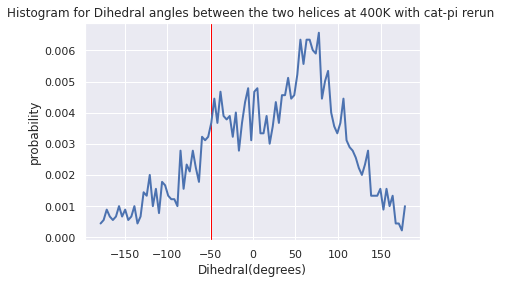

In [20]:
makehist(D[2500:], "dab", mina=-180, maxb=180, bins=100)
plt.xlabel("Dihedral(degrees)")
plt.ylabel("probability")
plt.title("Histogram for Dihedral angles between the two helices at 400K with cat-pi rerun ")
#plt.savefig("./drive/dih_400_with_cat_pi_rerun.png",dpi=300)

In [21]:
u=mda.Universe(TRAJ_PDB,TRAJ_XTC)

In [22]:
u.trajectory

<XTCReader ./drive/md_w1O_cat_pi_full_pbc2.xtc with 50001 frames of 184 atoms>

In [12]:
z
len(z)

50001

In [13]:
RMS
len(RMS)

50001

In [14]:
D
len(D)

50001

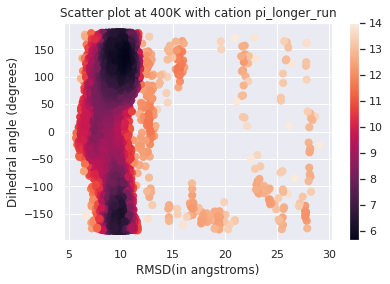

In [15]:
plt.scatter(RMS, D, c=-np.log(z), s=50)
plt.colorbar()
plt.xlabel('RMSD(in angstroms)')
plt.ylabel('Dihedral angle (degrees)')
plt.title('Scatter plot at 400K with cation pi_longer_run')
plt.savefig('./drive/scatter_plot_400_with_cat_pi_longer_run.png')